In [ ]:
##########################
###Package dependencies###
##########################
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [ ]:
#################
###Data Helper###
#################

def subsample(df, pct=0.9):
    N = len(df)
    indexer = np.sort(np.random.permutation(N)[:int(pct*N)])
    return df.loc[indexer,]

def getparty(politician):
    global df
    return df.loc[df['politician'] == politician, 'party'].iloc[0]

def getText(politician, match_type):
    global df
    return df[(df['politician'] == politician) & (df['match_type'] == match_type)]['entity_text']

def savedf(df, name):
    df.to_csv(outputpath + name + '.csv', sep=';')

######################
###Data Preparation###
######################
def preparedata(dforiginal):
    #Subsample to reduce amount of data
    df = subsample(dforiginal, 1)

    #format of dates, make date the index
    df["date"] = df["date"].astype("datetime64[ns]")
    df["startdate"] = df["startdate"].astype("datetime64[ns]")
    df["enddate"] = df["enddate"].astype("datetime64[ns]")
    df = df.sort_values(ascending=False, by=['date'])
    df["index"] = df["date"]
    df = df.set_index('index')
    df.levenshtein = df.levenshtein.replace('NaN', -1)
    df.levenshtein = df.levenshtein.astype('int64')
    df.party = df.party.replace('Bündnis 90/Die Grünen', 'Die Grünen')

    #Introduce date as an integer in order to perform regressions/correlations later
    df['datetimedelta'] = pd.to_timedelta(df['date'])
    df['datetimedelta'] = df['datetimedelta'] - df.datetimedelta.min()
    df["datetimedelta"] = df["datetimedelta"].astype("int")/(3600*24*1000000000)

    #Introduce categorical sentiment
    bins = [-1.000000001, -0.000000001, 0.000000001, 1.000000001]
    group_names = ['negative','neutral','positive']
    df['sentimentcategory'] = pd.cut(df['sentiment'], bins, labels=group_names)

    #Remove www.<>.de from newspapers
    df["newspaper_domain"] = df["newspaper"]
    newspapernames = [['www.afdkompakt.de','AfDkompakt'],
                        ['www.bayernkurier.de','Bayernkurier'],
                        ['www.bild.de','Bild'],
                        ['www.der-postillon.com','Der-Postillon'],
                        ['www.faz.net','FAZ'],
                        ['www.focus.de','Focus'],
                        ['www.fr.de','FR'],
                        ['www.gruene.de','Gruene.de'],
                        ['www.handelsblatt.de','Handelsblatt'],
                        ['www.huffingtonpost.de','Huffingtonpost'],
                        ['www.jungefreiheit.de','JungeFreiheit'],
                        ['www.jungewelt.de','JungeWelt'],
                        ['www.n-tv.de','N-TV'],
                        ['www.national-zeitung.de','National-Zeitung'],
                        ['www.neues-deutschland.de','Neues-Deutschland'],
                        ['www.spiegel.de','Spiegel'],
                        ['www.stern.de','Stern'],
                        ['www.sueddeutsche.de','Sueddeutsche'],
                        ['www.tagesschau.de','Tagesschau'],
                        ['www.tagesspiegel.de','Tagesspiegel'],
                        ['www.taz.de','TAZ'],
                        ['www.unsere-zeit.de','Unsere-Zeit'],
                        ['www.vorwaerts.de','Vorwaerts'],
                        ['www.welt.de','Welt'],
                        ['www.zeit.de','Zeit']]
    for paper in newspapernames:
        df.newspaper = df.newspaper.replace(paper[0], paper[1])
    return df

###################################
###Correction for newspaper bias###
###################################
def controlbias(df):
    #mean sentiment for each newspaper deviates depending on newspaper
    #optionally this can be controlled  
    df['sentimentoriginal'] = df.sentiment
    meandf = df.groupby(['newspaper'])['sentimentoriginal'].mean().sort_values()
    display(meandf)
    meanmean = meandf.mean()
    display(meanmean)
    newspmeancorr = meandf-meanmean
    display(newspmeancorr)
    withoutbias = meandf - newspmeancorr

    df['sentimentcorr'] = 0
    for newsp in newspmeancorr.index.tolist():
        df.sentimentcorr[df.newspaper == newsp] = df.sentiment[df.newspaper == newsp] - newspmeancorr[newsp]
    
    #mean sentiment for each PARTY deviates
    #optionally this can be controlled for by using sentimentcorrparty
    meandf = df.groupby(['party'])['sentimentoriginal'].mean().sort_values()
    meanmean = meandf.mean()
    display(meanmean)
    partymeancorr = meandf-meanmean
    display(partymeancorr)
    withoutbias = meandf - partymeancorr

    df['sentimentcorrparty'] = 0
    for part in partymeancorr.index.tolist():
        df.sentimentcorrparty[df.party == part] = df.sentimentoriginal[df.party == part] - partymeancorr[part]

    #Use df.sentiment as placeholder which can be switched from original to controlled versions
    df.sentiment = df.sentimentcorr

    return df

In [ ]:
#######################
###Import Sentiments###
#######################

dforiginal = pd.read_csv('input/preprocessedsentiments.csv', sep=';')
df = preparedata(dforiginal)
df = controlbias(df)
savefigures = False
savename = 'v10'
inputpath = os.getcwd() + "/Input"
outputpath = os.getcwd() + "/Output/"
display(df.head(10))

meancorrdf = df.groupby(['newspaper'])['sentimentoriginal'].mean()
correctiondf = pd.DataFrame({'Original Sentiment': meandf, 'Correction Margin': newspmeancorr, 'Corrected': withoutbias})
correctiondf = correctiondf.sort_values(by=['Original Sentiment'])
fig, ax = plt.subplots(figsize=(14,5))
fig.subplots_adjust(left=0.05, bottom=0.3, right=0.95, top=0.98,
                        wspace=None, hspace=None)
correctiondf.plot(kind='bar', ax=ax)
#plt.savefig("Output/meancorrection.pdf")

In [ ]:
###########################
###Colors German Parties###
###########################
afdcolor = [0, 157/255, 224/255, 1.] #R: 0 G: 157 B: 224
cducolor = [0, 0, 0, 1.] #R: 0 G: 0 B: 0
csucolor = [70/255, 70/255, 70/255, 1. ] #R: 5 G: 132 B: 209  #schwarz
gruenecolor = [30/255, 161/255, 45/255, 1. ] #R: 30 G: 161 B: 45
linkecolor = [202/255, 2/255, 107/255, 1] # reddish: R: 220 G: 0 B: 0   purple: #R: 202 G: 2 B: 107
parteicolor = [156/255, 17/255, 56/255, 1] #R: 156 G: 17 B: 56
fdpcolor = [254/255, 237/255, 1/255, 1] #R: 254 G: 237 B: 1
npdcolor = [146/255, 52/255, 23/255, 1] #R: 146 G: 52 B: 23
piratenparteicolor = [1, 136/255, 0, 1] #R: 255 G: 136 B: 0
spdcolor = [228/255, 0, 27/255, 1] #R: 228 G: 0 B: 27
fraktionslos = [128/255, 128/255, 128/255, 1] #R: 128 G: 128 B: 128
colors = [afdcolor, cducolor, csucolor, gruenecolor, linkecolor, fdpcolor,npdcolor, piratenparteicolor, spdcolor,fraktionslos]
colorsdf = pd.DataFrame(colors)
allp = df.party.sort_values().unique()
hexcolors = []
for row in colorsdf.iterrows():
    red = int(row[1][0]*255)
    green = int(row[1][1]*255)
    blue = int(row[1][2]*255)
    hexcolor = '#%02x%02x%02x' %  (red, green, blue)
    hexcolors.append(hexcolor)
colorsdf.index = allp
colorsdf['hex'] = hexcolors

colorsnewsdf = pd.DataFrame({'newspaper': df.newspaper.unique()})
hexcolors = []
for row in colorsnewsdf.iterrows():
    hexcolor = '#%02x%02x%02x' %  (np.random.randint(255),np.random.randint(255),np.random.randint(255))
    hexcolors.append(hexcolor)
colorsnewsdf['hex'] = hexcolors
colorsnewsdf.index = colorsnewsdf['newspaper']
colorsnewsdf = colorsnewsdf[['hex']]

In [ ]:
###############
###Data Sets###
###############

#Make sets for dates, newspapers, politicians, parties
all_days = pd.date_range(df.startdate.min(), df.enddate.max(), freq='D')
allnewspapers = df.newspaper.unique()
allparties = df.party.unique()
allpoliticiannames = df.politician.unique()
allpoliticians = df.groupby(['politician']).size()
allpoliticianssentiments = df.groupby(['politician', 'sentimentcategory']).size()

filterlength = int(0.92*len(allpoliticians))
frequentpoliticians = allpoliticians.sort_values(ascending=False)[:-filterlength]
frequentpoliticianslist = frequentpoliticians.index.tolist()

################
###Dataframes###
################

#NewspaperSummary
newspapersummary = df.groupby(['newspaper'])['politician', 'response_id', 'search_term', 'sentiment_id', 'url'].nunique()

In [23]:
##################
###Event Import###
##################

def addevents(ax, partyname, politicianname, df3):
    eventsub = events[(events['party'] == partyname) | (events['politician'] == politicianname)]['news']
    up = df3.max()
    low = df3.min()
    bottom = True
    for date, text in eventsub.iteritems():
        if date in df3.index:
            ycoordinate = df3.loc[date].mean()
            if ycoordinate > df3.mean():
                vz = 1
            else:
                vz = -1
            if False:
                if bottom:
                    bottom = False
                    ycoordinate = up-0.02-0.01*np.random.randint(8, size=1)[0]
                    vz = 1
                else:
                    bottom = True
                    ycoordinate = low+0.02+0.01*np.random.randint(8, size=1)[0]
                    vz = -1
            ax.annotate(text, xy=(date, ycoordinate),  xycoords='data',
                bbox=dict(boxstyle="round", fc="sandybrown", ec="gray"),
                xytext=(0, vz*40), textcoords='offset points', ha='center',
                arrowprops=dict(arrowstyle="->"))
    return ax

def addeventlist(fig, ax, idlist, df3, alternating=True):
    eventsub = events[events.id.isin(idlist)]['newsshort']
    
    up = df3.max()
    low = df3.min()
    bottom = True
    for date, text in eventsub.iteritems():
        if date in df3.index:
            ycoordinate = df3.loc[date].mean()
            if ycoordinate > df3.mean():
                vz = 1
                distance = 5+10*np.random.randn()+80*(1-(ycoordinate-df3.mean())/(up-low))
            else:
                vz = -1
                distance = 5+10*np.random.randn()+80*(1-(df3.mean()-ycoordinate)/(up-low))
            if alternating:
                if bottom:
                    bottom = False
                    if ycoordinate > df3.mean():
                        distance = 5+10*np.random.randn()+80*(1+(ycoordinate-df3.mean())/(up-low))  
                    else:
                        distance = 5+10*np.random.randn()+80*(1-(df3.mean()-ycoordinate)/(up-low))
                    vz = -1
                else:
                    bottom = True
                    if ycoordinate > df3.mean():
                        distance = 5+10*np.random.randn()+80*(1-(ycoordinate-df3.mean())/(up-df3.mean()))  
                    else:
                        distance = 5+10*np.random.randn()+80*(1+(df3.mean()-ycoordinate)/(df3.mean()-low))
                    vz = 1
            
            ax.annotate(text, xy=(date, ycoordinate),  xycoords='data',
                bbox=dict(boxstyle="round4", fc="sandybrown", ec="black"),
                xytext=(0, vz*distance), textcoords='offset points', ha='center',
                arrowprops=dict(arrowstyle="->"))
    return ax

def addeventlistlines(fig, ax, idlist, poslist, df3, alternating=True):
    eventsub = events[events.id.isin(idlist)]['newsshort']
    counter = 0
    up = df3.max()
    low = df3.min()
    bottom = True
    for date, text in eventsub.iteritems():
        if date in df3.index:
            ycoordinate = df3.loc[date].mean()
            if ycoordinate > df3.mean():
                delta = 40
            else:
                delta = 0
            if alternating:
                if bottom:
                    bottom = False
                    delta = 0
                else:
                    bottom = True
                    delta = 40
            position = poslist[counter]
            counter = counter+1
            ax.axvline(x=date, color='navy', linestyle='--')
            ax.annotate(text, xy=(date, low),  xycoords='data',
                bbox=dict(boxstyle="round4", fc="sandybrown", ec="black"),
                xytext=(0, position), textcoords='offset points', ha='center')
    return ax
#Import list of events and create method for placing it on diagrams
events = pd.read_csv('input/eventlist.csv', sep=';')
events["date"] = pd.to_datetime(events["date"], dayfirst=True, format='%Y-%m-%d', errors='raise')
events["date"] = events["date"].astype("datetime64[ns]")
events = events.set_index('date')

##############################################
###Import external party, politcian ratings###
##############################################

ratingparties = pd.read_csv('input/ratingparties.csv', sep=';')
ratingparties["date"] = pd.to_datetime(ratingparties["date"], dayfirst=True, format='%Y-%m-%d', errors='raise')
ratingparties["date"] = ratingparties["date"].astype("datetime64[ns]")
ratingparties = ratingparties.set_index('date')

ratingpoliticians = pd.read_csv('input/ratingpoliticians.csv', sep=';')
ratingpoliticians["date"] = pd.to_datetime(ratingpoliticians["date"], dayfirst=True, format='%Y-%m-%d', errors='raise')
ratingpoliticians["date"] = ratingpoliticians["date"].astype("datetime64[ns]")
ratingpoliticians = ratingpoliticians.set_index('date')

def addrating(ax, party, politician, value):
    if party:
        series = ratingparties[value]
    if politician:
        series = ratingpoliticians[value]
    series.plot(ax=ax, secondary_y=True, label=value)
    return ax

party             politician newsshort  \
date                                                      
2016-11-20         CDU          Angela Merkel       NaN   
2016-11-20         FDP      Christian Lindner       NaN   
2016-12-04   Die Linke      Sahra Wagenknecht       NaN   
2016-12-04   Die Linke        Dietmar Bartsch       NaN   
2016-12-06         CDU          Angela Merkel       NaN   
2017-01-18  Die Grünen            Cem Özdemir       NaN   
2017-01-18  Die Grünen  Katrin Göring-Eckardt       NaN   
2017-01-18  Die Grünen          Robert Habeck       NaN   
2017-01-18  Die Grünen        Anton Hofreiter       NaN   
2017-01-24         SPD         Sigmar Gabriel       NaN   

                                                         news  id  \
date                                                                
2016-11-20  Angela Merkel announces intention to stand as ...   1   
2016-11-20       FDP elect Christian Lindner as top candidate   2   
2016-12-04  Sahra Wagenknecht and Dietmar Bartsch elected ...   3   
2016-12-04  Sahra Wagenknecht and Dietmar Bartsch elected ...   4   
2016-12-06  Angela Merkel revoted as chairperson of CDU an...   5   
2017-01-18  Die Grünen elect Cem Özdemir, Katrin Göring-Ec...   6   
2017-01-18  Die Grünen elect Cem Özdemir, Katrin Göring-Ec...   7   
2017-01-18  Die Grünen elect Cem Özdemir, Katrin Göring-Ec...   8   
2017-01-18  Die Grünen elect Cem Özdemir, Katrin Göring-Ec...   9   
2017-01-24               Sigmar Gabriel renounces candidature  10   

                                                       source  
date                                                           
2016-11-20  https://www.cdu.de/artikel/merkel-will-kandidi...  
2016-11-20  https://web.archive.org/web/20161201145326/htt...  
2016-12-04  http://www.spiegel.de/politik/deutschland/die-...  
2016-12-04  http://www.spiegel.de/politik/deutschland/die-...  
2016-12-06  http://www.faz.net/aktuell/politik/merkel-mit-...  
2017-01-18  https://www.gruene.de/ueber-uns/2017/katrin-go...  
2017-01-18  https://www.gruene.de/ueber-uns/2017/katrin-go...  
2017-01-18  https://www.gruene.de/ueber-uns/2017/katrin-go...  
2017-01-18  https://www.gruene.de/ueber-uns/2017/katrin-go...  
2017-01-24  https://www.stern.de/politik/deutschland/sigma...

CDU/CSU  SPD  FDP  Die Grünen  Die Linke  AFD  CDU
date                                                          
2016-12-09      1.3  1.3  0.0         0.7       -0.5 -3.2  1.3
2017-01-13      1.5  1.3  0.2         0.4       -0.7 -3.1  1.5
2017-01-27      1.7  1.5  0.1         0.5       -0.9 -3.5  1.7
2017-02-17      1.5  2.0  0.2         0.8       -0.7 -3.4  1.4
2017-03-10      1.4  1.8  0.2         0.5       -0.7 -3.3  1.5
2017-04-07      1.7  1.9  0.1         0.4       -0.9 -3.3  1.8
2017-04-28      1.5  1.6  0.2         0.3       -0.8 -3.3  1.5
2017-05-19      1.8  1.3  0.7         0.2       -1.1 -3.3  1.8
2017-06-02      1.9  1.4  0.7         0.4       -0.8 -3.2  1.9
2017-06-23      1.8  1.3  0.5         0.2       -0.9 -3.3  1.8

Angela Merkel  Heiko Maas  Host Seehofer  Andrea Nahles  \
date                                                                  
2016-12-09            1.5         NaN            0.3            NaN   
2017-01-13            1.8         NaN            0.6            NaN   
2017-01-27            1.8         NaN            0.5            NaN   
2017-02-17            1.7         1.0            0.4            NaN   
2017-03-10            1.8         0.9            0.5            NaN   
2017-04-07            1.9         NaN            0.5            NaN   
2017-04-28            1.8         NaN            0.4            NaN   
2017-05-19            2.2         NaN            0.5            NaN   
2017-06-02            2.2         NaN            0.6            NaN   
2017-06-23            2.1         NaN            0.5            NaN   

            Wolfgang Schäuble  Sarah Wagenknecht  Christian Lindner  
date                                                                 
2016-12-09                1.6               -0.3                NaN  
2017-01-13                1.7               -0.4                NaN  
2017-01-27                1.7               -0.4                NaN  
2017-02-17                1.7               -0.4                NaN  
2017-03-10                1.6               -0.3                NaN  
2017-04-07                1.9                NaN                NaN  
2017-04-28                1.8                NaN                NaN  
2017-05-19                1.9                NaN                NaN  
2017-06-02                1.9                NaN                1.1  
2017-06-23                1.7                NaN                1.0

In [21]:
#########################
###Sentiment Denoising###
#########################

import matplotlib.dates as mdates
from scipy import signal
from scipy.fftpack import fft, fftshift

def denoisesentiment(df, windowsize, key='sentiment'):
    df1 = df[key]
    df1 = df1.sort_index(ascending=True)
    
    #Fill missing days with mean
    alldays = pd.Series(df1.mean(),all_days)
    lendf1 = len(df1)
    df = alldays + df1
    print("Filled " + str(len(df)-lendf1) + " days with mean")
    
    '''
    #Tests using Changes as indicators
    dailychanges = df1.pct_change()
    #print(dailychanges)
    std_10day = dailychanges.rolling(window=3900,center=False).std()
    #std_10day = pd.rolling_std(dailychanges, 390*10)
    #std_10day.resample('B').plot()
    
    #Tests using Tukey convolution
    window = signal.tukey(datawindow)
    myarray = signal.fftconvolve(df, window, mode='same')
    myarray = myarray*df1.mean()/myarray.mean()
    df1 = pd.Series(data=myarray, index=df.index)
    display(df1)
    '''
    
    #Using sliding window to denoise signal, windowsize is dynamic depending on average weakly sentiments in time series
    datawindow = max(int(df.resample(windowsize).agg('count').mean()),3)
    df1 = df.rolling(min_periods=int(datawindow/2), center=True, win_type= 'bohman', window=datawindow, closed='both').mean()
    
    #Resampling denoised signal for each day
    df2 = df1.resample('D').agg(['sum','mean','median','std','count'])
    
    #Smoothing with a three-day sliding window
    daywindow = 3
    df3 = df2['mean'].rolling(min_periods=1, center=True, win_type= 'bohman', window=daywindow, closed='both').mean()
    return df2['mean']

In [45]:
####################
###PolComp Export###
####################

iterables = [frequentpoliticianslist, allnewspapers]
print(len(allnewspapers)*len(frequentpoliticians))

myindex = pd.MultiIndex.from_product(iterables, names=['politician', 'newspaper'])
polcomp = pd.DataFrame(index=[all_days],
                  columns=myindex)
polcomp.index = all_days
display(polcomp)
for newsp in allnewspapers:
    for poli in frequentpoliticianslist:
        print("Processing: " + newsp + " - " + poli)
        subdf = df[(df['politician'] == poli) & (df['newspaper'] == newsp)]
        denoisedsenti = denoisesentiment(subdf, 'M')
        denoisedsenti.name = poli
        denoisedsenti.index = all_days
        #display(denoisedsenti)
        polcomp[poli,newsp] = denoisedsenti
savedf(polcomp, 'smoothedsentiments')

425


politician               SPD                                               \
newspaper  Neues-Deutschland Zeit Spiegel Huffingtonpost  FAZ Focus Stern   
2017-01-01               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-02               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-03               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-04               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-05               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-06               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-07               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-08               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-09               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-10               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-11               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-12               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-13               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-14               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-15               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-16               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-17               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-18               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-19               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-20               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-21               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-22               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-23               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-24               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-25               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-26               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-27               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-28               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-29               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2017-01-30               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
...                      ...  ...     ...            ...  ...   ...   ...   
2018-04-01               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-02               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-03               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-04               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-05               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-06               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-07               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-08               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-09               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-10               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-11               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-12               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-13               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-14               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-15               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-16               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-17               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-18               NaN  NaN     NaN            NaN  NaN   NaN   NaN   
2018-04-19               NaN  NaN     NaN            NaN  NaN   NaN   NaN

Processing: Neues-Deutschland - SPD
Filled 29 days with mean
Processing: Neues-Deutschland - CDU
Filled 40 days with mean
Processing: Neues-Deutschland - Angela Merkel
Filled 135 days with mean
Processing: Neues-Deutschland - AfD
Filled 106 days with mean
Processing: Neues-Deutschland - CSU
Filled 108 days with mean
Processing: Neues-Deutschland - Martin Schulz
Filled 193 days with mean
Processing: Neues-Deutschland - FDP
Filled 110 days with mean
Processing: Neues-Deutschland - Die Linke
Filled 67 days with mean
Processing: Neues-Deutschland - Horst Seehofer
Filled 278 days with mean
Processing: Neues-Deutschland - Sigmar Gabriel
Filled 240 days with mean
Processing: Neues-Deutschland - Christian Lindner
Filled 377 days with mean
Processing: Neues-Deutschland - Andrea Nahles
Filled 382 days with mean
Processing: Neues-Deutschland - Alexander Gauland
Filled 387 days with mean
Processing: Neues-Deutschland - Frank-Walter Steinmeier
Filled 397 days with mean
Processing: Neues-Deutschland

Filled 15 days with mean
Processing: Bild - Angela Merkel
Filled 52 days with mean
Processing: Bild - AfD
Filled 134 days with mean
Processing: Bild - CSU
Filled 60 days with mean
Processing: Bild - Martin Schulz
Filled 120 days with mean
Processing: Bild - FDP
Filled 55 days with mean
Processing: Bild - Die Linke
Filled 164 days with mean
Processing: Bild - Horst Seehofer
Filled 207 days with mean
Processing: Bild - Sigmar Gabriel
Filled 184 days with mean
Processing: Bild - Christian Lindner
Filled 268 days with mean
Processing: Bild - Andrea Nahles
Filled 348 days with mean
Processing: Bild - Alexander Gauland
Filled 346 days with mean
Processing: Bild - Frank-Walter Steinmeier
Filled 284 days with mean
Processing: Bild - Olaf Scholz
Filled 270 days with mean
Processing: Bild - Heiko Maas
Filled 333 days with mean
Processing: Bild - Alexander Dobrindt
Filled 369 days with mean
Processing: FR - SPD
Filled 12 days with mean
Processing: FR - CDU
Filled 11 days with mean
Processing: FR 

Filled 95 days with mean
Processing: AfDkompakt - CSU
Filled 394 days with mean
Processing: AfDkompakt - Martin Schulz
Filled 424 days with mean
Processing: AfDkompakt - FDP
Filled 159 days with mean
Processing: AfDkompakt - Die Linke
Filled 371 days with mean
Processing: AfDkompakt - Horst Seehofer
Filled 448 days with mean
Processing: AfDkompakt - Sigmar Gabriel
Filled 464 days with mean
Processing: AfDkompakt - Christian Lindner
Filled 460 days with mean
Processing: AfDkompakt - Andrea Nahles
Filled 476 days with mean
Processing: AfDkompakt - Alexander Gauland
Filled 134 days with mean
Processing: AfDkompakt - Frank-Walter Steinmeier
Filled 476 days with mean
Processing: AfDkompakt - Olaf Scholz
Filled 476 days with mean
Processing: AfDkompakt - Heiko Maas
Filled 451 days with mean
Processing: AfDkompakt - Alexander Dobrindt
Filled 476 days with mean
Processing: Tagesschau - SPD
Filled 188 days with mean
Processing: Tagesschau - CDU
Filled 207 days with mean
Processing: Tagesschau -

Filled 479 days with mean
Processing: Der-Postillon - Heiko Maas
Filled 481 days with mean
Processing: Der-Postillon - Alexander Dobrindt
Filled 482 days with mean
Processing: National-Zeitung - SPD
Filled 471 days with mean
Processing: National-Zeitung - CDU
Filled 471 days with mean
Processing: National-Zeitung - Angela Merkel
Filled 471 days with mean
Processing: National-Zeitung - AfD
Filled 477 days with mean
Processing: National-Zeitung - CSU
Filled 477 days with mean
Processing: National-Zeitung - Martin Schulz
Filled 475 days with mean
Processing: National-Zeitung - FDP
Filled 483 days with mean
Processing: National-Zeitung - Die Linke
Filled 485 days with mean
Processing: National-Zeitung - Horst Seehofer
Filled 483 days with mean
Processing: National-Zeitung - Sigmar Gabriel
Filled 481 days with mean
Processing: National-Zeitung - Christian Lindner
Filled 482 days with mean
Processing: National-Zeitung - Andrea Nahles
Filled 485 days with mean
Processing: National-Zeitung - A

politician               SPD                                               \
newspaper  Neues-Deutschland      Zeit   Spiegel Huffingtonpost       FAZ   
2017-01-01               NaN       NaN       NaN            NaN       NaN   
2017-01-02               NaN       NaN       NaN            NaN       NaN   
2017-01-03               NaN -0.237513 -0.225632      -0.305314 -0.237404   
2017-01-04               NaN -0.237584 -0.225636      -0.304069 -0.237247   
2017-01-05               NaN -0.237601 -0.225627      -0.303759 -0.237225   
2017-01-06               NaN -0.237626 -0.225615      -0.302393 -0.237132   
2017-01-07               NaN -0.237649 -0.225579      -0.300723 -0.237035   
2017-01-08               NaN -0.237732 -0.225462      -0.296653 -0.237010   
2017-01-09         -0.147621 -0.237800 -0.225201      -0.289367 -0.236823   
2017-01-10         -0.148839 -0.237820 -0.224236      -0.283101 -0.236567   
2017-01-11         -0.149949 -0.237832 -0.223059      -0.279157 -0.236440   
2017-01-12         -0.150142 -0.237835 -0.222765      -0.276803 -0.236324   
2017-01-13         -0.150340 -0.237837 -0.222610      -0.271358 -0.236250   
2017-01-14         -0.150543 -0.237838 -0.222369      -0.263308 -0.236146   
2017-01-15         -0.163826 -0.237117 -0.213154      -0.228623 -0.232490   
2017-01-16         -0.182640 -0.235365 -0.201445      -0.210811 -0.228235   
2017-01-17         -0.183246 -0.235240 -0.200142      -0.206313 -0.227630   
2017-01-18         -0.187535 -0.235088 -0.197769      -0.203288 -0.227106   
2017-01-19         -0.191852 -0.234922 -0.195660      -0.199135 -0.226698   
2017-01-20         -0.192470 -0.234763 -0.194478      -0.196074 -0.226510   
2017-01-21         -0.193088 -0.234689 -0.193044      -0.193828 -0.226285   
2017-01-22         -0.193706 -0.234639 -0.191832      -0.188866 -0.226038   
2017-01-23         -0.194939 -0.234231 -0.189767      -0.183576 -0.225884   
2017-01-24         -0.196170 -0.233770 -0.187918      -0.179099 -0.225709   
2017-01-25         -0.196784 -0.233580 -0.186793      -0.174094 -0.225698   
2017-01-26         -0.199229 -0.232875 -0.186066      -0.170785 -0.225792   
2017-01-27         -0.201659 -0.232212 -0.185943      -0.169905 -0.225951   
2017-01-28         -0.202861 -0.231604 -0.185837      -0.170345 -0.226154   
2017-01-29         -0.204056 -0.230946 -0.185947      -0.172837 -0.226484   
2017-01-30         -0.204649 -0.230280 -0.186276      -0.179539 -0.226861   
...                      ...       ...       ...            ...       ...   
2018-04-01         -0.172831 -0.260583 -0.162198      -0.250375 -0.197115   
2018-04-02         -0.172709 -0.257234 -0.162562      -0.249649 -0.198266   
2018-04-03         -0.172574 -0.250712 -0.163344      -0.248682 -0.200615   
2018-04-04         -0.172996 -0.242603 -0.164398      -0.247237 -0.203843   
2018-04-05         -0.174863 -0.231884 -0.165375      -0.245215 -0.208613   
2018-04-06         -0.177499 -0.222152 -0.166653      -0.242999 -0.214177   
2018-04-07         -0.180305 -0.213873 -0.168450      -0.240981 -0.217743   
2018-04-08         -0.183243 -0.205432 -0.170814      -0.237901 -0.222085   
2018-04-09         -0.186431 -0.202116 -0.173707      -0.235311 -0.226130   
2018-04-10         -0.191475 -0.199489 -0.176766      -0.232960 -0.229753   
2018-04-11         -0.198661 -0.199588 -0.179512      -0.227796 -0.235584   
2018-04-12         -0.205675 -0.202052 -0.180548      -0.222188 -0.240201   
2018-04-13         -0.211020 -0.207614 -0.183863      -0.218590 -0.243076   
2018-04-14         -0.214181 -0.214453 -0.186829      -0.216117 -0.244670   
2018-04-15         -0.218588 -0.218130 -0.187551      -0.212929 -0.244926   
2018-04-16         -0.222825 -0.226579 -0.187991      -0.207670 -0.244215   
2018-04-17         -0.225234 -0.234040 -0.187457      -0.200862 -0.242001   
2018-04-18         -0.227556 -0.234954 -0.184515      -0.195324 -0.237009   
2018-04-19         -0.229387 -0.233459 -0.177871      -0.193240 -0.230857

In [54]:
import scipy
from scipy.stats import beta
from scipy.stats import norm

def fitseries(news, poli):
    #get series of politician and newspaper
    series = polcomp[poli, news]
    #get mean of all other newspapers
    newdf = polcomp[poli]
    newdf = newdf.drop(news, axis=1)
    meandf = newdf.mean(axis=1)
    #get delta
    deltaserie = series - meandf
    deltaserie = deltaserie.dropna()
    deltaserieslen = len(deltaserie)
    mu = 'NaN'
    std = 'NaN'
    statistic = 'NaN'
    pvalue = 'NaN'
    if deltaserieslen >7:
        mu, std = norm.fit(deltaserie)
        testresult = scipy.stats.mstats.normaltest(deltaserie, axis=0)
        statistic = testresult[0]
        pvalue = testresult[1]
        '''
        title = 'Histogramm of ' + poli + " in " + news
        fig, ax = plt.subplots(figsize=(8,6))
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=None, hspace=None)
        ax.set_xlabel('Sentiment')
        ax.set_ylabel('Frequency')
        ax.set_title(title)
        myplot = sns.distplot(deltaserie, ax=ax)
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k', linewidth=2, color='orange')
        if savefigures:
            plt.savefig(outputpath + 'hist_' + poli + news + '.pdf')
        else:
            plt.show()
        '''
    return mu, std, statistic, pvalue, deltaserieslen

In [55]:
maximum = len(allnewspapers) * len(frequentpoliticianslist)
counter = 0
resultarray = []
for newsp1 in allnewspapers:
    for poli1 in frequentpoliticianslist:
        print(str(counter) + "/" + str(maximum))
        mu, std, statistic, pvalue, deltaserieslen = fitseries(newsp1, poli1)
        counter = counter + 1
        resultarray.append((newsp1, poli1, mu, std, statistic, pvalue, deltaserieslen))

0/425
1/425
2/425
3/425
4/425
5/425
6/425
7/425
8/425
9/425
10/425
11/425
12/425
13/425
14/425
15/425
16/425
17/425
18/425
19/425
20/425
21/425
22/425
23/425
24/425
25/425
26/425
27/425
28/425
29/425
30/425
31/425
32/425
33/425
34/425
35/425
36/425
37/425
38/425
39/425
40/425
41/425
42/425
43/425
44/425
45/425
46/425
47/425
48/425
49/425
50/425
51/425
52/425
53/425
54/425
55/425
56/425
57/425
58/425
59/425
60/425
61/425
62/425
63/425
64/425
65/425
66/425
67/425
68/425
69/425
70/425
71/425
72/425
73/425
74/425
75/425
76/425
77/425
78/425
79/425
80/425
81/425
82/425
83/425
84/425
85/425
86/425
87/425
88/425
89/425
90/425
91/425
92/425
93/425
94/425
95/425
96/425
97/425
98/425
99/425
100/425
101/425
102/425
103/425
104/425
105/425
106/425
107/425
108/425
109/425
110/425
111/425
112/425
113/425
114/425
115/425
116/425
117/425
118/425
119/425
120/425
121/425
122/425
123/425
124/425
125/425
126/425
127/425
128/425
129/425
130/425
131/425
132/425
133/425
134/425
135/425
136/425
137/425
138/42

/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  np.min(n))


216/425
217/425
218/425
219/425
220/425
221/425
222/425
223/425
224/425
225/425
226/425
227/425
228/425
229/425
230/425
231/425
232/425
233/425
234/425
235/425
236/425
237/425
238/425
239/425
240/425
241/425
242/425
243/425
244/425
245/425
246/425
247/425
248/425
249/425
250/425
251/425
252/425
253/425
254/425
255/425
256/425
257/425
258/425
259/425
260/425
261/425
262/425
263/425
264/425
265/425
266/425
267/425
268/425
269/425
270/425
271/425
272/425
273/425
274/425
275/425
276/425
277/425
278/425
279/425
280/425
281/425
282/425
283/425
284/425


/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  np.min(n))
/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  np.min(n))


285/425
286/425
287/425
288/425
289/425
290/425
291/425
292/425
293/425
294/425
295/425
296/425
297/425
298/425
299/425
300/425
301/425
302/425
303/425
304/425
305/425
306/425
307/425
308/425
309/425
310/425
311/425
312/425
313/425
314/425
315/425
316/425
317/425
318/425
319/425
320/425
321/425
322/425
323/425
324/425
325/425
326/425
327/425
328/425
329/425
330/425
331/425
332/425
333/425
334/425
335/425
336/425
337/425
338/425
339/425
340/425


/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  np.min(n))
/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


341/425
342/425
343/425
344/425
345/425
346/425
347/425
348/425
349/425
350/425
351/425
352/425
353/425
354/425
355/425
356/425
357/425
358/425
359/425
360/425
361/425
362/425
363/425
364/425
365/425
366/425
367/425
368/425
369/425
370/425
371/425
372/425
373/425
374/425
375/425


/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  np.min(n))
/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  np.min(n))


376/425
377/425
378/425
379/425
380/425
381/425
382/425
383/425
384/425
385/425
386/425
387/425
388/425
389/425


/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  np.min(n))
/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  np.min(n))


390/425
391/425
392/425
393/425
394/425
395/425
396/425
397/425
398/425
399/425
400/425
401/425
402/425
403/425
404/425
405/425
406/425
407/425
408/425
409/425
410/425
411/425
412/425
413/425
414/425
415/425
416/425
417/425
418/425
419/425
420/425
421/425
422/425
423/425
424/425


/Users/Julian/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2191: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  np.min(n))


In [72]:
resultdf = pd.DataFrame(resultarray, columns=['newspaper', 'politician','mu', 'std', 'statistic', 'pvalue', 'count'])
resultdf = resultdf.reset_index()
polparty = df[['party','politician']]
polparty = polparty.drop_duplicates()
resultdf = polparty.merge(resultdf,on='politician')#, how='right')
resultdf['mu'] = resultdf['mu'].astype('float64')
resultdf['std'] = resultdf['std'].astype('float64')
resultdf['std'] = resultdf['std'].astype('float64')
resultdf['pvalue'] = resultdf['pvalue'].astype('float64')
resultdf['count'] = resultdf['count'].astype('float64')
resultdf
resultdf = resultdf.set_index(['newspaper', 'party', 'politician'])
savedf(resultdf,'politiciansparameters')

In [73]:
resultdf

index        mu       std  \
newspaper         party politician                                           
Neues-Deutschland CDU   Angela Merkel                2 -0.003495  0.056988   
Zeit              CDU   Angela Merkel               19  0.039515  0.031972   
Spiegel           CDU   Angela Merkel               36  0.041708  0.030175   
Huffingtonpost    CDU   Angela Merkel               53  0.040607  0.050306   
FAZ               CDU   Angela Merkel               70  0.069145  0.033319   
Focus             CDU   Angela Merkel               87 -0.072600  0.025377   
Stern             CDU   Angela Merkel              104  0.028342  0.064170   
Welt              CDU   Angela Merkel              121  0.011999  0.028854   
Bild              CDU   Angela Merkel              138  0.058608  0.036141   
FR                CDU   Angela Merkel              155  0.057119  0.032510   
Tagesspiegel      CDU   Angela Merkel              172 -0.013042  0.043052   
Vorwaerts         CDU   Angela Merkel              189 -0.088241  0.097322   
Sueddeutsche      CDU   Angela Merkel              206  0.034223  0.028042   
TAZ               CDU   Angela Merkel              223 -0.010134  0.043244   
N-TV              CDU   Angela Merkel              240  0.121210  0.039934   
Handelsblatt      CDU   Angela Merkel              257  0.030582  0.053134   
AfDkompakt        CDU   Angela Merkel              274 -0.371352  0.050311   
Tagesschau        CDU   Angela Merkel              291  0.029118  0.054235   
JungeWelt         CDU   Angela Merkel              308  0.007561  0.138231   
JungeFreiheit     CDU   Angela Merkel              325 -0.071088  0.114917   
Gruene.de         CDU   Angela Merkel              342  0.063146  0.285181   
Bayernkurier      CDU   Angela Merkel              359 -0.025233  0.147374   
Unsere-Zeit       CDU   Angela Merkel              376  0.075827  0.193719   
Der-Postillon     CDU   Angela Merkel              393  0.182321  0.189367   
National-Zeitung  CDU   Angela Merkel              410 -0.011610  0.136184   
Neues-Deutschland CDU   CDU                          1  0.004172  0.024410   
Zeit              CDU   CDU                         18 -0.019673  0.025546   
Spiegel           CDU   CDU                         35 -0.014442  0.029455   
Huffingtonpost    CDU   CDU                         52 -0.039115  0.039852   
FAZ               CDU   CDU                         69 -0.025409  0.022250   
...                                                ...       ...       ...   
Gruene.de         SPD   Frank-Walter Steinmeier    353       NaN       NaN   
Bayernkurier      SPD   Frank-Walter Steinmeier    370 -0.125195  0.279609   
Unsere-Zeit       SPD   Frank-Walter Steinmeier    387  0.245537  0.034217   
Der-Postillon     SPD   Frank-Walter Steinmeier    404       NaN       NaN   
National-Zeitung  SPD   Frank-Walter Steinmeier    421       NaN       NaN   
Neues-Deutschland CSU   Alexander Dobrindt          16 -0.099461  0.219610   
Zeit              CSU   Alexander Dobrindt          33  0.013982  0.092487   
Spiegel           CSU   Alexander Dobrindt          50  0.060579  0.082703   
Huffingtonpost    CSU   Alexander Dobrindt          67 -0.026093  0.166908   
FAZ               CSU   Alexander Dobrindt          84  0.004948  0.106353   
Focus             CSU   Alexander Dobrindt         101  0.014205  0.079228   
Stern             CSU   Alexander Dobrindt         118 -0.030799  0.185055   
Welt              CSU   Alexander Dobrindt         135 -0.018895  0.079720   
Bild              CSU   Alexander Dobrindt         152 -0.006261  0.116574   
FR                CSU   Alexander Dobrindt         169 -0.049525  0.118577   
Tagesspiegel      CSU   Alexander Dobrindt         186 -0.002870  0.106136   
Vorwaerts         CSU   Alexander Dobrindt         203 -0.343976  0.414654   
Sueddeutsche      CSU   Alexander Dobrindt         220 -0.028675  0.080930   
TAZ               CSU   Alexander Dobrindt         237 -0.109693  0.185

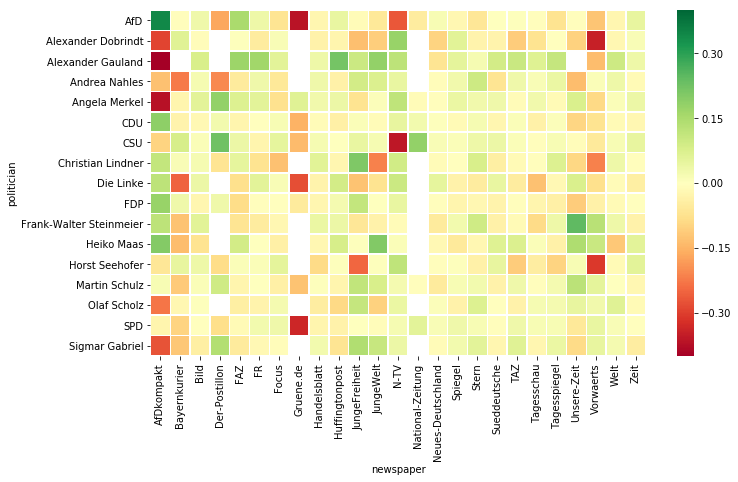

In [78]:
def getpolcomheatmap(df1, key, vmin, vmax, color):
    pivotdf =  pd.pivot_table(df1, values=key, index=['politician'], columns=['newspaper'], aggfunc=np.mean)
    fig, ax = plt.subplots(figsize=(10,10))
    fig.subplots_adjust(left=0.13, bottom=0.4, right=0.99, top=None,
                            wspace=None, hspace=None)
    #plt.title(title) 
    sns.heatmap(pivotdf, linewidths=.5, ax=ax, cmap=color, center=(vmin + vmax) / 2., vmax=vmax, vmin=vmin)
    #plt.savefig('Output/heatmap.pdf')
#getpolcomheatmap(resultdf, 'pvalue', 0, 1, "ocean")
#getpolcomheatmap(resultdf, 'count', 0, 700, 'ocean')
getpolcomheatmap(resultdf, 'mu', -0.4, 0.4, 'RdYlGn')

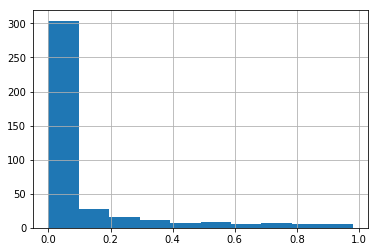

In [75]:
resultdf.pvalue.hist()

In [160]:
######################
#Political Compass_V1#
######################
display(allparties)
# fixed party locations as from https://www.politicalcompass.org/germany2017 (if given)
party_to_location = {
    'AfD': [5.5, 8],
    'fraktionslos': [5.5, 8],
    'Die Grünen': [2, 4.5],
    'CDU': [8, 5.5],
    'CSU': [4, 7],
    'Die Linke': [-2.5, -1.5],
    # 'diepartei': [0, 0],  # not given, best guess
    'FDP': [7, 3],
    'NPD': [9, 9],  # not given, best guess
    'Piratenpartei': [-1, -1],  # not given, best guess
    'SPD': [3, 2.5],
}

array(['CDU', 'SPD', 'Die Linke', 'FDP', 'CSU', 'AfD', 'Die Grünen',
       'fraktionslos', 'NPD', 'Piratenpartei'], dtype=object)

In [411]:
def bootstrap(df, newspaper, totalpoints, sigma=2):
    newsppolcomparray = []
    subdf = df[df['newspaper'] == newspaper]
    bootstrap = max(int(totalpoints/len(subdf)),2)
    subdf = subdf[['politician', 'party', 'sentimentoriginal', 'sentimentcorr','sentimentcorrparty']]
    #display(subdf)
    for row in subdf.iterrows():
        #print(row)
        pol = row[1]['politician']
        part = row[1]['party']
        seno = row[1]['sentimentoriginal']
        senc = row[1]['sentimentcorr']
        sencp = row[1]['sentimentcorrparty']
        mux = party_to_location[part][0]
        muy = party_to_location[part][1]
        for i in range(0,bootstrap):
            x = np.random.normal(mux, sigma, 1)
            y = np.random.normal(muy, sigma, 1)
            newrow = [pol, part, seno, senc, sencp, mux, muy, int(x),int(y)]
            newsppolcomparray.append(newrow)
            #print(poli, party, sentiorig, senticorr)
    nppc = pd.DataFrame(newsppolcomparray, 
                        columns=['politician', 'party', 'sentimentoriginal', 'sentimentcorr','sentimentcorrparty','mux', 'muy','x', 'y'])
    return nppc



In [412]:
def plotcompdensity(nppc,percent,name):
    subnppc = subsample(nppc, percent)

    fig, ax = plt.subplots(figsize=(5,5))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                                wspace=None, hspace=None)
    ax = sns.kdeplot(subnppc['x'], subnppc['y'], n_levels=30, cmap="Purples_d")
    if savefigures:
        plt.savefig(outputpath + 'polcomp_' + name + '_density_' + savename + '.pdf')
    else:
        plt.show()

In [635]:
def drawcompass(nppc, value, minobservation, vmin, vmax, name):
    nppc['x'] = nppc['x'].astype("category")
    nppc['y'] = nppc['y'].astype("category")
    dfmean = pd.crosstab(nppc['y'], nppc['x'], rownames=['y'], colnames=['x'], values=value, aggfunc=[np.mean])
    dflen = pd.crosstab(nppc['y'], nppc['x'], rownames=['y'], colnames=['x'], values=value, aggfunc=[len])
    dfmean = dfmean.sort_index(ascending=False)
    dflen = dflen.sort_index(ascending=False)
    idx = pd.IndexSlice
    mask = dflen.loc[:,idx['len',:]]<minobservation
    #display(mask1)
    mask['len'].name = 'mean'
    #display(mask)
    mask.columns = mask.columns.droplevel(0)
    dfmean.columns = dfmean.columns.droplevel(0)
    dfmean[mask] = np.nan
    
    r,c = dfmean.shape
    cmin = max(int(0.5*c-10),0)
    cmax = min(int(0.5*c+10),c)
    rmin = max(int(0.5*r-10),0)
    rmax = min(int(0.5*r+10),r)
    dfmean = dfmean.iloc[rmin:rmax,cmin:cmax]
    
    fig, ax = plt.subplots(figsize=(5,4))
    fig.subplots_adjust(left=0.17, bottom=0.15, right=0.9, top=0.9,
                                wspace=None, hspace=None)
    dfmean.name = name
    m1 = dfmean.mean()
    #print(m1)
    vmean = m1.mean()
    #print(vmean)
    vmin = vmean-0.075
    vmax = vmean+0.075
    
    sns.heatmap(dfmean, linewidths=.5, ax=ax, cmap="RdYlGn", center=(vmin + vmax) / 2., vmax=vmax, vmin=vmin)
    
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.set_xticklabels([''] + ['left'] + [''] * (cmax-cmin-4) + ['right'])
    ax.set_yticklabels([''] + ['autocratic'] + [''] * (rmax-rmin-5) + ['liberal'])
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelrotation='default') 
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelright=False,
        labelleft=True,
        labelrotation='auto') 
    
    ax.set_title(name)
    #ax.legend_.remove()
    if savefigures:
        plt.savefig(outputpath + 'polcomp_' + name + '_' + savename + '.pdf')
    else:
        plt.show() 
    maxindexeachrow = dfmean.idxmax()
    maxmaxindex = maxindexeachrow
    
    maxvalueeachrow = dfmean.max()
    maxmaxvalue = maxvalueeachrow.max()
    
    xmax = maxvalueeachrow.idxmax()
    ymax = maxindexeachrow[xmax]
    print(xmax,ymax)
    xmax, ymax = getmaximumarea(dfmean)
    print(xmax,ymax)
    return [xmax,ymax]
        

In [641]:
def getmaximumarea(df):
    resultdf = pd.DataFrame(0, index=df.index, columns=df.columns)
    resultdf = resultdf.replace(0, 'NaN')
    for row in range(0,resultdf.shape[0]-1):
        for col in range(0, resultdf.shape[1]-1):
            if row < 1 or col < 1:
                continue
            booldf = ~np.isnan(df.iloc[row-1:row+2,col-1:col+2])
            #display(booldf)
            if booldf.eq(True).all().eq(True).all():
                resultdf.iloc[row,col] = df.iloc[row-1:row+2,col-1:col+2].sum(axis = 1, skipna=True).sum(axis = 0, skipna=True)
    display(df)
    display(resultdf)
    resultdf = resultdf.astype('float64')
    maxindexeachrow = resultdf.idxmax()
    maxmaxindex = maxindexeachrow
    maxvalueeachrow = resultdf.max()
    maxmaxvalue = maxvalueeachrow.max()
    xmax = maxvalueeachrow.idxmax()
    ymax = maxindexeachrow[xmax]
    return (xmax, ymax)
df1 = pd.DataFrame(np.random.randint(2,size=(6,4)), index=list('123456'), columns=list('ABCD'))
df1.iloc[1,1] = np.nan
df1.iloc[2,2] = np.nan
row = 4
col = 2
#foundmax = getmaximumarea(df1)
#display(foundmax)

Bootstrapping: Neues-Deutschland
Densityplot: Neues-Deutschland
Compass: Neues-Deutschland
3 -1.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.101888   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.109788   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.105864   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.098256   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.100762   
 2   NaN  NaN       NaN       NaN       NaN       NaN -0.119646 -0.105110   
 1   NaN  NaN       NaN -0.113676 -0.125773 -0.125959 -0.126769 -0.098238   
 0   NaN  NaN -0.126764 -0.121693 -0.124763 -0.126343 -0.122515 -0.117627   
-1   NaN  NaN -0.127834 -0.116170 -0.121710 -0.120307 -0.116465 -0.115334   
-2   NaN  NaN -0.126341 -0.109274 -0.116902 -0.119658 -0.119423 -0.120099   
-3   NaN  NaN -0.112832 -0.126078 -0.116713 -0.121358 -0.127132 -0.122932   
-4   NaN  NaN       NaN -0.124639 -0.109948 -0.119286 -0.106649 -0.120712   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-7   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN -0.135401 -0.138012 -0.125819 -0.136953 -0.139955   
 9  -0.105777 -0.125873 -0.118109 -0.126805 -0.134889 -0.129673 -0.126133   
 8  -0.119336 -0.117357 -0.115857 -0.125104 -0.125818 -0.128098 -0.122820   
 7  -0.107656 -0.120349 -0.119871 -0.116075 -0.123732 -0.120870 -0.119394   
 6  -0.098126 -0.115276 -0.111311 -0.116447 -0.119286 -0.117165 -0.113245   
 5  -0.110192 -0.112474 -0.110953 -0.109240 -0.109965 -0.107568 -0.106491   
 4  -0.102365 -0.099534 -0.103026 -0.103275 -0.102757 -0.107879 -0.109180   
 3  -0.104920 -0.097279 -0.097894 -0.097771 -0.092090 -0.099040 -0.101932   
 2  -0.099621 -0.099714 -0.098816 -0.098838 -0.097889 -0.093479 -0.096196   
 1  -0.097067 -0.100193 -0.100021 -0.100269 -0.095517 -0.096083 -0.095428   
 0  -0.095769 -0.093585 -0.097342 -0.093805 -0.095508 -0.087230 -0.086117   
-1  -0.101631 -0.100513 -0.082549       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-7        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.156388 -0.143203       NaN       NaN  NaN  
 9  -0.134546 -0.133602 -0.156079       NaN  NaN  
 8  -0.124176 -0.125336 -0.142279       NaN  NaN  
 7  -0.117328 -0.114249 -0.110643 -0.116112  NaN  
 6  -0.114789 -0.110972 -0.109412 -0.124418  NaN  
 5  -0.108072 -0.112487 -0.111328 -0.114189  NaN  
 4  -0.110344 -0.109516 -0.116930 -0.105031  NaN  
 3  -0.103122 -0.116277 -0.102291 -0.113431  NaN 

x    -7   -6   -5       -4       -3       -2       -1         0         1   \
y                                                                            
 12  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
 11  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
 10  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
 9   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
 8   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
 7   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
 6   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN -0.981613   
 5   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN -0.951875   
 4   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN -0.931646   
 3   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN -0.907561   
 2   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN -0.902903   
 1   NaN  NaN  NaN      NaN      NaN      NaN      NaN  -0.98236 -0.906922   
 0   NaN  NaN  NaN      NaN -1.09639  -1.1106 -1.06956 -0.991414 -0.919955   
-1   NaN  NaN  NaN -1.09145 -1.07682 -1.08808 -1.07777       NaN       NaN   
-2   NaN  NaN  NaN -1.07385 -1.06817 -1.07967 -1.08271       NaN       NaN   
-3   NaN  NaN  NaN      NaN -1.06386 -1.05707 -1.07725       NaN       NaN   
-4   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
-5   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
-6   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   
-7   NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9        NaN       NaN  -1.14581  -1.17117  -1.17016  -1.19874  -1.20616   
 8   -1.05019   -1.0854  -1.10626  -1.13106  -1.13143  -1.12304  -1.11758   
 7   -1.02514  -1.05765   -1.0735  -1.09259  -1.09043  -1.07788  -1.06231   
 6   -1.00621    -1.032  -1.03688  -1.04035  -1.03772  -1.02492  -1.01703   
 5  -0.963257 -0.981537  -0.98626 -0.993582 -0.993536 -0.994733 -0.995096   
 4  -0.938636 -0.931445 -0.926971 -0.929586 -0.936903 -0.953629 -0.977421   
 3  -0.903169 -0.896147 -0.892356 -0.893019 -0.900443 -0.919894 -0.950785   
 2  -0.895523 -0.890794 -0.879106 -0.870977 -0.867655 -0.883717  -0.92292   
 1  -0.882126 -0.882583 -0.878007 -0.858619 -0.843448 -0.844297       NaN   
 0  -0.868668       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-7        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9        10   11   12  
y                                 
 12       NaN      NaN  NaN  NaN  
 11       NaN      NaN  NaN  NaN  
 10       NaN      NaN  NaN  NaN  
 9        NaN      NaN  NaN  NaN  
 8   -1.15824      NaN  NaN  NaN  
 7   -1.06918      NaN  NaN  NaN  
 6   -1.00928 -1.02381  NaN  NaN  
 5   -1.00385 -1.01428  NaN  NaN  
 4  -0.990367 -1.00148  NaN  NaN  
 3  -0.979812      NaN  NaN  NaN  
 2        NaN      NaN  NaN  NaN  
 1        NaN      NaN  NaN  NaN  
 0        NaN      NaN  NaN  NaN  
-1        NaN      NaN  NaN  NaN  
-2        NaN      NaN  NaN 

6 1.0
Bootstrapping: Zeit
Densityplot: Zeit
Compass: Zeit
2 8.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.098712   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.096523   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.105362   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.105089   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.107880   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.108709   
 2   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.106329   
 1   NaN  NaN       NaN       NaN       NaN       NaN -0.138575 -0.103261   
 0   NaN  NaN -0.134934 -0.151845 -0.153599 -0.155748 -0.152221 -0.121126   
-1   NaN  NaN       NaN -0.147201 -0.147012 -0.154923 -0.149104 -0.151864   
-2   NaN  NaN       NaN -0.169315 -0.161921 -0.160095 -0.148766 -0.159516   
-3   NaN  NaN       NaN -0.149557 -0.149932 -0.155519 -0.160638 -0.163090   
-4   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.123289       NaN       NaN   
 10       NaN -0.109265 -0.113941 -0.116906 -0.120360 -0.125368 -0.138883   
 9  -0.110648 -0.094581 -0.106905 -0.110014 -0.121645 -0.120002 -0.126202   
 8  -0.099163 -0.090303 -0.102869 -0.111513 -0.113703 -0.118957 -0.120296   
 7  -0.104282 -0.093737 -0.099564 -0.108134 -0.114328 -0.116940 -0.121693   
 6  -0.110985 -0.103086 -0.105939 -0.104988 -0.110500 -0.115595 -0.117641   
 5  -0.101288 -0.104217 -0.092308 -0.102986 -0.109615 -0.116148 -0.113864   
 4  -0.103317 -0.106314 -0.108648 -0.100157 -0.108025 -0.107439 -0.116066   
 3  -0.102698 -0.104246 -0.104144 -0.108494 -0.104340 -0.103888 -0.109372   
 2  -0.106635 -0.105655 -0.106317 -0.106694 -0.100750 -0.099837 -0.105845   
 1  -0.104928 -0.104049 -0.103678 -0.104809 -0.103672 -0.098735 -0.099225   
 0  -0.106064 -0.104496 -0.106147 -0.105711 -0.100943 -0.099565 -0.100410   
-1  -0.116733 -0.117980 -0.116683       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.128129       NaN       NaN       NaN  NaN  
 9  -0.134805 -0.113573       NaN       NaN  NaN  
 8  -0.124717 -0.122960 -0.113924       NaN  NaN  
 7  -0.120817 -0.116330 -0.106013 -0.107942  NaN  
 6  -0.115910 -0.115549 -0.120601 -0.136460  NaN  
 5  -0.115704 -0.116893 -0.115006 -0.117581  NaN  
 4  -0.112886 -0.115668 -0.113347 -0.095810  NaN 

x    -7   -6   -5   -4       -3       -2       -1        0         1   \
y                                                                       
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.902153   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.924569   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN  -0.94754   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.943758   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.951782   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.946509   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.962543   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN -1.14388   -1.0305   
-1   NaN  NaN  NaN  NaN -1.40166 -1.38339 -1.35336      NaN       NaN   
-2   NaN  NaN  NaN  NaN -1.39548 -1.38791 -1.40351      NaN       NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9        NaN -0.956297  -1.01785  -1.05847  -1.10542  -1.13736       NaN   
 8  -0.902051  -0.91762 -0.988675  -1.03523  -1.07376  -1.10443  -1.10139   
 7  -0.909928 -0.920133 -0.971538  -1.01466  -1.04965  -1.07257  -1.07591   
 6  -0.915406 -0.914959 -0.948361 -0.999234  -1.03632  -1.05431   -1.0544   
 5  -0.936102 -0.928643 -0.943165 -0.975453  -1.01489  -1.03125  -1.04018   
 4  -0.927179 -0.931514 -0.938717 -0.961093 -0.988757  -1.00632  -1.02885   
 3  -0.947973 -0.950669 -0.947568 -0.939624 -0.955562 -0.963164 -0.993212   
 2   -0.94235 -0.948087 -0.942897 -0.931219 -0.925663 -0.919193 -0.957323   
 1  -0.947969 -0.947556  -0.93872 -0.920715 -0.908982 -0.893622       NaN   
 0  -0.980757       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9        10   11   12  
y                                 
 13       NaN      NaN  NaN  NaN  
 12       NaN      NaN  NaN  NaN  
 11       NaN      NaN  NaN  NaN  
 10       NaN      NaN  NaN  NaN  
 9        NaN      NaN  NaN  NaN  
 8        NaN      NaN  NaN  NaN  
 7   -1.05682      NaN  NaN  NaN  
 6   -1.04282 -1.05238  NaN  NaN  
 5   -1.04156 -1.04692  NaN  NaN  
 4   -1.03221 -1.01022  NaN  NaN  
 3  -0.995728      NaN  NaN  NaN  
 2        NaN      NaN  NaN  NaN  
 1        NaN      NaN  NaN  NaN  
 0        NaN      NaN  NaN  NaN  
-1        NaN      NaN  NaN  NaN  
-2        NaN      NaN  NaN  NaN  
-3        NaN      NaN  NaN  NaN  
-4        NaN      NaN  NaN  NaN 

7 1.0
Bootstrapping: Spiegel
Densityplot: Spiegel
Compass: Spiegel
5 0.0


x    -7   -6       -5        -4        -3        -2        -1         0   \
y                                                                          
 14  NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.144093   
 7   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.148366   
 6   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.149374   
 5   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.145766   
 4   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.145872   
 3   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.144333   
 2   NaN  NaN      NaN       NaN       NaN       NaN       NaN -0.141954   
 1   NaN  NaN      NaN       NaN       NaN       NaN -0.162899 -0.148134   
 0   NaN  NaN -0.22077 -0.209094 -0.215002 -0.214137 -0.206275 -0.165907   
-1   NaN  NaN      NaN -0.203381 -0.206446 -0.209379 -0.198224 -0.195498   
-2   NaN  NaN      NaN -0.208941 -0.203084 -0.196475 -0.200486 -0.201181   
-3   NaN  NaN      NaN -0.204814 -0.213150 -0.218429 -0.210152 -0.202332   
-4   NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN      NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.184018 -0.198294       NaN       NaN   
 10       NaN -0.184287 -0.185930 -0.183072 -0.183528 -0.192359 -0.193403   
 9  -0.162989 -0.156362 -0.177221 -0.178721 -0.185989 -0.187646 -0.193571   
 8  -0.157429 -0.165489 -0.170172 -0.178368 -0.186209 -0.183113 -0.181606   
 7  -0.151473 -0.160739 -0.164919 -0.170649 -0.177634 -0.178409 -0.173074   
 6  -0.149610 -0.153664 -0.160107 -0.164531 -0.170805 -0.169595 -0.165665   
 5  -0.147005 -0.152289 -0.153245 -0.156480 -0.167036 -0.164367 -0.162403   
 4  -0.141134 -0.143150 -0.143244 -0.149724 -0.159172 -0.158262 -0.162346   
 3  -0.144207 -0.141704 -0.144041 -0.146929 -0.149807 -0.153695 -0.156443   
 2  -0.140651 -0.143409 -0.145221 -0.147394 -0.142348 -0.140037 -0.148922   
 1  -0.139157 -0.138525 -0.141630 -0.144091 -0.141558 -0.148455 -0.139863   
 0  -0.141752 -0.142511 -0.145910 -0.144211 -0.137882 -0.143727 -0.146120   
-1  -0.164691 -0.149382 -0.150373       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 14       NaN       NaN       NaN       NaN  NaN  
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.205702       NaN       NaN       NaN  NaN  
 9  -0.188160 -0.196134       NaN       NaN  NaN  
 8  -0.174992 -0.190144 -0.189014       NaN  NaN  
 7  -0.173088 -0.166652 -0.174651 -0.160163  NaN  
 6  -0.166734 -0.165284 -0.162381 -0.169992  NaN  
 5  -0.162707 -0.160187 -0.164667 -0.161466  NaN  
 4  -0.160520 -0.163

x    -7   -6   -5   -4       -3       -2       -1        0        1        2   \
y                                                                               
 14  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -1.46679   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -1.38024  -1.4336   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -1.35829 -1.39305   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -1.32786 -1.34345   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -1.30546 -1.31002   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -1.28641 -1.28676   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -1.28207 -1.27855   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   -1.302 -1.27877   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN -1.52254 -1.38556 -1.31393   
-1   NaN  NaN  NaN  NaN -1.86594 -1.84951 -1.78756      NaN      NaN      NaN   
-2   NaN  NaN  NaN  NaN  -1.8641 -1.85583 -1.83216      NaN      NaN      NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN      NaN   

x         3        4        5        6        7        8        9        10  \
y                                                                             
 14      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 13      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 12      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 11      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 10      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 9  -1.57962 -1.62921   -1.659 -1.68742 -1.70055      NaN      NaN      NaN   
 8  -1.52264 -1.58988 -1.62674 -1.64725 -1.63366 -1.63742      NaN      NaN   
 7  -1.48864 -1.54339 -1.57931 -1.58611 -1.56628 -1.55724 -1.56294      NaN   
 6  -1.43662 -1.48541 -1.51951 -1.52899 -1.51604 -1.49579 -1.49635 -1.48544   
 5  -1.37643 -1.42434 -1.45997 -1.47965  -1.4726 -1.46934 -1.46828  -1.4823   
 4   -1.3308 -1.36968 -1.40547 -1.43353 -1.44002  -1.4505 -1.45177 -1.45041   
 3  -1.30482 -1.32788 -1.34737 -1.37103 -1.39157 -1.42374 -1.43295      NaN   
 2  -1.29294 -1.30302 -1.31431 -1.32113 -1.34634 -1.37145      NaN      NaN   
 1   -1.2929 -1.29025  -1.2897 -1.28891 -1.30872      NaN      NaN      NaN   
 0       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-1       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-2       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-3       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-4       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-5       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

x     11   12  
y              
 14  NaN  NaN  
 13  NaN  NaN  
 12  NaN  NaN  
 11  NaN  NaN  
 10  NaN  NaN  
 9   NaN  NaN  
 8   NaN  NaN  
 7   NaN  NaN  
 6   NaN  NaN  
 5   NaN  NaN  
 4   NaN  NaN  
 3   NaN  NaN  
 2   NaN  NaN  
 1   NaN  NaN  
 0   NaN  NaN  
-1   NaN  NaN  
-2   NaN  NaN  
-3   NaN  NaN  
-4   NaN  NaN  
-5   NaN  NaN

2 2.0
Bootstrapping: Huffingtonpost
Densityplot: Huffingtonpost
Compass: Huffingtonpost
-1 -4.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.127427   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.106649   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.121756   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.112906   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.111653   
 2   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.107759   
 1   NaN  NaN       NaN       NaN -0.061603 -0.073105 -0.080193 -0.105683   
 0   NaN  NaN -0.058436 -0.061462 -0.064076 -0.064285 -0.067163 -0.081507   
-1   NaN  NaN -0.080222 -0.068289 -0.071789 -0.062477 -0.063981 -0.070475   
-2   NaN  NaN -0.069397 -0.063394 -0.062439 -0.062979 -0.070513 -0.067264   
-3   NaN  NaN       NaN -0.080470 -0.062275 -0.063855 -0.059816 -0.072501   
-4   NaN  NaN       NaN       NaN -0.074943 -0.058519 -0.057920 -0.066566   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.098101 -0.123351 -0.109188       NaN   
 10       NaN -0.104601 -0.119202 -0.114840 -0.123237 -0.116395 -0.127324   
 9  -0.114823 -0.107471 -0.110579 -0.116062 -0.114094 -0.119493 -0.113232   
 8  -0.118804 -0.109283 -0.112693 -0.111267 -0.113318 -0.115436 -0.116431   
 7  -0.101361 -0.110115 -0.110177 -0.107885 -0.109513 -0.112319 -0.108363   
 6  -0.102115 -0.110650 -0.110775 -0.112298 -0.115600 -0.109694 -0.111379   
 5  -0.106209 -0.104308 -0.109068 -0.105437 -0.109408 -0.108332 -0.106955   
 4  -0.115599 -0.106285 -0.110841 -0.106701 -0.107619 -0.105661 -0.105764   
 3  -0.109213 -0.110643 -0.108812 -0.101985 -0.094571 -0.098142 -0.098525   
 2  -0.104549 -0.105379 -0.105019 -0.098802 -0.098286 -0.089617 -0.087524   
 1  -0.103290 -0.105104 -0.104600 -0.105579 -0.102160 -0.095306 -0.089669   
 0  -0.104618 -0.107507 -0.105334 -0.101622 -0.096849 -0.090414 -0.084884   
-1  -0.084304 -0.086561 -0.116676       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.126384       NaN       NaN       NaN  NaN  
 9  -0.123544 -0.139900       NaN       NaN  NaN  
 8  -0.118404 -0.117478 -0.113773       NaN  NaN  
 7  -0.110463 -0.106868 -0.106060 -0.114136  NaN  
 6  -0.105127 -0.108004 -0.099360 -0.112849  NaN  
 5  -0.106841 -0.112360 -0.106679 -0.116930  NaN  
 4  -0.105870 -0.104978 -0.112944 -0.100314  NaN 

x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 1   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 0   NaN  NaN  NaN       NaN       NaN -0.608672 -0.668868 -0.761214   
-1   NaN  NaN  NaN -0.599504 -0.581189 -0.589701 -0.610643       NaN   
-2   NaN  NaN  NaN       NaN -0.597966 -0.580124 -0.593861       NaN   
-3   NaN  NaN  NaN       NaN       NaN -0.573258 -0.579934       NaN   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN  -1.03476       NaN       NaN   
 9        NaN       NaN    -1.006  -1.03529  -1.04414  -1.05896  -1.07664   
 8        NaN -0.995307 -0.995533  -1.00559  -1.01939   -1.0222  -1.03769   
 7        NaN -0.985974 -0.995143  -1.00353  -1.00733  -1.01205  -1.00762   
 6  -0.990592 -0.964779 -0.980714 -0.990161 -0.990487 -0.991564 -0.979473   
 5  -0.986478 -0.975851 -0.976364 -0.987748  -0.98075 -0.980412 -0.965622   
 4  -0.998572 -0.980978 -0.964081 -0.954443 -0.937856 -0.934976 -0.935246   
 3  -0.983985 -0.976339 -0.954467 -0.932636 -0.901383 -0.885709 -0.880532   
 2  -0.963273 -0.956609 -0.945923 -0.919814 -0.884447 -0.853799  -0.84538   
 1  -0.925396   -0.9454 -0.938946 -0.918251 -0.878635 -0.834709 -0.813308   
 0  -0.849049 -0.917995       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10   11   12  
y                                            
 13       NaN       NaN       NaN  NaN  NaN  
 12       NaN       NaN       NaN  NaN  NaN  
 11       NaN       NaN       NaN  NaN  NaN  
 10       NaN       NaN       NaN  NaN  NaN  
 9        NaN       NaN       NaN  NaN  NaN  
 8   -1.05468       NaN       NaN  NaN  NaN  
 7   -1.00252 -0.985537       NaN  NaN  NaN  
 6   -0.97636 -0.961761 -0.983245  NaN  NaN  
 5  -0.967277 -0.962162 -0.974418  NaN  NaN  
 4  -0.945087 -0.964882 -0.965731  NaN  NaN  
 3   -0.89094 -0.920225       NaN  NaN  NaN  
 2  -0.845238       NaN       NaN  NaN  NaN  
 1        NaN       NaN       NaN  NaN  NaN  
 0        NaN       NaN       

-2 -3.0
Bootstrapping: FAZ
Densityplot: FAZ
Compass: FAZ
5 11.0


x    -6        -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN       NaN       NaN       NaN       NaN       NaN -0.077673   
 7   NaN       NaN       NaN       NaN       NaN       NaN -0.099958   
 6   NaN       NaN       NaN       NaN       NaN       NaN -0.096360   
 5   NaN       NaN       NaN       NaN       NaN       NaN -0.102678   
 4   NaN       NaN       NaN       NaN       NaN       NaN -0.099845   
 3   NaN       NaN       NaN       NaN       NaN       NaN -0.096575   
 2   NaN       NaN       NaN       NaN       NaN       NaN -0.089402   
 1   NaN       NaN       NaN       NaN -0.085333 -0.111549 -0.096256   
 0   NaN -0.082637 -0.083967 -0.086789 -0.089702 -0.094731 -0.093651   
-1   NaN -0.097466 -0.088662 -0.089774 -0.084756 -0.085172 -0.096546   
-2   NaN       NaN -0.093644 -0.085156 -0.089392 -0.078008 -0.085811   
-3   NaN       NaN -0.082681 -0.078781 -0.090438 -0.089484 -0.091506   
-4   NaN       NaN       NaN       NaN -0.098943       NaN       NaN   
-5   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.068937 -0.056775 -0.059119       NaN   
 10       NaN -0.069373 -0.075191 -0.074289 -0.067481 -0.067210 -0.067789   
 9  -0.088471 -0.081723 -0.077672 -0.074687 -0.070801 -0.069545 -0.078648   
 8  -0.079980 -0.075787 -0.077187 -0.072304 -0.073351 -0.076137 -0.081343   
 7  -0.080893 -0.084336 -0.078452 -0.073098 -0.074904 -0.076173 -0.091322   
 6  -0.093917 -0.093240 -0.084080 -0.077502 -0.081620 -0.089400 -0.097561   
 5  -0.099862 -0.093805 -0.089254 -0.083661 -0.085621 -0.094531 -0.094392   
 4  -0.097428 -0.093733 -0.091132 -0.089568 -0.094506 -0.092152 -0.097602   
 3  -0.096386 -0.099741 -0.094893 -0.094494 -0.092423 -0.094618 -0.094692   
 2  -0.095739 -0.095109 -0.095734 -0.094682 -0.095311 -0.085600 -0.094138   
 1  -0.095648 -0.097806 -0.092442 -0.094869 -0.089211 -0.086568 -0.087215   
 0  -0.090744 -0.091869 -0.096437 -0.095162 -0.104227 -0.096570 -0.095950   
-1  -0.085317 -0.117146 -0.090317       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12   13  
y                                                      
 13       NaN       NaN       NaN       NaN  NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  NaN  
 10 -0.066955       NaN       NaN       NaN  NaN  NaN  
 9  -0.094749 -0.086491       NaN       NaN  NaN  NaN  
 8  -0.090339 -0.097177 -0.105634       NaN  NaN  NaN  
 7  -0.097466 -0.100560 -0.092157 -0.096627  NaN  NaN  
 6  -0.099321 -0.105579 -0.102565 -0.100376  NaN  NaN  
 5  -0.096036 -0.094860 -0.097076 -0.096211  NaN  NaN  
 4  -0.093200 -0.094245 -0.104131 -0.107111  NaN  NaN  
 3  -0.097639 -0.099164 -0.089162 -0.092371  NaN

x    -6   -5   -4        -3        -2        -1         0         1   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.782144   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN  -0.84505   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.870869   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.880052   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.863957   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.862661   
 1   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.846224   
 0   NaN  NaN  NaN       NaN       NaN -0.837698 -0.849615 -0.864983   
-1   NaN  NaN  NaN -0.791843 -0.783481  -0.79777       NaN       NaN   
-2   NaN  NaN  NaN -0.783284 -0.770962 -0.791115       NaN       NaN   
-3   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN -0.608844       NaN       NaN       NaN   
 9        NaN -0.678213 -0.662962 -0.645805 -0.652304 -0.692715       NaN   
 8  -0.724499 -0.695245 -0.672455    -0.661 -0.692223 -0.755722 -0.818094   
 7  -0.747872 -0.715987 -0.692499 -0.694491 -0.741812 -0.799062 -0.860668   
 6   -0.79784 -0.757429 -0.728192  -0.73651 -0.785524 -0.836203 -0.877098   
 5  -0.836451 -0.795976 -0.776945 -0.788561 -0.827384 -0.854194 -0.872796   
 4  -0.856233  -0.83028 -0.815552 -0.821574 -0.840537 -0.854861  -0.86183   
 3  -0.859894 -0.849085 -0.842743 -0.833354 -0.841042 -0.840836 -0.855655   
 2  -0.863498  -0.85977 -0.844059 -0.827777 -0.819777 -0.826225 -0.838449   
 1  -0.851528  -0.85411 -0.858075   -0.8422 -0.834789  -0.81967       NaN   
 0  -0.857726       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10   11   12   13  
y                                       
 13       NaN       NaN  NaN  NaN  NaN  
 12       NaN       NaN  NaN  NaN  NaN  
 11       NaN       NaN  NaN  NaN  NaN  
 10       NaN       NaN  NaN  NaN  NaN  
 9        NaN       NaN  NaN  NaN  NaN  
 8        NaN       NaN  NaN  NaN  NaN  
 7  -0.890798       NaN  NaN  NaN  NaN  
 6  -0.885621 -0.886011  NaN  NaN  NaN  
 5  -0.887013 -0.902154  NaN  NaN  NaN  
 4  -0.865513 -0.874331  NaN  NaN  NaN  
 3  -0.857713       NaN  NaN  NaN  NaN  
 2        NaN       NaN  NaN  NaN  NaN  
 1        NaN       NaN  NaN  NaN  NaN  
 0        NaN       NaN  NaN  NaN  NaN  
-1        NaN       NaN  NaN  NaN  NaN  
-2        NaN       NaN

5 10.0
Bootstrapping: Focus
Densityplot: Focus
Compass: Focus
0 8.0


x    -6       -5        -4        -3        -2        -1         0         1   \
y                                                                               
 13  NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN      NaN       NaN       NaN       NaN       NaN       NaN -0.123925   
 8   NaN      NaN       NaN       NaN       NaN       NaN -0.111314 -0.126627   
 7   NaN      NaN       NaN       NaN       NaN       NaN -0.127001 -0.120628   
 6   NaN      NaN       NaN       NaN       NaN       NaN -0.124126 -0.136667   
 5   NaN      NaN       NaN       NaN       NaN       NaN -0.133186 -0.121766   
 4   NaN      NaN       NaN       NaN       NaN       NaN -0.127151 -0.128433   
 3   NaN      NaN       NaN       NaN       NaN       NaN -0.127156 -0.121768   
 2   NaN      NaN       NaN       NaN       NaN       NaN -0.125631 -0.127047   
 1   NaN      NaN       NaN       NaN       NaN -0.165339 -0.128509 -0.125297   
 0   NaN -0.17448 -0.160372 -0.157279 -0.153653 -0.154748 -0.133876 -0.124549   
-1   NaN      NaN -0.168682 -0.169772 -0.158150 -0.156458 -0.165280       NaN   
-2   NaN      NaN -0.170929 -0.154792 -0.151636 -0.160677 -0.166521       NaN   
-3   NaN      NaN -0.176151 -0.159660 -0.162523 -0.150879 -0.162284       NaN   
-4   NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.183922       NaN       NaN       NaN   
 10 -0.148959 -0.165704 -0.168019 -0.181463 -0.178755 -0.202267 -0.172734   
 9  -0.151091 -0.159219 -0.172785 -0.180443 -0.189874 -0.179745 -0.171574   
 8  -0.137563 -0.143077 -0.159857 -0.172900 -0.177680 -0.177251 -0.170267   
 7  -0.132730 -0.142860 -0.157535 -0.163454 -0.163852 -0.165107 -0.158029   
 6  -0.131093 -0.132057 -0.141969 -0.151657 -0.163320 -0.156058 -0.153557   
 5  -0.121890 -0.129774 -0.139559 -0.148381 -0.155485 -0.152899 -0.155005   
 4  -0.129942 -0.127606 -0.132523 -0.141074 -0.149427 -0.154086 -0.154967   
 3  -0.123998 -0.124585 -0.127474 -0.135955 -0.144737 -0.149107 -0.151832   
 2  -0.126403 -0.122480 -0.124691 -0.131697 -0.141662 -0.139683 -0.148954   
 1  -0.130128 -0.127072 -0.125641 -0.125731 -0.138569 -0.140019 -0.144281   
 0  -0.126655 -0.125680 -0.125231 -0.132964 -0.129356 -0.135842 -0.138011   
-1  -0.130014 -0.115426       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10        11   12   13  
y                                            
 13       NaN       NaN       NaN  NaN  NaN  
 12       NaN       NaN       NaN  NaN  NaN  
 11       NaN       NaN       NaN  NaN  NaN  
 10       NaN       NaN       NaN  NaN  NaN  
 9  -0.174423       NaN       NaN  NaN  NaN  
 8  -0.156854 -0.165068       NaN  NaN  NaN  
 7  -0.156338 -0.158702 -0.166856  NaN  NaN  
 6  -0.152327 -0.164691 -0.159340  NaN  NaN  
 5  -0.153535 -0.150439 -0.148452  NaN  NaN  
 4  -0.157711 -0

x    -6   -5   -4       -3       -2       -1    0        1        2        3   \
y                                                                               
 13  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
 12  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
 11  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
 10  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
 9   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN -1.40627   
 8   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN -1.23772 -1.35672   
 7   NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.14775  -1.2033 -1.27874   
 6   NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.14909 -1.16947 -1.22947   
 5   NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.15425 -1.15923 -1.18641   
 4   NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.13529 -1.12976 -1.15735   
 3   NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.13753 -1.13226  -1.1397   
 2   NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.13594 -1.12878 -1.13247   
 1   NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.1481 -1.13531 -1.13398   
 0   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
-1   NaN  NaN  NaN -1.44526 -1.41716   -1.401  NaN      NaN      NaN      NaN   
-2   NaN  NaN  NaN -1.47229 -1.42455 -1.43441  NaN      NaN      NaN      NaN   
-3   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
-4   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
-5   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   
-6   NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN      NaN   

x         4        5        6        7        8        9        10   11   12  \
y                                                                              
 13      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
 12      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
 11      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
 10      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
 9  -1.50347 -1.58178 -1.64038 -1.62015      NaN      NaN      NaN  NaN  NaN   
 8  -1.45213 -1.53838 -1.57031 -1.55338 -1.50959      NaN      NaN  NaN  NaN   
 7  -1.36537 -1.45223 -1.49128 -1.48512 -1.44579 -1.43583      NaN  NaN  NaN   
 6  -1.30725 -1.38521 -1.42021 -1.42331 -1.40286 -1.40262 -1.41068  NaN  NaN   
 5   -1.2446 -1.32339 -1.37239  -1.3948 -1.39014 -1.39815 -1.40325  NaN  NaN   
 4  -1.20693 -1.27461 -1.33115 -1.36754 -1.38296 -1.39056 -1.40686  NaN  NaN   
 3  -1.16808 -1.22924 -1.28743 -1.33445 -1.36238 -1.37961      NaN  NaN  NaN   
 2  -1.14532 -1.19616 -1.24716 -1.29884 -1.31563      NaN      NaN  NaN  NaN   
 1  -1.14119 -1.17554 -1.21552 -1.25638      NaN      NaN      NaN  NaN  NaN   
 0       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
-1       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
-2       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
-3       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
-4       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
-5       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN   

x     13  
y         
 13  NaN  
 12  NaN  
 11  NaN  
 10  NaN  
 9   NaN  
 8   NaN  
 7   NaN  
 6   NaN  
 5   NaN  
 4   NaN  
 3   NaN  
 2   NaN  
 1   NaN  
 0   NaN  
-1   NaN  
-2   NaN  
-3   NaN  
-4   NaN  
-5   NaN  
-6   NaN

2 2.0
Bootstrapping: Stern
Densityplot: Stern
Compass: Stern
7 0.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.124639   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.126552   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.150304   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.134154   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.122086   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.112081   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.093001   
 1   NaN  NaN  NaN       NaN       NaN       NaN -0.138098 -0.094426   
 0   NaN  NaN  NaN -0.184615 -0.177719 -0.181661 -0.176455 -0.113312   
-1   NaN  NaN  NaN -0.183016 -0.182372 -0.180051 -0.183428 -0.153032   
-2   NaN  NaN  NaN -0.174658 -0.172064 -0.181783 -0.191932 -0.183704   
-3   NaN  NaN  NaN       NaN -0.187230 -0.176749 -0.190828 -0.186798   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.182250 -0.179232 -0.190862       NaN   
 10       NaN -0.151988 -0.147870 -0.171092 -0.168251 -0.183244 -0.169937   
 9  -0.132951 -0.145309 -0.152819 -0.161009 -0.168618 -0.173238 -0.181881   
 8  -0.124194 -0.126049 -0.148212 -0.153660 -0.164729 -0.159751 -0.154994   
 7  -0.128007 -0.128047 -0.139840 -0.146819 -0.152685 -0.149784 -0.135675   
 6  -0.132765 -0.127166 -0.128745 -0.136591 -0.142161 -0.134526 -0.124185   
 5  -0.121660 -0.117454 -0.111193 -0.125267 -0.125816 -0.120085 -0.119432   
 4  -0.109280 -0.108109 -0.105845 -0.107252 -0.107472 -0.111216 -0.109558   
 3  -0.097202 -0.095856 -0.097102 -0.096783 -0.099585 -0.103850 -0.104380   
 2  -0.094991 -0.093412 -0.092848 -0.092112 -0.091766 -0.093354 -0.098237   
 1  -0.093861 -0.092711 -0.089869 -0.090437 -0.084383 -0.087781 -0.092932   
 0  -0.093235 -0.088789 -0.091120 -0.093589 -0.084698 -0.087748 -0.083074   
-1  -0.104422 -0.112279 -0.096154       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.183820       NaN       NaN       NaN  NaN  
 9  -0.173049 -0.176993       NaN       NaN  NaN  
 8  -0.143544 -0.134135 -0.135548       NaN  NaN  
 7  -0.121849 -0.125265 -0.113053 -0.132214  NaN  
 6  -0.116906 -0.121972 -0.108678 -0.131821  NaN  
 5  -0.112124 -0.114032 -0.114627 -0.109559  NaN  
 4  -0.113307 -0.117428 -0.112033 -0.111857  NaN  
 3  -0.114361 -0.103434 -0.104394 -0.098044  NaN  
 2  -0.102922 -0.099831 -0.111911       NaN  NaN  
 1  -0

x    -7   -6   -5   -4       -3       -2       -1        0         1   \
y                                                                       
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN  -1.16772   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN  -1.16611   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN  -1.12298   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN  -1.01788   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.926019   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.867541   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.857738   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN -1.15027 -0.946068   
-1   NaN  NaN  NaN  NaN -1.61794 -1.62746 -1.54536      NaN       NaN   
-2   NaN  NaN  NaN  NaN      NaN -1.64644  -1.6283      NaN       NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN   -1.5778       NaN       NaN       NaN   
 9        NaN  -1.35801  -1.43626  -1.50359  -1.52464  -1.52346       NaN   
 8   -1.22543  -1.30176  -1.38839  -1.43029  -1.44136  -1.39376  -1.34739   
 7   -1.18303  -1.23513  -1.31344  -1.34071  -1.31849  -1.24121  -1.17853   
 6   -1.13488  -1.16112  -1.20912  -1.23373  -1.20435  -1.13457  -1.09144   
 5   -1.06222  -1.06762  -1.09034  -1.11039  -1.09445  -1.06134  -1.04894   
 4  -0.963702 -0.964862 -0.976317 -0.997328   -1.0014  -1.00831  -1.00806   
 3  -0.894646  -0.88932 -0.890767  -0.90339 -0.919418 -0.951184 -0.963457   
 2  -0.847853  -0.84113 -0.834885  -0.84005 -0.856267 -0.890857 -0.911261   
 1  -0.830837 -0.824887 -0.810822 -0.805868 -0.803973 -0.836873       NaN   
 0   -0.86244       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10   11   12  
y                                  
 13       NaN       NaN  NaN  NaN  
 12       NaN       NaN  NaN  NaN  
 11       NaN       NaN  NaN  NaN  
 10       NaN       NaN  NaN  NaN  
 9        NaN       NaN  NaN  NaN  
 8        NaN       NaN  NaN  NaN  
 7   -1.12095       NaN  NaN  NaN  
 6   -1.04851  -1.07122  NaN  NaN  
 5   -1.03111  -1.04201  NaN  NaN  
 4   -1.00574 -0.985407  NaN  NaN  
 3  -0.979621       NaN  NaN  NaN  
 2        NaN       NaN  NaN  NaN  
 1        NaN       NaN  NaN  NaN  
 0        NaN       NaN  NaN  NaN  
-1        NaN       NaN  NaN  NaN  
-2        NaN       NaN  NaN  NaN  
-3        NaN       NaN  NaN  NaN  
-4        NaN 

6 1.0
Bootstrapping: Welt
Densityplot: Welt
Compass: Welt
4 1.0


x    -6        -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN       NaN       NaN       NaN       NaN       NaN -0.125727   
 7   NaN       NaN       NaN       NaN       NaN       NaN -0.116601   
 6   NaN       NaN       NaN       NaN       NaN       NaN -0.120411   
 5   NaN       NaN       NaN       NaN       NaN       NaN -0.119407   
 4   NaN       NaN       NaN       NaN       NaN       NaN -0.114031   
 3   NaN       NaN       NaN       NaN       NaN       NaN -0.106700   
 2   NaN       NaN       NaN       NaN       NaN       NaN -0.100537   
 1   NaN       NaN       NaN       NaN       NaN -0.161879 -0.103679   
 0   NaN -0.195236 -0.175136 -0.170495 -0.172888 -0.174634 -0.121766   
-1   NaN       NaN -0.185844 -0.176498 -0.172136 -0.174140 -0.173361   
-2   NaN       NaN -0.158547 -0.181856 -0.169388 -0.176087 -0.162162   
-3   NaN       NaN -0.170208 -0.174544 -0.176840 -0.175020 -0.154634   
-4   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.154760       NaN       NaN   
 10       NaN -0.135128 -0.134767 -0.146553 -0.151447 -0.163843 -0.174907   
 9  -0.129920 -0.134782 -0.132011 -0.140173 -0.144704 -0.159771 -0.149625   
 8  -0.118610 -0.125699 -0.129452 -0.137418 -0.143865 -0.143951 -0.131953   
 7  -0.119250 -0.122330 -0.126190 -0.127663 -0.135862 -0.136804 -0.133846   
 6  -0.119388 -0.113071 -0.118487 -0.118585 -0.128516 -0.126978 -0.124521   
 5  -0.109925 -0.114874 -0.108868 -0.118415 -0.114690 -0.120009 -0.121429   
 4  -0.105237 -0.103404 -0.103895 -0.104377 -0.109807 -0.116463 -0.117121   
 3  -0.104587 -0.102745 -0.101181 -0.102657 -0.106934 -0.108691 -0.114873   
 2  -0.100866 -0.097282 -0.098105 -0.099541 -0.096850 -0.104685 -0.105393   
 1  -0.097223 -0.095835 -0.096539 -0.093015 -0.096574 -0.103607 -0.103070   
 0  -0.099461 -0.097431 -0.099143 -0.096306 -0.096056 -0.106805 -0.104896   
-1  -0.114455 -0.110454 -0.100127       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12   13  
y                                                      
 13       NaN       NaN       NaN       NaN  NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  NaN  
 10       NaN       NaN       NaN       NaN  NaN  NaN  
 9  -0.149055 -0.143643       NaN       NaN  NaN  NaN  
 8  -0.140871 -0.133894 -0.142593       NaN  NaN  NaN  
 7  -0.126289 -0.127311 -0.119671 -0.115921  NaN  NaN  
 6  -0.124181 -0.119168 -0.127132 -0.119333  NaN  NaN  
 5  -0.120098 -0.117756 -0.124938 -0.120915  NaN  NaN  
 4  -0.120266 -0.120885 -0.119833 -0.127250  NaN  NaN  
 3  -0.112501 -0.116366 -0.109077 -0.116890  NaN

x    -6   -5   -4       -3       -2       -1       0         1         2   \
y                                                                           
 13  NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
 12  NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
 11  NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
 10  NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
 9   NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
 8   NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN  -1.13824   
 7   NaN  NaN  NaN      NaN      NaN      NaN     NaN  -1.08109  -1.09248   
 6   NaN  NaN  NaN      NaN      NaN      NaN     NaN  -1.05526  -1.05238   
 5   NaN  NaN  NaN      NaN      NaN      NaN     NaN  -1.01975 -0.997149   
 4   NaN  NaN  NaN      NaN      NaN      NaN     NaN -0.980909 -0.954716   
 3   NaN  NaN  NaN      NaN      NaN      NaN     NaN -0.935388 -0.917301   
 2   NaN  NaN  NaN      NaN      NaN      NaN     NaN -0.909452 -0.894361   
 1   NaN  NaN  NaN      NaN      NaN      NaN     NaN  -0.91408 -0.881884   
 0   NaN  NaN  NaN      NaN      NaN      NaN -1.2206  -1.01367 -0.910668   
-1   NaN  NaN  NaN -1.56279 -1.56812 -1.49656     NaN       NaN       NaN   
-2   NaN  NaN  NaN -1.56586 -1.57651 -1.53377     NaN       NaN       NaN   
-3   NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
-4   NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
-5   NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   
-6   NaN  NaN  NaN      NaN      NaN      NaN     NaN       NaN       NaN   

x          3         4         5         6         7         8        9   \
y                                                                          
 13       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 9   -1.21598  -1.26039  -1.33173  -1.36407       NaN       NaN      NaN   
 8   -1.17572  -1.21734  -1.27021  -1.28038  -1.27216  -1.23649      NaN   
 7    -1.1189  -1.16604  -1.19964   -1.2063  -1.18939  -1.16203 -1.16111   
 6   -1.06848  -1.09728  -1.12752  -1.14266  -1.13416   -1.1146 -1.10654   
 5   -1.00398  -1.02564  -1.05784  -1.07954  -1.09107  -1.08543 -1.09426   
 4  -0.960417 -0.970825  -1.00204  -1.03002  -1.05145   -1.0613 -1.06172   
 3  -0.913186 -0.923348 -0.950006 -0.980818  -1.00751  -1.03124 -1.03562   
 2  -0.886898 -0.891395 -0.912554 -0.940677 -0.962478 -0.988913      NaN   
 1  -0.873196 -0.872128 -0.893439 -0.917936 -0.949975 -0.956424      NaN   
 0        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN      NaN   

x         10   11   12   13  
y                            
 13      NaN  NaN  NaN  NaN  
 12      NaN  NaN  NaN  NaN  
 11      NaN  NaN  NaN  NaN  
 10      NaN  NaN  NaN  NaN  
 9       NaN  NaN  NaN  NaN  
 8       NaN  NaN  NaN  NaN  
 7       NaN  NaN  NaN  NaN  
 6  -1.09215  NaN  NaN  NaN  
 5  -1.09721  NaN  NaN  NaN  
 4  -1.07391  NaN  NaN  NaN  
 3       NaN  NaN  NaN  NaN  
 2       NaN  NaN  NaN  NaN  
 1       NaN  NaN  NaN  NaN  
 0       NaN  NaN  NaN  NaN  
-1       NaN  NaN  NaN  NaN  
-2       NaN  NaN  NaN  NaN  
-3       NaN  NaN  NaN  NaN  
-4       NaN  NaN  NaN  NaN  
-5       NaN  NaN  NaN  NaN  
-6

4 1.0
Bootstrapping: Bild
Densityplot: Bild
Compass: Bild
9 1.0


x    -6        -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN       NaN       NaN       NaN       NaN       NaN -0.095806   
 7   NaN       NaN       NaN       NaN       NaN       NaN -0.080755   
 6   NaN       NaN       NaN       NaN       NaN       NaN -0.100174   
 5   NaN       NaN       NaN       NaN       NaN       NaN -0.096077   
 4   NaN       NaN       NaN       NaN       NaN       NaN -0.090584   
 3   NaN       NaN       NaN       NaN       NaN       NaN -0.088398   
 2   NaN       NaN       NaN       NaN       NaN       NaN -0.083265   
 1   NaN       NaN       NaN       NaN       NaN -0.106063 -0.078962   
 0   NaN -0.116678 -0.108801 -0.112057 -0.108934 -0.102393 -0.090095   
-1   NaN       NaN -0.109411 -0.116653 -0.116852 -0.106398 -0.102451   
-2   NaN       NaN -0.111295 -0.113099 -0.111996 -0.112975 -0.107200   
-3   NaN       NaN -0.110497 -0.118471 -0.104086 -0.105871 -0.104744   
-4   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.112894       NaN       NaN   
 10       NaN -0.090843 -0.105909 -0.112546 -0.107816 -0.116038 -0.125655   
 9  -0.105936 -0.097501 -0.099697 -0.101647 -0.102530 -0.104371 -0.101509   
 8  -0.088337 -0.095964 -0.094935 -0.099269 -0.102910 -0.102315 -0.102821   
 7  -0.101007 -0.090772 -0.091904 -0.095528 -0.096079 -0.098020 -0.097391   
 6  -0.092460 -0.087975 -0.090745 -0.090840 -0.098908 -0.096701 -0.096740   
 5  -0.094070 -0.090502 -0.082988 -0.088978 -0.093205 -0.095432 -0.096345   
 4  -0.089563 -0.081940 -0.084186 -0.086476 -0.087863 -0.092942 -0.090828   
 3  -0.081439 -0.079116 -0.082274 -0.077044 -0.083804 -0.086675 -0.088406   
 2  -0.078371 -0.079333 -0.079868 -0.075641 -0.078753 -0.080329 -0.082028   
 1  -0.080532 -0.077728 -0.079776 -0.078785 -0.077450 -0.076269 -0.070994   
 0  -0.078449 -0.074773 -0.077186 -0.080622 -0.077630 -0.079539 -0.068561   
-1  -0.084238 -0.073165 -0.067734       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12   13  
y                                                      
 13       NaN       NaN       NaN       NaN  NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  NaN  
 10       NaN       NaN       NaN       NaN  NaN  NaN  
 9  -0.114504 -0.119397       NaN       NaN  NaN  NaN  
 8  -0.097017 -0.098464 -0.115843       NaN  NaN  NaN  
 7  -0.100144 -0.098208 -0.094635 -0.088037  NaN  NaN  
 6  -0.091441 -0.098490 -0.091784 -0.090045  NaN  NaN  
 5  -0.093739 -0.098234 -0.094049 -0.101839  NaN  NaN  
 4  -0.096399 -0.100156 -0.097049 -0.088776  NaN  NaN  
 3  -0.089326 -0.088660 -0.095030 -0.077332  NaN

x    -6   -5   -4       -3       -2        -1         0         1         2   \
y                                                                              
 13  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN -0.866052   
 7   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.833249 -0.834097   
 6   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.833792 -0.822422   
 5   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.823346 -0.794429   
 4   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.791691 -0.766079   
 3   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.752009 -0.736091   
 2   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.727144 -0.718437   
 1   NaN  NaN  NaN      NaN      NaN       NaN       NaN -0.721507 -0.706015   
 0   NaN  NaN  NaN      NaN      NaN       NaN -0.829581 -0.740393  -0.69358   
-1   NaN  NaN  NaN  -1.0091 -1.00136 -0.959295       NaN       NaN       NaN   
-2   NaN  NaN  NaN -1.01236  -1.0064 -0.972573       NaN       NaN       NaN   
-3   NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN       NaN   

x          3         4         5         6         7         8         9   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9  -0.898312 -0.927261 -0.949443 -0.965967       NaN       NaN       NaN   
 8  -0.867216   -0.8845 -0.902671 -0.907948 -0.918093 -0.929455       NaN   
 7   -0.83793 -0.861118 -0.880571 -0.891886  -0.88259 -0.880715 -0.886026   
 6  -0.810231 -0.829174 -0.853691 -0.868821 -0.865952  -0.87073 -0.860723   
 5   -0.78463 -0.804189 -0.831346 -0.848965 -0.850567  -0.86237  -0.86134   
 4  -0.753505 -0.766819  -0.79242   -0.8155 -0.830092 -0.842092 -0.852641   
 3   -0.72588  -0.73591 -0.749529 -0.771628 -0.791462 -0.806991 -0.824918   
 2  -0.709566 -0.713395  -0.71475 -0.724706 -0.736149 -0.731555       NaN   
 1  -0.703712  -0.70571 -0.705017 -0.691552 -0.697762  -0.70054       NaN   
 0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          10   11   12   13  
y                             
 13       NaN  NaN  NaN  NaN  
 12       NaN  NaN  NaN  NaN  
 11       NaN  NaN  NaN  NaN  
 10       NaN  NaN  NaN  NaN  
 9        NaN  NaN  NaN  NaN  
 8        NaN  NaN  NaN  NaN  
 7        NaN  NaN  NaN  NaN  
 6   -0.85532  NaN  NaN  NaN  
 5   -0.86042  NaN  NaN  NaN  
 4  -0.841123  NaN  NaN  NaN  
 3        NaN  NaN  NaN  NaN  
 2        NaN  NaN  NaN  NaN  
 1        NaN  NaN  NaN  NaN  
 0        NaN  NaN  NaN  NaN  
-1        NaN  NaN  NaN  NaN  
-2        NaN  Na

6 1.0
Bootstrapping: FR
Densityplot: FR
Compass: FR
3 -1.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 14  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.119496   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.120050   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.107373   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.107812   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.102854   
 2   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.104531   
 1   NaN  NaN       NaN       NaN -0.149450 -0.124130 -0.127182 -0.106142   
 0   NaN  NaN -0.128541 -0.135891 -0.135929 -0.140181 -0.132135 -0.111870   
-1   NaN  NaN -0.144489 -0.141563 -0.137507 -0.130097 -0.133701 -0.130350   
-2   NaN  NaN -0.138140 -0.131358 -0.143383 -0.139258 -0.137050 -0.123362   
-3   NaN  NaN       NaN -0.139682 -0.125013 -0.136684 -0.146657 -0.136255   
-4   NaN  NaN       NaN       NaN -0.123640 -0.144526 -0.130624       NaN   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.129245 -0.146277       NaN       NaN   
 10       NaN -0.133628 -0.140973 -0.143693 -0.141449 -0.138272 -0.133891   
 9  -0.110785 -0.140728 -0.136510 -0.134675 -0.138602 -0.137615 -0.143342   
 8  -0.128888 -0.126347 -0.134087 -0.134732 -0.135409 -0.138325 -0.133650   
 7  -0.127664 -0.129175 -0.127995 -0.131822 -0.135956 -0.128360 -0.125397   
 6  -0.118476 -0.130226 -0.130902 -0.130999 -0.130346 -0.124077 -0.122118   
 5  -0.113565 -0.115033 -0.116748 -0.123641 -0.123822 -0.117852 -0.123076   
 4  -0.110124 -0.108106 -0.106693 -0.110682 -0.113027 -0.119584 -0.120499   
 3  -0.103773 -0.102273 -0.101614 -0.103123 -0.109441 -0.114501 -0.111392   
 2  -0.101516 -0.101822 -0.103414 -0.101734 -0.102276 -0.106469 -0.106946   
 1  -0.103554 -0.104595 -0.103052 -0.098491 -0.104709 -0.105426 -0.109422   
 0  -0.107355 -0.097602 -0.098201 -0.101264 -0.100339 -0.107225 -0.100366   
-1  -0.118710 -0.099408 -0.093713       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 14       NaN       NaN       NaN       NaN  NaN  
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.165289       NaN       NaN       NaN  NaN  
 9  -0.149359 -0.170049       NaN       NaN  NaN  
 8  -0.134713 -0.130941 -0.135233       NaN  NaN  
 7  -0.125111 -0.125142 -0.122030 -0.136203  NaN  
 6  -0.122530 -0.124600 -0.125307 -0.113581  NaN  
 5  -0.116801 -0.118941 -0.124170 -0.124301  NaN 

x    -7   -6   -5      -4       -3       -2       -1      0         1   \
y                                                                        
 14  NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 13  NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 12  NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 11  NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 10  NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 9   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 8   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 7   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
 6   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN  -1.08106   
 5   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN  -1.03076   
 4   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN -0.970912   
 3   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN  -0.94281   
 2   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN  -0.93106   
 1   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN -0.938987   
 0   NaN  NaN  NaN     NaN      NaN -1.21031 -1.13579 -1.071 -0.979587   
-1   NaN  NaN  NaN -1.2368 -1.23517 -1.22924 -1.17801    NaN       NaN   
-2   NaN  NaN  NaN     NaN -1.22455 -1.22935 -1.21342    NaN       NaN   
-3   NaN  NaN  NaN     NaN      NaN -1.22684      NaN    NaN       NaN   
-4   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   
-5   NaN  NaN  NaN     NaN      NaN      NaN      NaN    NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9        NaN  -1.22537  -1.24013  -1.24277  -1.24056  -1.27446       NaN   
 8   -1.16218  -1.19607  -1.20979   -1.2155  -1.21666  -1.21587   -1.2377   
 7   -1.15376  -1.17628  -1.19225  -1.19003  -1.17364  -1.15428   -1.1442   
 6   -1.10978  -1.13654  -1.15223  -1.14688    -1.131  -1.10532  -1.10372   
 5   -1.04987  -1.07303  -1.08686  -1.09403   -1.0944  -1.08637   -1.0855   
 4  -0.977927 -0.987913  -1.00879  -1.03567  -1.05319  -1.05932  -1.05613   
 3  -0.939333  -0.93946 -0.952004 -0.980838  -1.00414  -1.02961  -1.03171   
 2  -0.925611 -0.920117 -0.927853 -0.946171 -0.970582 -0.986878 -0.992354   
 1   -0.92111 -0.910175  -0.91348 -0.927934 -0.943178 -0.961857 -0.969833   
 0   -0.92619       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x         9        10   11   12  
y                                
 14      NaN      NaN  NaN  NaN  
 13      NaN      NaN  NaN  NaN  
 12      NaN      NaN  NaN  NaN  
 11      NaN      NaN  NaN  NaN  
 10      NaN      NaN  NaN  NaN  
 9       NaN      NaN  NaN  NaN  
 8       NaN      NaN  NaN  NaN  
 7  -1.14561      NaN  NaN  NaN  
 6  -1.10463 -1.11428  NaN  NaN  
 5  -1.09077   -1.079  NaN  NaN  
 4  -1.07406  -1.0882  NaN  NaN  
 3  -1.04879      NaN  NaN  NaN  
 2       NaN      NaN  NaN  NaN  
 1       NaN      NaN  NaN  NaN  
 0       NaN      NaN  NaN  NaN  
-1       NaN      NaN  NaN  NaN  
-2       NaN      NaN  NaN  NaN  
-3       NaN      NaN  NaN  Na

3 1.0
Bootstrapping: Tagesspiegel
Densityplot: Tagesspiegel


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Tagesspiegel
3 -1.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.088852   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.092045   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.094539   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.083437   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.081879   
 2   NaN  NaN       NaN       NaN       NaN       NaN -0.105936 -0.083420   
 1   NaN  NaN       NaN       NaN -0.160569 -0.154364 -0.124663 -0.083298   
 0   NaN  NaN -0.130587 -0.149410 -0.147615 -0.151844 -0.138814 -0.104512   
-1   NaN  NaN -0.143872 -0.138683 -0.146882 -0.155910 -0.144813 -0.139533   
-2   NaN  NaN -0.161686 -0.153863 -0.152393 -0.154402 -0.149937 -0.152027   
-3   NaN  NaN       NaN -0.157039 -0.153376 -0.146422 -0.148344 -0.160035   
-4   NaN  NaN       NaN       NaN -0.164632 -0.138952       NaN       NaN   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN -0.121659 -0.127593 -0.143606 -0.150447 -0.142845 -0.157198   
 9  -0.116617 -0.123009 -0.122762 -0.134498 -0.141962 -0.140482 -0.143240   
 8  -0.105418 -0.118209 -0.124044 -0.124928 -0.133063 -0.129423 -0.122638   
 7  -0.103990 -0.106130 -0.117051 -0.123950 -0.124653 -0.122336 -0.112435   
 6  -0.099022 -0.104919 -0.113312 -0.115568 -0.117082 -0.111783 -0.105718   
 5  -0.089593 -0.096322 -0.096547 -0.102540 -0.109113 -0.107481 -0.104363   
 4  -0.091084 -0.083430 -0.084569 -0.089157 -0.097690 -0.099931 -0.099909   
 3  -0.085332 -0.080868 -0.081859 -0.082377 -0.087569 -0.097885 -0.095686   
 2  -0.079691 -0.083708 -0.081040 -0.078238 -0.083656 -0.087902 -0.092343   
 1  -0.081406 -0.078578 -0.078505 -0.080711 -0.081803 -0.083350 -0.089489   
 0  -0.084169 -0.077409 -0.078785 -0.079400 -0.077865 -0.087400 -0.091347   
-1  -0.103001 -0.094829 -0.073453       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.145695       NaN       NaN       NaN  NaN  
 9  -0.143368 -0.143883       NaN       NaN  NaN  
 8  -0.120047 -0.122403 -0.129193       NaN  NaN  
 7  -0.108565 -0.109079 -0.111125 -0.105773  NaN  
 6  -0.104538 -0.101693 -0.099428 -0.108997  NaN  
 5  -0.099297 -0.100706 -0.101101 -0.096903  NaN  
 4  -0.102370 -0.103014 -0.102815 -0.100191  NaN 

x    -7   -6   -5       -4       -3       -2       -1        0         1   \
y                                                                           
 13  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 12  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 11  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 10  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 9   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 8   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 7   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 6   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.875412   
 5   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.834391   
 4   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.786485   
 3   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.752849   
 2   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.738181   
 1   NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.88591 -0.756193   
 0   NaN  NaN  NaN      NaN      NaN -1.32547 -1.19775 -1.00421 -0.846737   
-1   NaN  NaN  NaN -1.32499   -1.351 -1.34261 -1.29179      NaN       NaN   
-2   NaN  NaN  NaN      NaN -1.35897 -1.35248 -1.35142      NaN       NaN   
-3   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
-4   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
-5   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
-6   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9        NaN  -1.14031   -1.2029  -1.24125   -1.2613  -1.24493       NaN   
 8   -1.03723  -1.09458  -1.14691   -1.1753  -1.17023  -1.14253  -1.12566   
 7  -0.992095  -1.04811  -1.09365  -1.10279  -1.07913  -1.03748  -1.00712   
 6  -0.926886 -0.976341  -1.01982  -1.03451  -1.01496 -0.976516 -0.946394   
 5  -0.858798 -0.886365 -0.925579 -0.950345  -0.95307  -0.93539 -0.921608   
 4  -0.789604  -0.79767 -0.831422 -0.873743 -0.899627 -0.904306 -0.901044   
 3  -0.751581 -0.745247 -0.766157 -0.804406 -0.842571 -0.863628 -0.874478   
 2  -0.730987 -0.725884 -0.735759 -0.763492 -0.799683 -0.818258 -0.833078   
 1  -0.723292 -0.716374 -0.720004 -0.740326 -0.775155 -0.789099       NaN   
 0  -0.750137       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10   11   12  
y                                  
 13       NaN       NaN  NaN  NaN  
 12       NaN       NaN  NaN  NaN  
 11       NaN       NaN  NaN  NaN  
 10       NaN       NaN  NaN  NaN  
 9        NaN       NaN  NaN  NaN  
 8        NaN       NaN  NaN  NaN  
 7   -1.00607       NaN  NaN  NaN  
 6  -0.935533 -0.934805  NaN  NaN  
 5  -0.914963 -0.914848  NaN  NaN  
 4  -0.914182 -0.916999  NaN  NaN  
 3  -0.893809       NaN  NaN  NaN  
 2        NaN       NaN  NaN  NaN  
 1        NaN       NaN  NaN  NaN  
 0        NaN       NaN  NaN  NaN  
-1        NaN       NaN  NaN  NaN 

3 1.0
Bootstrapping: Vorwaerts
Densityplot: Vorwaerts


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Vorwaerts
1 1.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 14  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.085976   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.058707   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.044538   
 3   NaN  NaN  NaN       NaN       NaN       NaN -0.058896 -0.041169   
 2   NaN  NaN  NaN       NaN       NaN       NaN -0.048924 -0.041804   
 1   NaN  NaN  NaN       NaN       NaN       NaN -0.060457 -0.040815   
 0   NaN  NaN  NaN -0.146316 -0.134834 -0.128442 -0.111114 -0.050048   
-1   NaN  NaN  NaN -0.128967 -0.130661 -0.142932 -0.118190 -0.093441   
-2   NaN  NaN  NaN       NaN -0.151899 -0.133954 -0.141333 -0.131985   
-3   NaN  NaN  NaN       NaN       NaN -0.133283       NaN       NaN   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN -0.146264 -0.174605 -0.167780 -0.169037 -0.159750   
 9        NaN -0.164463 -0.165944 -0.163121 -0.173774 -0.164575 -0.176891   
 8  -0.148890 -0.157321 -0.148800 -0.164084 -0.163426 -0.166681 -0.149556   
 7  -0.138448 -0.145028 -0.157330 -0.158620 -0.163939 -0.157766 -0.146522   
 6  -0.102638 -0.112849 -0.128222 -0.138289 -0.148834 -0.143373 -0.142408   
 5  -0.057212 -0.060624 -0.077980 -0.097954 -0.123656 -0.134984 -0.139102   
 4  -0.042545 -0.042672 -0.049265 -0.054437 -0.080705 -0.117724 -0.129236   
 3  -0.040778 -0.041873 -0.042301 -0.042256 -0.059962 -0.095472 -0.118209   
 2  -0.040423 -0.040709 -0.041652 -0.040844 -0.049909 -0.076083 -0.114196   
 1  -0.035942 -0.038874 -0.040997 -0.040770 -0.046329 -0.058994 -0.103458   
 0  -0.040904 -0.040749 -0.039109 -0.041949 -0.044827 -0.056871 -0.094223   
-1  -0.050634 -0.039769 -0.042244 -0.056881       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 14       NaN       NaN       NaN       NaN  NaN  
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.142797 -0.125669       NaN       NaN  NaN  
 9  -0.151568 -0.133810 -0.146760       NaN  NaN  
 8  -0.145019 -0.139168 -0.137651       NaN  NaN  
 7  -0.147098 -0.142879 -0.129713       NaN  NaN  
 6  -0.137628 -0.134360 -0.128676 -0.139800  NaN  
 5  -0.137014 -0.134648 -0.135950 -0.129775  NaN  
 4  -0.130978 -0.139090 -0.135992 -0.126848  NaN  
 3  -0.127293 -0.130383 -0.136808       NaN  NaN  
 2  -0

x    -7   -6   -5   -4   -3       -2       -1         0         1         2   \
y                                                                              
 14  NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
 7   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN  -1.23953   
 6   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN  -0.98033   
 5   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN -0.607762 -0.674007   
 4   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN -0.430119  -0.45525   
 3   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN -0.376512 -0.382218   
 2   NaN  NaN  NaN  NaN  NaN      NaN      NaN  -0.40921 -0.362388  -0.36355   
 1   NaN  NaN  NaN  NaN  NaN      NaN      NaN -0.470433 -0.370269  -0.35936   
 0   NaN  NaN  NaN  NaN  NaN      NaN      NaN -0.601546 -0.431176 -0.369222   
-1   NaN  NaN  NaN  NaN  NaN -1.19336 -1.05144       NaN       NaN       NaN   
-2   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
-3   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN  NaN  NaN      NaN      NaN       NaN       NaN       NaN   

x          3         4         5         6         7        8        9   \
y                                                                         
 14       NaN       NaN       NaN       NaN       NaN      NaN      NaN   
 13       NaN       NaN       NaN       NaN       NaN      NaN      NaN   
 12       NaN       NaN       NaN       NaN       NaN      NaN      NaN   
 11       NaN       NaN       NaN       NaN       NaN      NaN      NaN   
 10       NaN       NaN       NaN       NaN       NaN      NaN      NaN   
 9        NaN   -1.4678  -1.50708  -1.49147  -1.42587 -1.32423      NaN   
 8   -1.42471  -1.45904  -1.47599  -1.46313  -1.40568 -1.33251 -1.27367   
 7   -1.31054  -1.37154  -1.40501   -1.3825  -1.33605 -1.28464 -1.24219   
 6    -1.0769  -1.19482  -1.26741  -1.30058   -1.2859 -1.26166 -1.22797   
 5  -0.762292 -0.899342  -1.03996  -1.16002  -1.21245 -1.22446 -1.21434   
 4  -0.509361 -0.628515  -0.80715  -0.99905  -1.13001 -1.18595 -1.20816   
 3  -0.396008 -0.461331 -0.617392 -0.841496  -1.02508 -1.12473 -1.17181   
 2  -0.370276  -0.40502 -0.510619 -0.722612 -0.928995      NaN      NaN   
 1  -0.365652 -0.386386 -0.456576  -0.64489       NaN      NaN      NaN   
 0   -0.38134       NaN       NaN       NaN       NaN      NaN      NaN   
-1        NaN       NaN       NaN       NaN       NaN      NaN      NaN   
-2        NaN       NaN       NaN       NaN       NaN      NaN      NaN   
-3        NaN       NaN       NaN       NaN       NaN      NaN      NaN   
-4        NaN       NaN       NaN       NaN       NaN      NaN      NaN   
-5        NaN       NaN       NaN       NaN       NaN      NaN      NaN   

x         10   11   12  
y                       
 14      NaN  NaN  NaN  
 13      NaN  NaN  NaN  
 12      NaN  NaN  NaN  
 11      NaN  NaN  NaN  
 10      NaN  NaN  NaN  
 9       NaN  NaN  NaN  
 8       NaN  NaN  NaN  
 7       NaN  NaN  NaN  
 6       NaN  NaN  NaN  
 5  -1.20514  NaN  NaN  
 4       NaN  NaN  NaN  
 3       NaN  NaN  NaN  
 2       NaN  NaN  NaN  
 1       NaN  NaN  NaN  
 0       NaN  NaN  NaN  
-1       NaN  NaN  NaN  
-2       NaN  NaN  NaN  
-3       NaN  NaN  NaN  
-4       NaN  NaN  NaN  
-5       NaN  NaN  NaN

2 1.0
Bootstrapping: Sueddeutsche
Densityplot: Sueddeutsche


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Sueddeutsche
2 10.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.051473   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.052123   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.054041   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.063786   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.065585   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.060365   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.056130   
 1   NaN  NaN  NaN       NaN       NaN       NaN -0.066464 -0.058785   
 0   NaN  NaN  NaN -0.078887 -0.075886 -0.078264 -0.073264 -0.062623   
-1   NaN  NaN  NaN -0.080716 -0.079668 -0.080304 -0.078565 -0.057479   
-2   NaN  NaN  NaN -0.069017 -0.077338 -0.071888 -0.079145 -0.072934   
-3   NaN  NaN  NaN       NaN -0.078585 -0.079200 -0.078862 -0.088875   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN -0.046063 -0.071706 -0.073449 -0.088255 -0.083529 -0.091192   
 9  -0.055265 -0.064709 -0.069331 -0.072414 -0.080500 -0.082897 -0.080579   
 8  -0.052848 -0.059361 -0.062302 -0.064699 -0.074665 -0.072725 -0.078918   
 7  -0.049647 -0.053452 -0.057994 -0.062091 -0.069134 -0.073190 -0.074954   
 6  -0.058572 -0.055828 -0.059001 -0.059340 -0.063254 -0.068382 -0.071468   
 5  -0.058979 -0.058068 -0.057387 -0.057335 -0.065774 -0.071737 -0.070941   
 4  -0.062144 -0.059091 -0.060213 -0.059762 -0.061437 -0.067693 -0.070033   
 3  -0.058929 -0.059806 -0.057983 -0.058110 -0.061867 -0.061006 -0.063764   
 2  -0.058358 -0.060039 -0.058782 -0.058817 -0.060146 -0.062607 -0.061698   
 1  -0.060427 -0.055873 -0.059704 -0.059241 -0.062470 -0.060843 -0.066449   
 0  -0.058799 -0.059766 -0.059265 -0.062350 -0.060486 -0.058569 -0.061648   
-1  -0.058618 -0.058813 -0.062126       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10       NaN       NaN       NaN       NaN  NaN  
 9  -0.090433 -0.096464       NaN       NaN  NaN  
 8  -0.079045 -0.081991 -0.069185       NaN  NaN  
 7  -0.074340 -0.071877 -0.075858 -0.062257  NaN  
 6  -0.069982 -0.072693 -0.072081 -0.078261  NaN  
 5  -0.070746 -0.070134 -0.070079 -0.070363  NaN  
 4  -0.069225 -0.068034 -0.069851 -0.063047  NaN  
 3  -0.064864 -0.065052 -0.074275 -0.068771  NaN  
 2  -0.068058 -0.069529 -0.078027       NaN  NaN  
 1  -0

x    -7   -6   -5   -4        -3        -2        -1         0         1   \
y                                                                           
 13  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.487347   
 6   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.504496   
 5   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.536093   
 4   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.546752   
 3   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.540446   
 2   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.528712   
 1   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.530799   
 0   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.575023 -0.531182   
-1   NaN  NaN  NaN  NaN -0.691967 -0.694321 -0.654465       NaN       NaN   
-2   NaN  NaN  NaN  NaN       NaN -0.703554 -0.687251       NaN       NaN   
-3   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9        NaN -0.584034 -0.657321 -0.693132 -0.733259       NaN       NaN   
 8   -0.52491 -0.566353  -0.61313 -0.652315 -0.687562 -0.707081 -0.728601   
 7  -0.509006 -0.534068 -0.572479  -0.60748 -0.646691 -0.663004 -0.675268   
 6  -0.508928 -0.520496 -0.551309 -0.590237 -0.628835 -0.645741 -0.647135   
 5  -0.529281 -0.526024 -0.543502 -0.574714 -0.610719 -0.630207 -0.633255   
 4  -0.532598 -0.527753 -0.539867 -0.564721 -0.594251 -0.610009 -0.612792   
 3  -0.535343 -0.532601 -0.537116 -0.551445 -0.570251 -0.588948 -0.600257   
 2    -0.5299 -0.528354  -0.53712 -0.545107 -0.560851 -0.571047 -0.578777   
 1  -0.531012 -0.533838 -0.541261  -0.54553 -0.554916 -0.559578       NaN   
 0   -0.53339       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10   11   12  
y                                  
 13       NaN       NaN  NaN  NaN  
 12       NaN       NaN  NaN  NaN  
 11       NaN       NaN  NaN  NaN  
 10       NaN       NaN  NaN  NaN  
 9        NaN       NaN  NaN  NaN  
 8        NaN       NaN  NaN  NaN  
 7  -0.667052       NaN  NaN  NaN  
 6  -0.647789 -0.643602  NaN  NaN  
 5  -0.632823 -0.634542  NaN  NaN  
 4  -0.622259 -0.619604  NaN  NaN  
 3  -0.626915       NaN  NaN  NaN  
 2        NaN       NaN  NaN  NaN  
 1        NaN       NaN  NaN  NaN  
 0        NaN       NaN  NaN  NaN  
-1        NaN       NaN  NaN  NaN 

1 7.0
Bootstrapping: TAZ
Densityplot: TAZ


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: TAZ
3 2.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.129356   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.123418   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.114843   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.109520   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.101695   
 2   NaN  NaN       NaN       NaN       NaN       NaN -0.135526 -0.105471   
 1   NaN  NaN       NaN       NaN -0.172961 -0.150223 -0.145093 -0.108308   
 0   NaN  NaN -0.165045 -0.174715 -0.172996 -0.171078 -0.162309 -0.138741   
-1   NaN  NaN -0.190941 -0.170020 -0.169007 -0.166966 -0.166877 -0.157367   
-2   NaN  NaN -0.171458 -0.168577 -0.172894 -0.171334 -0.172085 -0.160660   
-3   NaN  NaN       NaN -0.165284 -0.161720 -0.169841 -0.160145 -0.159169   
-4   NaN  NaN       NaN       NaN -0.169373 -0.169879 -0.161750 -0.175576   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.155682       NaN       NaN   
 10       NaN       NaN -0.150789 -0.136871 -0.157700 -0.165271 -0.176268   
 9  -0.155883 -0.145719 -0.144737 -0.147205 -0.144803 -0.156139 -0.165249   
 8  -0.153337 -0.143820 -0.149852 -0.149433 -0.148138 -0.153275 -0.151899   
 7  -0.134739 -0.141417 -0.144423 -0.147717 -0.147673 -0.146911 -0.140077   
 6  -0.123440 -0.125155 -0.138735 -0.141598 -0.140631 -0.136899 -0.137630   
 5  -0.114521 -0.116631 -0.122204 -0.129703 -0.136820 -0.136797 -0.133123   
 4  -0.111301 -0.111534 -0.114634 -0.117566 -0.127253 -0.125425 -0.129792   
 3  -0.107660 -0.104807 -0.108646 -0.108619 -0.112851 -0.118967 -0.122938   
 2  -0.106040 -0.100126 -0.099631 -0.102891 -0.109177 -0.111824 -0.123280   
 1  -0.103591 -0.106003 -0.103079 -0.100866 -0.100963 -0.111796 -0.120235   
 0  -0.103420 -0.101642 -0.102794 -0.100191 -0.102122 -0.103762 -0.112872   
-1  -0.121343 -0.117686 -0.117279       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.185871 -0.234840       NaN       NaN  NaN  
 9  -0.184131 -0.179870 -0.196525       NaN  NaN  
 8  -0.158496 -0.159208 -0.167652       NaN  NaN  
 7  -0.143750 -0.142703 -0.152277 -0.149477  NaN  
 6  -0.137628 -0.136230 -0.136695 -0.133746  NaN  
 5  -0.135446 -0.132751 -0.130535 -0.124376  NaN  
 4  -0.132145 -0.132962 -0.137642 -0.137862  NaN 

x    -7   -6   -5       -4       -3       -2       -1        0         1   \
y                                                                           
 13  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 12  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 11  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 10  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 9   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 8   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 7   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 6   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN  -1.12352   
 5   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN  -1.05036   
 4   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.992513   
 3   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.958155   
 2   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.943703   
 1   NaN  NaN  NaN      NaN      NaN      NaN      NaN  -1.1085 -0.973343   
 0   NaN  NaN  NaN      NaN      NaN -1.47751 -1.36696 -1.20705   -1.0581   
-1   NaN  NaN  NaN -1.55565 -1.53759 -1.52555 -1.46742      NaN       NaN   
-2   NaN  NaN  NaN      NaN -1.51564 -1.51087 -1.48444      NaN       NaN   
-3   NaN  NaN  NaN      NaN      NaN -1.50902 -1.50044      NaN       NaN   
-4   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
-5   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
-6   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   

x          2         3         4         5        6        7        8   \
y                                                                        
 13       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 12       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 11       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 10       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 9        NaN       NaN  -1.32953  -1.35883 -1.41874  -1.4966 -1.59583   
 8   -1.31393  -1.31432  -1.32398  -1.34129 -1.35416 -1.39993 -1.42538   
 7   -1.25492  -1.28215   -1.3082  -1.31228 -1.30314 -1.30657 -1.30762   
 6   -1.16127  -1.20758  -1.24951  -1.26475 -1.25656 -1.24826 -1.23934   
 5   -1.07816  -1.11776  -1.16915  -1.19269 -1.20437 -1.20489 -1.20771   
 4   -1.01194  -1.03434   -1.0783    -1.114 -1.14397 -1.16663 -1.18201   
 3  -0.964379 -0.968455  -1.00127  -1.03457 -1.08151 -1.11433 -1.14615   
 2  -0.939584 -0.934669 -0.946724 -0.977955 -1.03203 -1.07233 -1.10617   
 1  -0.926327 -0.917225 -0.921715 -0.943592 -0.99603 -1.03426      NaN   
 0  -0.976838       NaN       NaN       NaN      NaN      NaN      NaN   
-1        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-2        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-3        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-4        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-5        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-6        NaN       NaN       NaN       NaN      NaN      NaN      NaN   

x         9        10   11   12  
y                                
 13      NaN      NaN  NaN  NaN  
 12      NaN      NaN  NaN  NaN  
 11      NaN      NaN  NaN  NaN  
 10      NaN      NaN  NaN  NaN  
 9       NaN      NaN  NaN  NaN  
 8  -1.48461      NaN  NaN  NaN  
 7  -1.33464      NaN  NaN  NaN  
 6  -1.24802 -1.23879  NaN  NaN  
 5  -1.21204  -1.2028  NaN  NaN  
 4  -1.19457 -1.20367  NaN  NaN  
 3  -1.16344      NaN  NaN  NaN  
 2       NaN      NaN  NaN  NaN  
 1       NaN      NaN  NaN  NaN  
 0       NaN      NaN  NaN  NaN  
-1       NaN      NaN  NaN  NaN  
-2       NaN      NaN  NaN  NaN  
-3       NaN      NaN  NaN  NaN  
-4       NaN      NaN  NaN  Na

3 1.0
Bootstrapping: N-TV
Densityplot: N-TV


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: N-TV
8 0.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.232925   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.190754   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.177369   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.151290   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.147619   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.146057   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.143059   
 1   NaN  NaN  NaN       NaN       NaN       NaN -0.130739 -0.144785   
 0   NaN  NaN  NaN -0.158265 -0.155244 -0.160601 -0.163086 -0.153654   
-1   NaN  NaN  NaN -0.171091 -0.163928 -0.160437 -0.161658 -0.140626   
-2   NaN  NaN  NaN -0.161439 -0.153471 -0.161806 -0.168906 -0.162589   
-3   NaN  NaN  NaN -0.159229 -0.155119 -0.153896 -0.175549 -0.151433   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.257374 -0.256374 -0.268269       NaN   
 10       NaN -0.238763 -0.242349 -0.251443 -0.257487 -0.249848 -0.241746   
 9  -0.248904 -0.246718 -0.236673 -0.248314 -0.251455 -0.243892 -0.235086   
 8  -0.229030 -0.231846 -0.240576 -0.242506 -0.244433 -0.232242 -0.212876   
 7  -0.218166 -0.225719 -0.238900 -0.240958 -0.239359 -0.209947 -0.177333   
 6  -0.205321 -0.217479 -0.223872 -0.227370 -0.213730 -0.185954 -0.153773   
 5  -0.166404 -0.184593 -0.198779 -0.208464 -0.189551 -0.156898 -0.146345   
 4  -0.149066 -0.156469 -0.164053 -0.173746 -0.157992 -0.151320 -0.141107   
 3  -0.150138 -0.146440 -0.143454 -0.145921 -0.141013 -0.138360 -0.135959   
 2  -0.144458 -0.142871 -0.144491 -0.143241 -0.143444 -0.139369 -0.137715   
 1  -0.144704 -0.145913 -0.142063 -0.140269 -0.141519 -0.134404 -0.133713   
 0  -0.142790 -0.149337 -0.137517 -0.146034 -0.147899 -0.128725 -0.132962   
-1        NaN -0.173422 -0.162305       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.227394       NaN       NaN       NaN  NaN  
 9  -0.187369 -0.179158       NaN       NaN  NaN  
 8  -0.175219 -0.159570 -0.145181       NaN  NaN  
 7  -0.153465 -0.137084 -0.141383 -0.142080  NaN  
 6  -0.145051 -0.139650 -0.135180 -0.142860  NaN  
 5  -0.135735 -0.138746 -0.139196 -0.140475  NaN  
 4  -0.139312 -0.133835 -0.136577 -0.133923  NaN  
 3  -0.137095 -0.136741 -0.132156 -0.137465  NaN  
 2  -0.135881 -0.142343 -0.128575       NaN  NaN  
 1  -0

x    -7   -6   -5   -4       -3       -2       -1    0        1        2   \
y                                                                           
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN -2.11653   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.92861 -2.03091   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.7371 -1.87923   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.55561 -1.66604   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.39808  -1.4594   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.32618 -1.34144   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.30843 -1.30453   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.31157 -1.29414   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-1   NaN  NaN  NaN  NaN -1.44628 -1.44914 -1.43336  NaN      NaN      NaN   
-2   NaN  NaN  NaN  NaN -1.44042 -1.45477  -1.4369  NaN      NaN      NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   

x         3        4        5        6        7        8        9        10  \
y                                                                             
 13      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 12      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 11      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 10      NaN      NaN -2.28446      NaN      NaN      NaN      NaN      NaN   
 9  -2.17919 -2.21523 -2.22162 -2.16906 -2.00567      NaN      NaN      NaN   
 8  -2.15221 -2.18317  -2.1531 -2.04662 -1.82743 -1.61716      NaN      NaN   
 7  -2.08923  -2.1117  -2.0365 -1.86965 -1.64586 -1.45402 -1.33178      NaN   
 6  -1.96613 -1.98098 -1.87223 -1.67289  -1.4645 -1.32718 -1.26549 -1.25665   
 5  -1.75482 -1.75756 -1.66503 -1.49667 -1.35549 -1.27355 -1.24328 -1.24044   
 4  -1.52192 -1.52297 -1.46327 -1.35855 -1.28213 -1.24487 -1.22939 -1.22911   
 3  -1.36069 -1.35735 -1.33441 -1.28628 -1.25612 -1.23999 -1.22251      NaN   
 2  -1.29466 -1.28541 -1.26754  -1.2455 -1.22283 -1.22325      NaN      NaN   
 1  -1.29174 -1.28648  -1.2649 -1.23975 -1.20152      NaN      NaN      NaN   
 0       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-1       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-2       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-3       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-4       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-5       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-6       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

x     11   12  
y              
 13  NaN  NaN  
 12  NaN  NaN  
 11  NaN  NaN  
 10  NaN  NaN  
 9   NaN  NaN  
 8   NaN  NaN  
 7   NaN  NaN  
 6   NaN  NaN  
 5   NaN  NaN  
 4   NaN  NaN  
 3   NaN  NaN  
 2   NaN  NaN  
 1   NaN  NaN  
 0   NaN  NaN  
-1   NaN  NaN  
-2   NaN  NaN  
-3   NaN  NaN  
-4   NaN  NaN  
-5   NaN  NaN  
-6   NaN  NaN

7 1.0
Bootstrapping: Handelsblatt
Densityplot: Handelsblatt


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Handelsblatt
8 0.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.107535   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.099871   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.087952   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.093673   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.097086   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.089106   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.086962   
 1   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.090997   
 0   NaN  NaN  NaN -0.139516 -0.132553 -0.147225 -0.128289 -0.102605   
-1   NaN  NaN  NaN -0.136359 -0.147635 -0.147693 -0.146901 -0.130020   
-2   NaN  NaN  NaN -0.154243 -0.145977 -0.140343 -0.131214 -0.146569   
-3   NaN  NaN  NaN       NaN -0.128229 -0.131745 -0.141325       NaN   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.136872       NaN       NaN   
 10       NaN -0.127698 -0.117954 -0.135426 -0.133840 -0.144074 -0.138494   
 9  -0.116814 -0.112078 -0.122216 -0.129722 -0.130096 -0.135586 -0.137895   
 8  -0.118238 -0.113249 -0.121779 -0.121590 -0.128631 -0.127218 -0.119591   
 7  -0.106927 -0.110227 -0.111993 -0.117373 -0.122092 -0.116282 -0.108791   
 6  -0.103799 -0.100818 -0.105835 -0.113595 -0.117802 -0.108870 -0.102714   
 5  -0.092759 -0.094330 -0.102034 -0.104104 -0.100971 -0.102222 -0.099607   
 4  -0.091125 -0.090633 -0.094158 -0.090100 -0.091105 -0.095580 -0.096740   
 3  -0.087946 -0.089601 -0.089094 -0.088412 -0.087006 -0.090803 -0.089144   
 2  -0.089557 -0.089131 -0.088896 -0.090189 -0.085842 -0.081856 -0.086766   
 1  -0.088188 -0.089518 -0.085790 -0.090923 -0.085066 -0.086568 -0.077125   
 0  -0.088652 -0.082625 -0.086252 -0.092234 -0.085831 -0.072849 -0.073020   
-1  -0.096982 -0.098981 -0.090677       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10       NaN       NaN       NaN       NaN  NaN  
 9  -0.124603 -0.138018       NaN       NaN  NaN  
 8  -0.111334 -0.105604 -0.130209       NaN  NaN  
 7  -0.104590 -0.105599 -0.104347 -0.110172  NaN  
 6  -0.101513 -0.098457 -0.099946 -0.102211  NaN  
 5  -0.100750 -0.099209 -0.100580 -0.102558  NaN  
 4  -0.096150 -0.097467 -0.098226 -0.108108  NaN  
 3  -0.091786 -0.095913 -0.097216 -0.085712  NaN  
 2  -0.087095 -0.094268 -0.092301       NaN  NaN  
 1  -0

x    -7   -6   -5   -4       -3       -2       -1    0         1         2   \
y                                                                             
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN  -1.03352   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.948616 -0.992864   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.890356 -0.928722   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.852175 -0.875491   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -0.82626  -0.83168   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.811147 -0.810141   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.801006  -0.79772   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.808235 -0.788609   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.868567 -0.807665   
-1   NaN  NaN  NaN  NaN -1.29154 -1.26783 -1.22086  NaN       NaN       NaN   
-2   NaN  NaN  NaN  NaN      NaN -1.26106      NaN  NaN       NaN       NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   

x          3         4         5         6         7         8         9   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   -1.10171  -1.14125  -1.18618  -1.19542       NaN       NaN       NaN   
 8   -1.06023  -1.10549  -1.12859  -1.12618  -1.08589  -1.05602       NaN   
 7   -1.01646  -1.06069  -1.07345  -1.05199   -1.0009 -0.958193 -0.961598   
 6  -0.960309 -0.995798  -1.00331 -0.979351 -0.945339 -0.921229  -0.91499   
 5  -0.895608 -0.919705 -0.924349 -0.915611 -0.904145 -0.892606 -0.892298   
 4  -0.842467 -0.846984 -0.850303 -0.853177 -0.862782 -0.866766 -0.877297   
 3  -0.810215 -0.804802 -0.800893 -0.804841  -0.81592  -0.83533 -0.850423   
 2  -0.801555 -0.791218 -0.786666 -0.770176 -0.769493 -0.785735       NaN   
 1  -0.795559 -0.791024 -0.771359 -0.734924 -0.708682  -0.72531       NaN   
 0        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          10   11   12  
y                        
 13       NaN  NaN  NaN  
 12       NaN  NaN  NaN  
 11       NaN  NaN  NaN  
 10       NaN  NaN  NaN  
 9        NaN  NaN  NaN  
 8        NaN  NaN  NaN  
 7        NaN  NaN  NaN  
 6  -0.923078  NaN  NaN  
 5  -0.906763  NaN  NaN  
 4   -0.88499  NaN  NaN  
 3        NaN  NaN  NaN  
 2        NaN  NaN  NaN  
 1        NaN  NaN  NaN  
 0        NaN  NaN  NaN  
-1        NaN  NaN  NaN  
-2        NaN  NaN  NaN  
-3        NaN  NaN  NaN  
-4        NaN  NaN  NaN  
-5        NaN  NaN  NaN  
-6        NaN  NaN  

7 1.0
Bootstrapping: AfDkompakt
Densityplot: AfDkompakt


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: AfDkompakt
8 0.0


x    -7   -6   -5   -4        -3        -2        -1         0         1   \
y                                                                           
 14  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.222133   
 8   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.210171   
 7   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.231761   
 6   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.222501   
 5   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.213847   
 4   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.220101 -0.225814   
 3   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.216663 -0.215138   
 2   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.211968 -0.227548   
 1   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.207818 -0.227000   
 0   NaN  NaN  NaN  NaN -0.201553 -0.198351 -0.179769 -0.212047 -0.209473   
-1   NaN  NaN  NaN  NaN -0.192606 -0.196297 -0.208439 -0.183877       NaN   
-2   NaN  NaN  NaN  NaN -0.179053 -0.198227 -0.221022       NaN       NaN   
-3   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN -0.209545 -0.198019 -0.207752 -0.210695 -0.224260       NaN   
 10 -0.206193 -0.202285 -0.203584 -0.206113 -0.206741 -0.201781 -0.203439   
 9  -0.207199 -0.202741 -0.204736 -0.204609 -0.205264 -0.206876 -0.209450   
 8  -0.211201 -0.210234 -0.205108 -0.207451 -0.205745 -0.205345 -0.218166   
 7  -0.216987 -0.205483 -0.205542 -0.206533 -0.212802 -0.222575 -0.228887   
 6  -0.213086 -0.211498 -0.207375 -0.209521 -0.218112 -0.224763 -0.228773   
 5  -0.225586 -0.206529 -0.209944 -0.215770 -0.219967 -0.223233 -0.232353   
 4  -0.227433 -0.209224 -0.204053 -0.201296 -0.210785 -0.220300 -0.225420   
 3  -0.213286 -0.197742 -0.188983 -0.172892 -0.183848 -0.194603 -0.205198   
 2  -0.212027 -0.204571 -0.186926 -0.147284 -0.150931 -0.163494 -0.172413   
 1  -0.227301 -0.210072 -0.176087 -0.139175 -0.120265 -0.134198 -0.133334   
 0  -0.222515 -0.210486 -0.189036 -0.139274 -0.116294 -0.105444 -0.103051   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10        11   12  
y                                       
 14       NaN       NaN       NaN  NaN  
 13       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN  NaN  
 10       NaN       NaN       NaN  NaN  
 9  -0.208303       NaN       NaN  NaN  
 8  -0.227292 -0.236788       NaN  NaN  
 7  -0.238981 -0.234621 -0.239862  NaN  
 6  -0.238259 -0.238047 -0.236751  NaN  
 5  -0.233319 -0.238392 -0.237527  NaN  
 4  -0.226520 -0.231196 -0.247356  NaN  
 3  -0.218103 -0.230240 -0.218319  NaN  
 2  -0.190590 -0.203345       NaN  N

x    -7   -6   -5   -4   -3       -2   -1    0        1        2        3   \
y                                                                            
 14  NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
 13  NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
 12  NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
 11  NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
 10  NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
 9   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN -1.85328   
 8   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN -1.91791 -1.86923   
 7   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN -1.93292 -1.88651   
 6   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN -1.94728 -1.90203   
 5   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN -1.95552 -1.91473   
 4   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN  -1.9346 -1.88278   
 3   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN -1.96998 -1.93278 -1.84425   
 2   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN -1.95875 -1.93468 -1.81699   
 1   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN  -1.9577 -1.95099 -1.83902   
 0   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
-1   NaN  NaN  NaN  NaN  NaN -1.77532  NaN  NaN      NaN      NaN      NaN   
-2   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
-3   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
-4   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   
-5   NaN  NaN  NaN  NaN  NaN      NaN  NaN  NaN      NaN      NaN      NaN   

x         4        5        6        7        8        9        10   11   12  
y                                                                             
 14      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 13      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 12      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 11      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 10 -1.83938 -1.84751 -1.87409      NaN      NaN      NaN      NaN  NaN  NaN  
 9  -1.84686 -1.84935 -1.84993 -1.86281      NaN      NaN      NaN  NaN  NaN  
 8  -1.85244 -1.85779  -1.8772 -1.91511 -1.96588      NaN      NaN  NaN  NaN  
 7  -1.86874 -1.87819 -1.91285 -1.96517 -2.03304 -2.08981      NaN  NaN  NaN  
 6  -1.87819 -1.90557 -1.95327 -2.01147 -2.07114 -2.11163 -2.13576  NaN  NaN  
 5  -1.87521 -1.89682 -1.94375 -2.00371 -2.05294 -2.09228 -2.12737  NaN  NaN  
 4  -1.80643 -1.80754 -1.84269 -1.91571 -1.97905 -2.04074 -2.08097  NaN  NaN  
 3  -1.71297   -1.647 -1.64543 -1.72699 -1.81664 -1.90303      NaN  NaN  NaN  
 2  -1.62373 -1.46639 -1.40669 -1.45829 -1.56175      NaN      NaN  NaN  NaN  
 1  -1.60291 -1.36527 -1.21636 -1.19943 -1.28021      NaN      NaN  NaN  NaN  
 0       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-1       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-2       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-3       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-4       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-5       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN

7 1.0
Bootstrapping: Tagesschau
Densityplot: Tagesschau


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Tagesschau
6 0.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.100904   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.108608   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.093179   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.090679   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.082981   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.072212   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.069391   
 1   NaN  NaN  NaN       NaN       NaN       NaN -0.122074 -0.070240   
 0   NaN  NaN  NaN -0.176365 -0.173893 -0.183768 -0.171879 -0.099686   
-1   NaN  NaN  NaN -0.182378 -0.177121 -0.181827 -0.180052 -0.143545   
-2   NaN  NaN  NaN -0.176181 -0.184675 -0.166771 -0.178307 -0.181082   
-3   NaN  NaN  NaN       NaN -0.166792 -0.153040 -0.171912 -0.147283   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.109817       NaN       NaN   
 10       NaN -0.094378 -0.096855 -0.090933 -0.108336 -0.115145 -0.125065   
 9  -0.088801 -0.099300 -0.107488 -0.105631 -0.104227 -0.104306 -0.111834   
 8  -0.095970 -0.093778 -0.094145 -0.101570 -0.104619 -0.103261 -0.096222   
 7  -0.094229 -0.091787 -0.096071 -0.099612 -0.101008 -0.093650 -0.089168   
 6  -0.095353 -0.094879 -0.097037 -0.091991 -0.092869 -0.086808 -0.080815   
 5  -0.086371 -0.088295 -0.087452 -0.092005 -0.082624 -0.078518 -0.076291   
 4  -0.076466 -0.072905 -0.073621 -0.076965 -0.077391 -0.074944 -0.079253   
 3  -0.075813 -0.070312 -0.070447 -0.071008 -0.065560 -0.069238 -0.072444   
 2  -0.067926 -0.065315 -0.066467 -0.064141 -0.060908 -0.066949 -0.066892   
 1  -0.064578 -0.065452 -0.064431 -0.064218 -0.061754 -0.066763 -0.066566   
 0  -0.070265 -0.063872 -0.065014 -0.065432 -0.066838 -0.053963 -0.069290   
-1  -0.078666 -0.069475 -0.068812       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10       NaN       NaN       NaN       NaN  NaN  
 9  -0.116928 -0.111122       NaN       NaN  NaN  
 8  -0.090233 -0.090965 -0.101943       NaN  NaN  
 7  -0.083420 -0.076626 -0.086222 -0.070636  NaN  
 6  -0.078632 -0.076579 -0.078277 -0.091327  NaN  
 5  -0.076232 -0.076102 -0.074533 -0.079222  NaN  
 4  -0.073752 -0.082511 -0.078874 -0.077068  NaN  
 3  -0.071057 -0.070962 -0.077981 -0.085027  NaN  
 2  -0.072675 -0.068195 -0.067469       NaN  NaN  
 1  -0

x    -7   -6   -5   -4       -3       -2       -1        0         1   \
y                                                                       
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.868687   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.843381   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.781109   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.716034   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.653322   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN  -0.62124   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN -0.636727   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN -1.00099  -0.72578   
-1   NaN  NaN  NaN  NaN -1.60298 -1.59829 -1.48692      NaN       NaN   
-2   NaN  NaN  NaN  NaN      NaN  -1.5605 -1.50382      NaN       NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   
-6   NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9        NaN -0.884077 -0.913804 -0.938027 -0.973015       NaN       NaN   
 8  -0.861569 -0.889382 -0.914371 -0.917883 -0.908294 -0.889021 -0.866517   
 7   -0.85325 -0.860872 -0.878923 -0.875388 -0.848419 -0.802208  -0.76266   
 6  -0.831476 -0.839131  -0.84067 -0.819085  -0.78175 -0.743533 -0.713865   
 5   -0.77238 -0.775151 -0.771956 -0.754115 -0.729513 -0.705244 -0.700167   
 4  -0.701682 -0.703009 -0.697073 -0.688252 -0.676263 -0.671728 -0.678604   
 3  -0.639272  -0.63118 -0.626508 -0.627104  -0.63358 -0.647204 -0.657742   
 2  -0.610742 -0.601791 -0.588934 -0.590539 -0.597074 -0.612933 -0.623487   
 1  -0.593321 -0.584343 -0.579204 -0.570966 -0.579923  -0.58753       NaN   
 0  -0.610566       NaN       NaN       NaN       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10   11   12  
y                                  
 13       NaN       NaN  NaN  NaN  
 12       NaN       NaN  NaN  NaN  
 11       NaN       NaN  NaN  NaN  
 10       NaN       NaN  NaN  NaN  
 9        NaN       NaN  NaN  NaN  
 8        NaN       NaN  NaN  NaN  
 7  -0.762897       NaN  NaN  NaN  
 6  -0.706623 -0.709524  NaN  NaN  
 5  -0.695492 -0.714492  NaN  NaN  
 4  -0.682003 -0.702279  NaN  NaN  
 3  -0.663476       NaN  NaN  NaN  
 2        NaN       NaN  NaN  NaN  
 1        NaN       NaN  NaN  NaN  
 0        NaN       NaN  NaN  NaN  
-1        NaN       NaN  NaN  NaN  
-2        NaN       NaN  NaN  NaN  
-3        NaN       NaN  NaN  NaN  
-4        NaN 

5 1.0
Bootstrapping: JungeWelt
Densityplot: JungeWelt


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: JungeWelt
0 5.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 14  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.102698   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.099263   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.080971   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.089748   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.096041   
 2   NaN  NaN       NaN       NaN       NaN       NaN -0.132636 -0.100943   
 1   NaN  NaN       NaN -0.164635 -0.172559 -0.155347 -0.155095 -0.104435   
 0   NaN  NaN -0.158345 -0.163094 -0.164169 -0.161165 -0.165002 -0.141370   
-1   NaN  NaN -0.170091 -0.167636 -0.167378 -0.162530 -0.163060 -0.160526   
-2   NaN  NaN -0.146911 -0.165669 -0.164927 -0.164704 -0.161003 -0.163119   
-3   NaN  NaN -0.169868 -0.165793 -0.164441 -0.163842 -0.164278 -0.159648   
-4   NaN  NaN       NaN -0.149597 -0.153825 -0.163918 -0.168754 -0.160889   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.140823 -0.150233 -0.165616       NaN   
 10       NaN -0.132286 -0.138719 -0.140331 -0.148939 -0.148121 -0.161727   
 9  -0.126367 -0.122978 -0.139862 -0.145517 -0.150834 -0.152016 -0.142941   
 8  -0.117052 -0.122509 -0.130056 -0.138506 -0.141339 -0.140326 -0.143733   
 7  -0.116520 -0.120622 -0.126371 -0.130526 -0.139243 -0.136278 -0.128192   
 6  -0.105657 -0.111500 -0.114055 -0.126051 -0.128834 -0.133382 -0.125359   
 5  -0.097168 -0.102814 -0.107992 -0.116100 -0.122815 -0.124442 -0.122222   
 4  -0.093123 -0.098062 -0.101570 -0.107318 -0.112871 -0.121005 -0.129138   
 3  -0.099455 -0.099806 -0.101593 -0.103718 -0.116318 -0.119038 -0.117539   
 2  -0.102174 -0.100998 -0.101407 -0.103033 -0.106816 -0.119209 -0.122805   
 1  -0.102275 -0.101885 -0.099504 -0.104124 -0.107979 -0.115033 -0.130355   
 0  -0.106470 -0.103160 -0.100589 -0.101178 -0.105133 -0.123525 -0.116525   
-1  -0.138133 -0.104539 -0.119623       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 14       NaN       NaN       NaN       NaN  NaN  
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.140414 -0.167485       NaN       NaN  NaN  
 9  -0.141016 -0.141851 -0.134316       NaN  NaN  
 8  -0.140379 -0.134325 -0.138519       NaN  NaN  
 7  -0.130474 -0.130522 -0.128853 -0.134775  NaN  
 6  -0.119830 -0.121958 -0.122996 -0.116017  NaN  
 5  -0.120295 -0.119915 -0.122886 -0.118750  NaN 

x    -7   -6   -5       -4       -3       -2       -1        0         1   \
y                                                                           
 14  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 13  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 12  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 11  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 10  NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 9   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 8   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 7   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
 6   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.937213   
 5   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.878306   
 4   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.857188   
 3   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.880351   
 2   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN -0.908012   
 1   NaN  NaN  NaN      NaN      NaN      NaN      NaN  -1.1104  -0.96371   
 0   NaN  NaN  NaN      NaN -1.47851  -1.4663 -1.36853 -1.23637  -1.06279   
-1   NaN  NaN  NaN -1.46822 -1.48127 -1.47394 -1.44248      NaN       NaN   
-2   NaN  NaN  NaN -1.48271 -1.48692 -1.47616 -1.46271      NaN       NaN   
-3   NaN  NaN  NaN      NaN -1.45672 -1.46969 -1.47016      NaN       NaN   
-4   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   
-5   NaN  NaN  NaN      NaN      NaN      NaN      NaN      NaN       NaN   

x          2         3         4         5        6        7        8   \
y                                                                        
 14       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 13       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 12       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 11       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 10       NaN       NaN       NaN  -1.34243      NaN      NaN      NaN   
 9        NaN  -1.21076   -1.2741  -1.30593 -1.32998 -1.31067 -1.31387   
 8   -1.12234  -1.17695  -1.24225  -1.27459  -1.2749 -1.25535 -1.23343   
 7   -1.06434   -1.1202  -1.17498  -1.21449 -1.21669 -1.19795 -1.17477   
 6    -1.0027  -1.05603  -1.11199  -1.15767 -1.16077 -1.14047 -1.11877   
 5  -0.931941 -0.985463  -1.03761  -1.09282 -1.12007 -1.11672  -1.0976   
 4  -0.901583 -0.938974 -0.990296  -1.04363 -1.08539 -1.09279 -1.08934   
 3  -0.898189 -0.917506 -0.954644  -1.00933 -1.06474 -1.09456 -1.09511   
 2  -0.909097 -0.916068 -0.944492 -0.995269 -1.05509 -1.08645  -1.1143   
 1  -0.918462 -0.915878 -0.929763 -0.986031 -1.04738 -1.07113      NaN   
 0  -0.976178       NaN       NaN       NaN      NaN      NaN      NaN   
-1        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-2        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-3        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-4        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-5        NaN       NaN       NaN       NaN      NaN      NaN      NaN   

x         9        10   11   12  
y                                
 14      NaN      NaN  NaN  NaN  
 13      NaN      NaN  NaN  NaN  
 12      NaN      NaN  NaN  NaN  
 11      NaN      NaN  NaN  NaN  
 10      NaN      NaN  NaN  NaN  
 9       NaN      NaN  NaN  NaN  
 8  -1.22026      NaN  NaN  NaN  
 7  -1.16786      NaN  NaN  NaN  
 6  -1.11773 -1.11667  NaN  NaN  
 5   -1.0874 -1.09424  NaN  NaN  
 4  -1.08478 -1.11319  NaN  NaN  
 3  -1.08077      NaN  NaN  NaN  
 2       NaN      NaN  NaN  NaN  
 1       NaN      NaN  NaN  NaN  
 0       NaN      NaN  NaN  NaN  
-1       NaN      NaN  NaN  NaN  
-2       NaN      NaN  NaN  NaN  
-3       NaN      NaN  NaN  Na

1 4.0
Bootstrapping: JungeFreiheit
Densityplot: JungeFreiheit


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: JungeFreiheit
8 0.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 14  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.222188   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.196165   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.179477   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.176065   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.172601   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.176801   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.176557   
 1   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.181121   
 0   NaN  NaN  NaN -0.249714 -0.256327 -0.239711 -0.242213 -0.197338   
-1   NaN  NaN  NaN -0.237788 -0.253416 -0.240125 -0.238505 -0.238126   
-2   NaN  NaN  NaN -0.250295 -0.249512 -0.247686 -0.246225 -0.232330   
-3   NaN  NaN  NaN       NaN -0.251760 -0.242775 -0.250070 -0.215116   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN -0.218945 -0.219266 -0.223466 -0.236683 -0.237610   
 10       NaN -0.205152 -0.221984 -0.222728 -0.231007 -0.224391 -0.226662   
 9  -0.212047 -0.207583 -0.217394 -0.221878 -0.224700 -0.221954 -0.219550   
 8  -0.210771 -0.216145 -0.216562 -0.223687 -0.225833 -0.223826 -0.218473   
 7  -0.204240 -0.210973 -0.212491 -0.220262 -0.218410 -0.220161 -0.212547   
 6  -0.191174 -0.201105 -0.212753 -0.214948 -0.216607 -0.211362 -0.205721   
 5  -0.182854 -0.188679 -0.193079 -0.205927 -0.203586 -0.202100 -0.200581   
 4  -0.173465 -0.179920 -0.182567 -0.179577 -0.185873 -0.190457 -0.187711   
 3  -0.187856 -0.176462 -0.176542 -0.174199 -0.162771 -0.164056 -0.174705   
 2  -0.177213 -0.176582 -0.177373 -0.173988 -0.159100 -0.143532 -0.152139   
 1  -0.176891 -0.175105 -0.174952 -0.170475 -0.159760 -0.131040 -0.129217   
 0  -0.184002 -0.176834 -0.178198 -0.168769 -0.162578 -0.120861 -0.127786   
-1        NaN -0.163153 -0.173939       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 14       NaN       NaN       NaN       NaN  NaN  
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.206415       NaN       NaN       NaN  NaN  
 9  -0.204114 -0.192475       NaN       NaN  NaN  
 8  -0.211019 -0.198513 -0.190009       NaN  NaN  
 7  -0.207838 -0.208612 -0.194719 -0.208641  NaN  
 6  -0.204203 -0.202118 -0.200659 -0.205304  NaN  
 5  -0.199726 -0.203288 -0.192704 -0.196490  NaN  
 4  -0.195157 -0.198392 -0.197477 -0.192996  NaN  
 3  -0.184067 -0.189603 -0.190668 -0.195034  NaN  
 2  -0

x    -7   -6   -5   -4       -3       -2       -1    0        1        2   \
y                                                                           
 14  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN -1.90821   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.83224 -1.87621   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.73073 -1.79735   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.64534  -1.7056   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.6147 -1.64142   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.59746 -1.60798   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.60459 -1.59897   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -1.62164 -1.59715   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-1   NaN  NaN  NaN  NaN -2.22457 -2.21372 -2.12226  NaN      NaN      NaN   
-2   NaN  NaN  NaN  NaN      NaN -2.22007 -2.15096  NaN      NaN      NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN      NaN      NaN   

x         3        4        5        6        7        8        9        10  \
y                                                                             
 14      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 13      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 12      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 11      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
 10      NaN -2.00137 -2.02607 -2.04602      NaN      NaN      NaN      NaN   
 9  -1.95311 -2.00577    -2.02  -2.0164  -1.9564      NaN      NaN      NaN   
 8  -1.94697 -1.98122 -2.00071 -1.98545 -1.93948 -1.87314      NaN      NaN   
 7  -1.92892 -1.96155  -1.9751 -1.95294 -1.91515 -1.86904 -1.81769      NaN   
 6  -1.86022 -1.89806 -1.91336 -1.89108 -1.86424 -1.84464 -1.81387 -1.81254   
 5  -1.75855 -1.79492 -1.81044   -1.804 -1.79702  -1.7969 -1.79373 -1.78943   
 4  -1.65695 -1.66412 -1.66855 -1.67184 -1.69856 -1.73323 -1.75108 -1.75665   
 3  -1.59721 -1.57199 -1.53355 -1.52034 -1.55466 -1.60613 -1.65033      NaN   
 2  -1.57568 -1.52916 -1.43892 -1.37632 -1.36977 -1.42997      NaN      NaN   
 1  -1.57228 -1.52519  -1.3901 -1.28601 -1.20635      NaN      NaN      NaN   
 0       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-1       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-2       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-3       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-4       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
-5       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

x     11   12  
y              
 14  NaN  NaN  
 13  NaN  NaN  
 12  NaN  NaN  
 11  NaN  NaN  
 10  NaN  NaN  
 9   NaN  NaN  
 8   NaN  NaN  
 7   NaN  NaN  
 6   NaN  NaN  
 5   NaN  NaN  
 4   NaN  NaN  
 3   NaN  NaN  
 2   NaN  NaN  
 1   NaN  NaN  
 0   NaN  NaN  
-1   NaN  NaN  
-2   NaN  NaN  
-3   NaN  NaN  
-4   NaN  NaN  
-5   NaN  NaN

7 1.0
Bootstrapping: Gruene.de
Densityplot: Gruene.de


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Gruene.de
-1 5.0


x    -6   -5        -4        -3        -2        -1         0         1   \
y                                                                           
 14  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.123872   
 8   NaN  NaN       NaN       NaN       NaN       NaN -0.039954 -0.100279   
 7   NaN  NaN       NaN       NaN       NaN       NaN -0.029972 -0.052564   
 6   NaN  NaN       NaN       NaN       NaN -0.023255 -0.023143 -0.034878   
 5   NaN  NaN       NaN       NaN       NaN -0.008791 -0.020311 -0.028164   
 4   NaN  NaN       NaN       NaN       NaN -0.021486 -0.023495 -0.032381   
 3   NaN  NaN       NaN       NaN       NaN -0.035912 -0.033599 -0.046913   
 2   NaN  NaN       NaN       NaN       NaN -0.043227 -0.054069 -0.074737   
 1   NaN  NaN       NaN       NaN       NaN -0.116006 -0.093034 -0.109540   
 0   NaN  NaN -0.242530 -0.248536 -0.259578 -0.262541 -0.188048 -0.160585   
-1   NaN  NaN -0.228212 -0.258180 -0.257241 -0.263944 -0.274105       NaN   
-2   NaN  NaN -0.236461 -0.250592 -0.253867 -0.265128 -0.287701       NaN   
-3   NaN  NaN       NaN -0.260856 -0.252017 -0.258095       NaN       NaN   
-4   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10       NaN -0.221607 -0.237170 -0.277909 -0.269420       NaN       NaN   
 9  -0.172631 -0.198966 -0.217810 -0.230467 -0.251941 -0.225816 -0.197225   
 8  -0.126321 -0.166570 -0.198488 -0.220687 -0.223004 -0.192798 -0.175328   
 7  -0.086570 -0.124906 -0.171096 -0.182521 -0.189704 -0.173458 -0.158448   
 6  -0.051309 -0.081399 -0.125407 -0.161443 -0.167464 -0.146047 -0.145501   
 5  -0.034536 -0.054146 -0.087931 -0.120785 -0.141671 -0.136129 -0.136245   
 4  -0.039277 -0.052076 -0.073686 -0.102744 -0.128763 -0.125700 -0.126099   
 3  -0.058559 -0.075032 -0.094254 -0.104763 -0.104683 -0.102549 -0.114384   
 2  -0.087754 -0.111912 -0.129971 -0.115182 -0.094420 -0.087948 -0.091210   
 1  -0.129460 -0.147474 -0.154049 -0.122659 -0.094889 -0.074242 -0.077459   
 0  -0.168835 -0.179963 -0.179935 -0.151754 -0.090476 -0.070636 -0.077232   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10        11   12   13  
y                                            
 14       NaN       NaN       NaN  NaN  NaN  
 13       NaN       NaN       NaN  NaN  NaN  
 12       NaN       NaN       NaN  NaN  NaN  
 11       NaN       NaN       NaN  NaN  NaN  
 10       NaN       NaN       NaN  NaN  NaN  
 9        NaN       NaN       NaN  NaN  NaN  
 8  -0.167739       NaN       NaN  NaN  NaN  
 7  -0.142973 -0.137675       NaN  NaN  NaN  
 6  -0.136504 -0.142863 -0.134108  NaN  NaN  
 5  -0.134613 -0.140093 -0.138337  NaN  NaN  
 4  -0.132396 -0.130899 -0.144076  NaN  NaN  
 3  -0.11879

x    -6   -5   -4      -3       -2       -1         0         1         2   \
y                                                                            
 14  NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN  -1.15268   
 7   NaN  NaN  NaN     NaN      NaN      NaN       NaN -0.544991 -0.824797   
 6   NaN  NaN  NaN     NaN      NaN      NaN       NaN -0.361447 -0.548473   
 5   NaN  NaN  NaN     NaN      NaN      NaN -0.215903 -0.287493 -0.408165   
 4   NaN  NaN  NaN     NaN      NaN      NaN -0.251051 -0.317234 -0.421084   
 3   NaN  NaN  NaN     NaN      NaN      NaN -0.365819 -0.450784  -0.57864   
 2   NaN  NaN  NaN     NaN      NaN      NaN -0.607037 -0.687665 -0.841381   
 1   NaN  NaN  NaN     NaN      NaN      NaN  -1.10179  -1.06606  -1.17026   
 0   NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
-1   NaN  NaN  NaN -2.2352 -2.31961 -2.31215       NaN       NaN       NaN   
-2   NaN  NaN  NaN     NaN -2.31992      NaN       NaN       NaN       NaN   
-3   NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN     NaN      NaN      NaN       NaN       NaN       NaN   

x          3         4         5         6         7         8        9   \
y                                                                          
 14       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 9        NaN  -1.96967   -2.1269       NaN       NaN       NaN      NaN   
 8   -1.46336  -1.71151  -1.88572   -1.8904  -1.78772       NaN      NaN   
 7   -1.13207  -1.43252  -1.63981  -1.65713  -1.57175   -1.4388      NaN   
 6  -0.817301  -1.10964  -1.34802  -1.41922  -1.39467  -1.30992 -1.27492   
 5  -0.599767 -0.859618   -1.1099  -1.23075  -1.25362  -1.21923 -1.22521   
 4  -0.569497 -0.765418  -0.95928  -1.06779  -1.11622  -1.12691 -1.15513   
 3   -0.72252 -0.859619 -0.948465 -0.966751 -0.975756   -1.0044 -1.03941   
 2  -0.988464   -1.0553  -1.01487 -0.901335 -0.841783 -0.858516      NaN   
 1   -1.28935   -1.2929  -1.13333 -0.902206 -0.758511       NaN      NaN   
 0        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN      NaN   

x         10   11   12   13  
y                            
 14      NaN  NaN  NaN  NaN  
 13      NaN  NaN  NaN  NaN  
 12      NaN  NaN  NaN  NaN  
 11      NaN  NaN  NaN  NaN  
 10      NaN  NaN  NaN  NaN  
 9       NaN  NaN  NaN  NaN  
 8       NaN  NaN  NaN  NaN  
 7       NaN  NaN  NaN  NaN  
 6       NaN  NaN  NaN  NaN  
 5  -1.23389  NaN  NaN  NaN  
 4       NaN  NaN  NaN  NaN  
 3       NaN  NaN  NaN  NaN  
 2       NaN  NaN  NaN  NaN  
 1       NaN  NaN  NaN  NaN  
 0       NaN  NaN  NaN  NaN  
-1       NaN  NaN  NaN  NaN  
-2       NaN  NaN  NaN  NaN  
-3       NaN  NaN  NaN  NaN  
-4       N

0 5.0
Bootstrapping: Bayernkurier
Densityplot: Bayernkurier


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Bayernkurier
2 10.0


x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.064807   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.062428   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.071556   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.077755   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.110186   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.128355   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.144037   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.145674   
 1   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.146273   
 0   NaN  NaN  NaN -0.244654 -0.230573 -0.241403 -0.225126 -0.167167   
-1   NaN  NaN  NaN -0.221319 -0.239250 -0.225391 -0.230665 -0.199301   
-2   NaN  NaN  NaN -0.249646 -0.233417 -0.230584 -0.239851 -0.241279   
-3   NaN  NaN  NaN       NaN -0.218821 -0.239626 -0.228068       NaN   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10 -0.073301 -0.057114 -0.070111 -0.072524 -0.081754 -0.090683 -0.103323   
 9  -0.070027 -0.067853 -0.073922 -0.077177 -0.079271 -0.093438 -0.111865   
 8  -0.061678 -0.065028 -0.069548 -0.072971 -0.078618 -0.092394 -0.110813   
 7  -0.068343 -0.067079 -0.065924 -0.070322 -0.075027 -0.088739 -0.106831   
 6  -0.072989 -0.070115 -0.070448 -0.066393 -0.077913 -0.096662 -0.113679   
 5  -0.095512 -0.083642 -0.077001 -0.077113 -0.085068 -0.103596 -0.114660   
 4  -0.129080 -0.118383 -0.103427 -0.096367 -0.094754 -0.115117 -0.112285   
 3  -0.138268 -0.135151 -0.130578 -0.126668 -0.115928 -0.106067 -0.114123   
 2  -0.148982 -0.142495 -0.142820 -0.135247 -0.125551 -0.106206 -0.104117   
 1  -0.146099 -0.141631 -0.145597 -0.139930 -0.126681 -0.101632 -0.090273   
 0  -0.151363 -0.142903 -0.138672 -0.142404 -0.130190 -0.123057 -0.079134   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10       NaN       NaN       NaN       NaN  NaN  
 9  -0.114846       NaN       NaN       NaN  NaN  
 8  -0.119624 -0.118493 -0.126226       NaN  NaN  
 7  -0.115414 -0.114940 -0.111542       NaN  NaN  
 6  -0.117496 -0.121764 -0.130208 -0.110421  NaN  
 5  -0.121534 -0.122863 -0.114735 -0.133574  NaN  
 4  -0.119269 -0.119214 -0.121652 -0.114829  NaN  
 3  -0.117809 -0.111885 -0.121799       NaN  NaN  
 2  -0.105244 -0.103836 -0.126337       NaN  NaN  
 1  -0

x    -7   -6   -5   -4       -3       -2       -1    0         1         2   \
y                                                                             
 13  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN -0.608581   
 8   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.598799 -0.609402   
 7   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.616972 -0.611152   
 6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.717178 -0.671053   
 5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN -0.886017 -0.820596   
 4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.08261  -1.01104   
 3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.23042  -1.18918   
 2   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.28861  -1.27162   
 1   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN  -1.33259  -1.30056   
 0   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-1   NaN  NaN  NaN  NaN -2.11624 -2.09626 -2.00077  NaN       NaN       NaN   
-2   NaN  NaN  NaN  NaN      NaN -2.08567      NaN  NaN       NaN       NaN   
-3   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-5   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   
-6   NaN  NaN  NaN  NaN      NaN      NaN      NaN  NaN       NaN       NaN   

x          3         4         5         6         7         8        9   \
y                                                                          
 13       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 11       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 10       NaN       NaN       NaN       NaN       NaN       NaN      NaN   
 9  -0.626248 -0.675896 -0.738831 -0.842159       NaN       NaN      NaN   
 8  -0.629824 -0.662781 -0.727959 -0.836997 -0.953965       NaN      NaN   
 7  -0.617829 -0.647165 -0.719041 -0.840676 -0.961652  -1.03905 -1.07571   
 6  -0.648037 -0.665208 -0.740833 -0.862174 -0.978611  -1.04918  -1.0705   
 5  -0.762889 -0.748483 -0.812982 -0.913733   -1.0143  -1.06276 -1.08874   
 4   -0.94833 -0.906903 -0.920677 -0.961598  -1.02446  -1.05364 -1.07076   
 3   -1.13114  -1.07134   -1.0219 -0.994148  -1.00024  -1.00778 -1.04705   
 2   -1.24012    -1.189  -1.08391 -0.990578 -0.949391 -0.964194      NaN   
 1    -1.2717  -1.22709   -1.1309 -0.986841 -0.894389       NaN      NaN   
 0        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN      NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN      NaN   

x         10   11   12  
y                       
 13      NaN  NaN  NaN  
 12      NaN  NaN  NaN  
 11      NaN  NaN  NaN  
 10      NaN  NaN  NaN  
 9       NaN  NaN  NaN  
 8       NaN  NaN  NaN  
 7       NaN  NaN  NaN  
 6       NaN  NaN  NaN  
 5  -1.08926  NaN  NaN  
 4       NaN  NaN  NaN  
 3       NaN  NaN  NaN  
 2       NaN  NaN  NaN  
 1       NaN  NaN  NaN  
 0       NaN  NaN  NaN  
-1       NaN  NaN  NaN  
-2       NaN  NaN  NaN  
-3       NaN  NaN  NaN  
-4       NaN  NaN  NaN  
-5       NaN  NaN  NaN  
-6       NaN  NaN  NaN

1 8.0
Bootstrapping: Unsere-Zeit
Densityplot: Unsere-Zeit


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Unsere-Zeit
-1 1.0


x    -7   -6        -5        -4        -3        -2        -1         0   \
y                                                                           
 13  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.104196   
 6   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.121532   
 5   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.135965   
 4   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.114354   
 3   NaN  NaN       NaN       NaN       NaN       NaN       NaN -0.109158   
 2   NaN  NaN       NaN       NaN       NaN       NaN -0.113671 -0.108018   
 1   NaN  NaN       NaN -0.103601 -0.118382 -0.104147 -0.094787 -0.101704   
 0   NaN  NaN -0.107700 -0.108866 -0.103127 -0.102932 -0.102369 -0.100874   
-1   NaN  NaN -0.109123 -0.109242 -0.109351 -0.105089 -0.105983 -0.108165   
-2   NaN  NaN -0.108452 -0.103367 -0.108991 -0.106191 -0.106393 -0.101152   
-3   NaN  NaN -0.099645 -0.104005 -0.106156 -0.111857 -0.110322 -0.099604   
-4   NaN  NaN       NaN -0.109132 -0.108305 -0.104098 -0.120091 -0.095405   
-5   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4         5         6         7   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN       NaN -0.151137       NaN       NaN   
 10       NaN -0.126284 -0.143747 -0.141920 -0.163982 -0.171067 -0.160961   
 9  -0.112170 -0.117397 -0.128909 -0.136417 -0.147377 -0.153481 -0.155050   
 8  -0.112274 -0.110133 -0.115601 -0.132670 -0.137998 -0.136644 -0.135143   
 7  -0.104563 -0.108806 -0.113584 -0.122622 -0.132238 -0.130790 -0.126963   
 6  -0.111068 -0.111886 -0.110512 -0.114607 -0.121167 -0.122706 -0.116432   
 5  -0.117207 -0.111348 -0.103713 -0.110947 -0.115618 -0.116252 -0.113447   
 4  -0.110253 -0.104274 -0.109039 -0.107340 -0.112953 -0.116234 -0.115376   
 3  -0.105294 -0.101916 -0.102053 -0.103949 -0.114822 -0.124054 -0.120589   
 2  -0.101113 -0.101127 -0.099042 -0.101713 -0.108348 -0.132128 -0.128548   
 1  -0.101345 -0.099689 -0.097460 -0.100743 -0.110269 -0.129613 -0.136768   
 0  -0.097270 -0.097041 -0.097187 -0.097097 -0.099204 -0.129391 -0.139850   
-1  -0.099465 -0.109148 -0.095048       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          8         9         10        11   12  
y                                                 
 13       NaN       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN       NaN  NaN  
 10 -0.183710 -0.189665       NaN       NaN  NaN  
 9  -0.165109 -0.170715 -0.174265       NaN  NaN  
 8  -0.137333 -0.133642 -0.154284       NaN  NaN  
 7  -0.118075 -0.117115 -0.120048 -0.132370  NaN  
 6  -0.113647 -0.115664 -0.113884 -0.117256  NaN  
 5  -0.109769 -0.114506 -0.110156 -0.111809  NaN  
 4  -0.116462 -0.111784 -0.106621 -0.120602  NaN 

x    -7   -6   -5        -4        -3        -2        -1         0   \
y                                                                      
 13  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 8   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 7   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 3   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 2   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 1   NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.921152   
 0   NaN  NaN  NaN       NaN -0.964736 -0.946166 -0.926049 -0.911962   
-1   NaN  NaN  NaN -0.968218 -0.957155 -0.950426 -0.939148       NaN   
-2   NaN  NaN  NaN -0.958332 -0.964249 -0.970333 -0.954756       NaN   
-3   NaN  NaN  NaN       NaN -0.962101 -0.982404 -0.955114       NaN   
-4   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          1         2         3         4        5        6        7   \
y                                                                        
 13       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 12       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 11       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 10       NaN       NaN       NaN       NaN      NaN      NaN      NaN   
 9        NaN       NaN  -1.15308  -1.24862 -1.32156  -1.3617  -1.3985   
 8        NaN  -1.02344  -1.08614  -1.16742 -1.23024 -1.25568 -1.25859   
 7        NaN -0.998426  -1.04042    -1.101 -1.15144 -1.16008 -1.13773   
 6   -1.02657 -0.992687  -1.00802  -1.04501 -1.08695 -1.09561 -1.06808   
 5   -1.03789 -0.989299 -0.983665  -1.00589 -1.03782 -1.05019 -1.04033   
 4   -1.00977 -0.965096 -0.954578 -0.980433 -1.02217 -1.04935 -1.05114   
 3  -0.955507 -0.934111 -0.930452 -0.959259 -1.02154 -1.07305 -1.10424   
 2  -0.929365  -0.90904 -0.907692 -0.938399 -1.02564 -1.10514 -1.16016   
 1  -0.908181 -0.891274 -0.891099 -0.911063 -1.00851 -1.11412 -1.21361   
 0    -0.9147 -0.893652       NaN       NaN      NaN      NaN      NaN   
-1        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-2        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-3        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-4        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-5        NaN       NaN       NaN       NaN      NaN      NaN      NaN   
-6        NaN       NaN       NaN       NaN      NaN      NaN      NaN   

x         8        9        10   11   12  
y                                         
 13      NaN      NaN      NaN  NaN  NaN  
 12      NaN      NaN      NaN  NaN  NaN  
 11      NaN      NaN      NaN  NaN  NaN  
 10      NaN      NaN      NaN  NaN  NaN  
 9  -1.43133      NaN      NaN  NaN  NaN  
 8  -1.25915 -1.29059      NaN  NaN  NaN  
 7  -1.11401 -1.12369      NaN  NaN  NaN  
 6  -1.04562 -1.03286 -1.05281  NaN  NaN  
 5  -1.02709 -1.01249 -1.02228  NaN  NaN  
 4  -1.03788  -1.0205 -1.02634  NaN  NaN  
 3  -1.08376 -1.05412      NaN  NaN  NaN  
 2  -1.14274      NaN      NaN  NaN  NaN  
 1       NaN      NaN      NaN  NaN  NaN  
 0       NaN      NaN      NaN  NaN  NaN  
-1       NaN      NaN      NaN  NaN  NaN  
-2       NaN      NaN      NaN  NaN  NaN  
-3       NaN

3 1.0
Bootstrapping: Der-Postillon
Densityplot: Der-Postillon


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: Der-Postillon
0 6.0


x    -7   -6   -5   -4        -3        -2        -1         0         1   \
y                                                                           
 13  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.142283   
 8   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.133869   
 7   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.116916 -0.122840   
 6   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.112834 -0.123095   
 5   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.123282 -0.123948   
 4   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.132994 -0.135968   
 3   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.137183 -0.138862   
 2   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.143755 -0.143955   
 1   NaN  NaN  NaN  NaN       NaN       NaN       NaN -0.147052 -0.147433   
 0   NaN  NaN  NaN  NaN -0.158076 -0.153422 -0.138553 -0.144639 -0.145937   
-1   NaN  NaN  NaN  NaN -0.173739 -0.143456 -0.142860 -0.138274 -0.142510   
-2   NaN  NaN  NaN  NaN       NaN -0.155725       NaN       NaN       NaN   
-3   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-5   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-6   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          2         3         4         5         6         7         8   \
y                                                                           
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11       NaN       NaN       NaN -0.258667       NaN       NaN       NaN   
 10 -0.194586 -0.201941 -0.232760 -0.230038 -0.238499 -0.227856 -0.200908   
 9  -0.156066 -0.184760 -0.205317 -0.222902 -0.236970 -0.216288 -0.188057   
 8  -0.147294 -0.165986 -0.186848 -0.207387 -0.204414 -0.190274 -0.158823   
 7  -0.136026 -0.151852 -0.169854 -0.183913 -0.178242 -0.157357 -0.139812   
 6  -0.132453 -0.136888 -0.157695 -0.161786 -0.158146 -0.141209 -0.131290   
 5  -0.130683 -0.137532 -0.144269 -0.143481 -0.133874 -0.130140 -0.130668   
 4  -0.138493 -0.139722 -0.143977 -0.137516 -0.134612 -0.131515 -0.128982   
 3  -0.144057 -0.141947 -0.147553 -0.140144 -0.140359 -0.130813 -0.127889   
 2  -0.148924 -0.146583 -0.144157 -0.143911 -0.138430 -0.138768 -0.135058   
 1  -0.144720 -0.148761 -0.146900 -0.144230 -0.137086 -0.139375 -0.138035   
 0  -0.147415 -0.145679 -0.142907 -0.146873 -0.148877 -0.143430 -0.145570   
-1  -0.148734 -0.135024 -0.146372       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-5        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-6        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x          9         10        11   12  
y                                       
 13       NaN       NaN       NaN  NaN  
 12       NaN       NaN       NaN  NaN  
 11       NaN       NaN       NaN  NaN  
 10       NaN       NaN       NaN  NaN  
 9  -0.149436       NaN       NaN  NaN  
 8  -0.150274 -0.136441       NaN  NaN  
 7  -0.136130 -0.129655 -0.125036  NaN  
 6  -0.129599 -0.129444 -0.125234  NaN  
 5  -0.125780 -0.127976 -0.132253  NaN  
 4  -0.131815 -0.131052 -0.124252  NaN  
 3  -0.132242 -0.125243 -0.125735  NaN  
 2  -0.131413 -0.134156       NaN  NaN  
 1  -0.140651       NaN       NaN  N

x    -7   -6   -5   -4   -3   -2   -1    0        1        2        3   \
y                                                                        
 13  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
 12  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
 11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
 10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
 9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN -1.67556   
 8   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN -1.34098   -1.504   
 7   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN  -1.2503  -1.3849   
 6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.12208 -1.19532 -1.29725   
 5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.15375 -1.19878 -1.26171   
 4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.20547 -1.23121 -1.26823   
 3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.26419 -1.27851 -1.29541   
 2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.29594 -1.30524  -1.3136   
 1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.31383 -1.31941 -1.31605   
 0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN -1.30671 -1.30621 -1.30651   
-1   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
-2   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
-3   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
-4   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
-5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   
-6   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN      NaN      NaN      NaN   

x         4        5        6        7        8        9        10   11   12  
y                                                                             
 13      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 12      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 11      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 10      NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
 9  -1.83794 -1.96514 -1.97463 -1.86209      NaN      NaN      NaN  NaN  NaN  
 8  -1.67882 -1.79585 -1.79775 -1.67024 -1.48645      NaN      NaN  NaN  NaN  
 7  -1.52221 -1.60829 -1.58273 -1.45957 -1.33477 -1.24147      NaN  NaN  NaN  
 6  -1.38727 -1.43126 -1.38815 -1.30074 -1.22199 -1.18036 -1.16111  NaN  NaN  
 5  -1.30287 -1.31536 -1.27228 -1.22044   -1.181 -1.16661 -1.15741  NaN  NaN  
 4  -1.27614 -1.26579 -1.22246 -1.18885 -1.16984 -1.16165 -1.15635  NaN  NaN  
 3  -1.28551 -1.27066 -1.23607 -1.20643  -1.1885 -1.17785      NaN  NaN  NaN  
 2  -1.30419 -1.28277 -1.25312 -1.22581 -1.21424      NaN      NaN  NaN  NaN  
 1     -1.31 -1.29337 -1.28098 -1.26463 -1.24551      NaN      NaN  NaN  NaN  
 0       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-1       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-2       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-3       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-4       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-5       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN  
-6       NaN      NaN      NaN      NaN      NaN      NaN      NaN  NaN  NaN

1 6.0
Bootstrapping: National-Zeitung
Densityplot: National-Zeitung


/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Compass: National-Zeitung
0 7.0


x    -4   -3   -2   -1         0         1         2         3         4   \
y                                                                           
 14  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN -0.126996   
 10  NaN  NaN  NaN  NaN       NaN       NaN -0.107170 -0.120124 -0.126884   
 9   NaN  NaN  NaN  NaN       NaN -0.054498 -0.083825 -0.107961 -0.119648   
 8   NaN  NaN  NaN  NaN       NaN -0.041891 -0.067769 -0.086736 -0.108032   
 7   NaN  NaN  NaN  NaN -0.011552 -0.029112 -0.046722 -0.075146 -0.094577   
 6   NaN  NaN  NaN  NaN -0.018902 -0.026073 -0.039085 -0.056888 -0.082941   
 5   NaN  NaN  NaN  NaN -0.039457 -0.043199 -0.046393 -0.058520 -0.076476   
 4   NaN  NaN  NaN  NaN -0.062933 -0.064443 -0.070043 -0.071289 -0.074544   
 3   NaN  NaN  NaN  NaN -0.072279 -0.071755 -0.078845 -0.077457 -0.073491   
 2   NaN  NaN  NaN  NaN -0.076667 -0.081943 -0.081366 -0.081517 -0.077146   
 1   NaN  NaN  NaN  NaN -0.082605 -0.084394 -0.082265 -0.083461 -0.080787   
 0   NaN  NaN  NaN  NaN -0.087073 -0.083233 -0.083815 -0.082706 -0.076141   
-1   NaN  NaN  NaN  NaN       NaN       NaN -0.094733       NaN       NaN   
-2   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-3   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN       NaN   

x          5         6         7         8         9         10        11  \
y                                                                           
 14       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 13       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 12       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 11 -0.127145 -0.133615       NaN       NaN       NaN       NaN       NaN   
 10 -0.133773 -0.143691 -0.146692 -0.123981       NaN       NaN       NaN   
 9  -0.128642 -0.129836 -0.142992 -0.127906 -0.130813       NaN       NaN   
 8  -0.122838 -0.131899 -0.132752 -0.119724 -0.115223 -0.107226       NaN   
 7  -0.116243 -0.121599 -0.120752 -0.119624 -0.115304 -0.111953 -0.113560   
 6  -0.107510 -0.112753 -0.114841 -0.112449 -0.116738 -0.117527 -0.104379   
 5  -0.099682 -0.108522 -0.111046 -0.111730 -0.115269 -0.112158 -0.106298   
 4  -0.088119 -0.099930 -0.107281 -0.107695 -0.110578 -0.112242 -0.108325   
 3  -0.073912 -0.082477 -0.090018 -0.099940 -0.107371 -0.108445 -0.121036   
 2  -0.061396 -0.057464 -0.067750 -0.080135 -0.086076 -0.098573       NaN   
 1  -0.065886 -0.038694 -0.038615 -0.047396 -0.061251       NaN       NaN   
 0  -0.060160 -0.034609 -0.016371 -0.016303       NaN       NaN       NaN   
-1        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-3        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
-4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

x     12   13   14   15  
y                        
 14  NaN  NaN  NaN  NaN  
 13  NaN  NaN  NaN  NaN  
 12  NaN  NaN  NaN  NaN  
 11  NaN  NaN  NaN  NaN  
 10  NaN  NaN  NaN  NaN  
 9   NaN  NaN  NaN  NaN  
 8   NaN  NaN  NaN  NaN  
 7   NaN  NaN  NaN  NaN  
 6   NaN  NaN  NaN  NaN  
 5   NaN  NaN  NaN  NaN  
 4   NaN  NaN  NaN  NaN  
 3   NaN  NaN  NaN  NaN  
 2   NaN  NaN  NaN  NaN  
 1   NaN  NaN  NaN  NaN  
 0   NaN  NaN  NaN  NaN  
-1   NaN  NaN  NaN  NaN  
-2   NaN  NaN  NaN  NaN  
-3   NaN  NaN  NaN  NaN  
-4   NaN  NaN  NaN  NaN

x    -4   -3   -2   -1    0         1         2         3         4   \
y                                                                      
 14  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
 13  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
 12  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
 11  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
 10  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
 9   NaN  NaN  NaN  NaN  NaN       NaN       NaN -0.928149  -1.05464   
 8   NaN  NaN  NaN  NaN  NaN       NaN -0.593659 -0.790414 -0.959821   
 7   NaN  NaN  NaN  NaN  NaN       NaN -0.469421 -0.657895  -0.85091   
 6   NaN  NaN  NaN  NaN  NaN -0.300494 -0.421137 -0.576747 -0.767982   
 5   NaN  NaN  NaN  NaN  NaN -0.410528 -0.475933  -0.57618  -0.71597   
 4   NaN  NaN  NaN  NaN  NaN -0.549347 -0.581944 -0.627058  -0.69349   
 3   NaN  NaN  NaN  NaN  NaN -0.660274 -0.678657 -0.685697  -0.67887   
 2   NaN  NaN  NaN  NaN  NaN -0.712119 -0.723002 -0.716335 -0.675052   
 1   NaN  NaN  NaN  NaN  NaN -0.743362   -0.7447 -0.729204 -0.669199   
 0   NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
-1   NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
-2   NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
-3   NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   
-4   NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN       NaN   

x          5         6         7         8         9        10   11   12   13  \
y                                                                               
 14       NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
 13       NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
 12       NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
 11       NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
 10  -1.17023       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
 9   -1.14524  -1.21311  -1.19947       NaN       NaN      NaN  NaN  NaN  NaN   
 8   -1.07331  -1.14755  -1.14708  -1.12509       NaN      NaN  NaN  NaN  NaN   
 7  -0.998391  -1.08119  -1.08639  -1.06741  -1.03577      NaN  NaN  NaN  NaN   
 6  -0.920302  -1.01295  -1.03332  -1.03775  -1.03275 -1.01319  NaN  NaN  NaN   
 5  -0.850478 -0.949684 -0.986246  -1.00763  -1.01639 -1.00352  NaN  NaN  NaN   
 4  -0.777154 -0.860987 -0.918638 -0.960928 -0.985429 -1.00172  NaN  NaN  NaN   
 3   -0.68848 -0.728346  -0.79269 -0.856844 -0.911056      NaN  NaN  NaN  NaN   
 2  -0.611252 -0.576211 -0.602488 -0.678551       NaN      NaN  NaN  NaN  NaN   
 1  -0.552284 -0.440944 -0.397337       NaN       NaN      NaN  NaN  NaN  NaN   
 0        NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
-1        NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
-2        NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
-3        NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   
-4        NaN       NaN       NaN       NaN       NaN      NaN  NaN  NaN  NaN   

x     14   15  
y              
 14  NaN  NaN  
 13  NaN  NaN  
 12  NaN  NaN  
 11  NaN  NaN  
 10  NaN  NaN  
 9   NaN  NaN  
 8   NaN  NaN  
 7   NaN  NaN  
 6   NaN  NaN  
 5   NaN  NaN  
 4   NaN  NaN  
 3   NaN  NaN  
 2   NaN  NaN  
 1   NaN  NaN  
 0   NaN  NaN  
-1   NaN  NaN  
-2   NaN  NaN  
-3   NaN  NaN  
-4   NaN  NaN

1 6.0


[['Neues-Deutschland', 6, 1.0],
 ['Zeit', 7, 1.0],
 ['Spiegel', 2, 2.0],
 ['Huffingtonpost', -2, -3.0],
 ['FAZ', 5, 10.0],
 ['Focus', 2, 2.0],
 ['Stern', 6, 1.0],
 ['Welt', 4, 1.0],
 ['Bild', 6, 1.0],
 ['FR', 3, 1.0],
 ['Tagesspiegel', 3, 1.0],
 ['Vorwaerts', 2, 1.0],
 ['Sueddeutsche', 1, 7.0],
 ['TAZ', 3, 1.0],
 ['N-TV', 7, 1.0],
 ['Handelsblatt', 7, 1.0],
 ['AfDkompakt', 7, 1.0],
 ['Tagesschau', 5, 1.0],
 ['JungeWelt', 1, 4.0],
 ['JungeFreiheit', 7, 1.0],
 ['Gruene.de', 0, 5.0],
 ['Bayernkurier', 1, 8.0],
 ['Unsere-Zeit', 3, 1.0],
 ['Der-Postillon', 1, 6.0],
 ['National-Zeitung', 1, 6.0]]

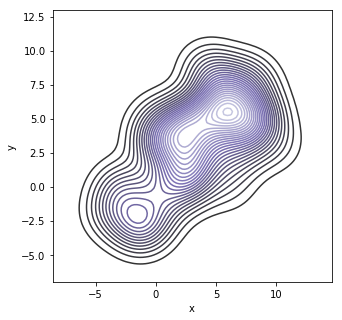

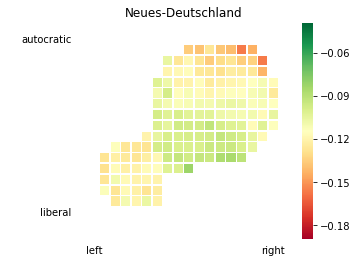

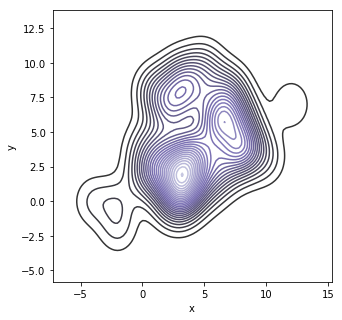

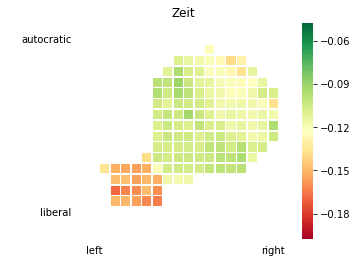

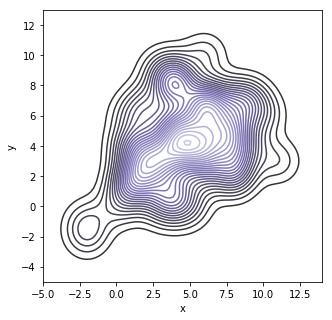

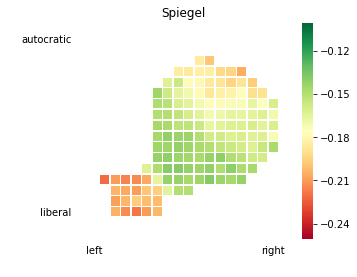

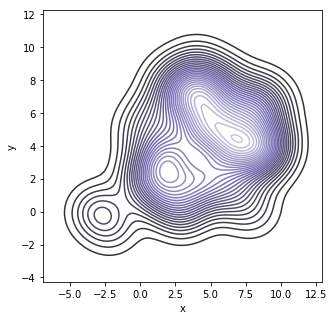

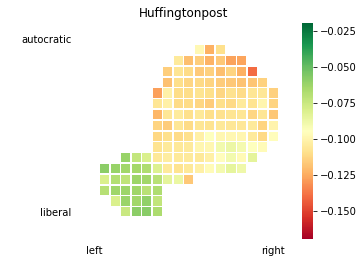

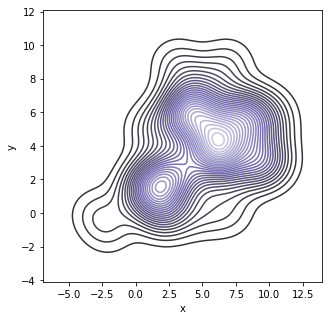

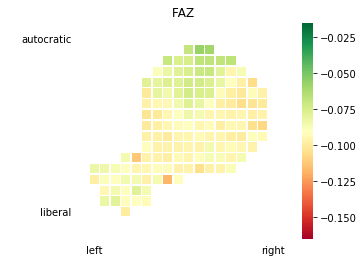

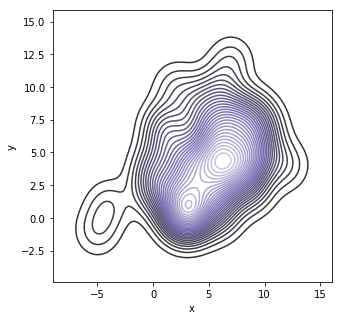

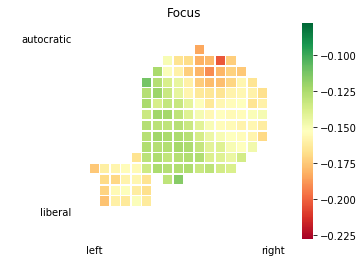

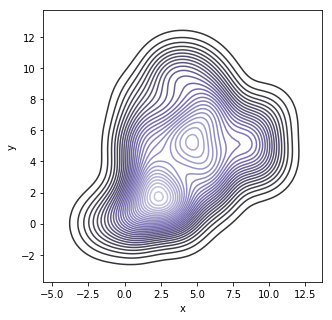

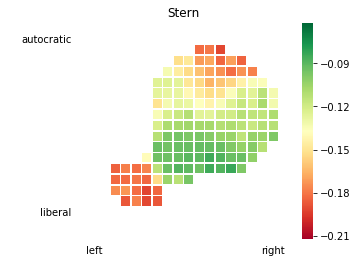

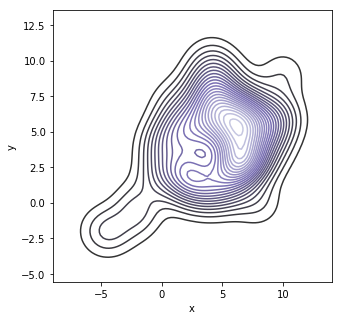

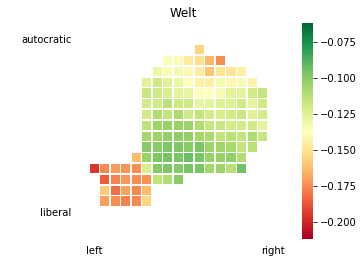

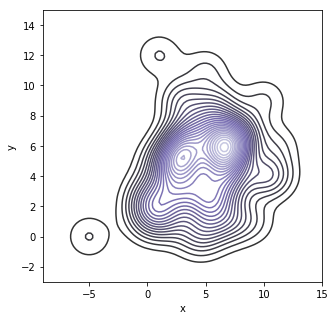

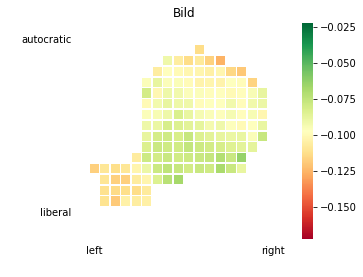

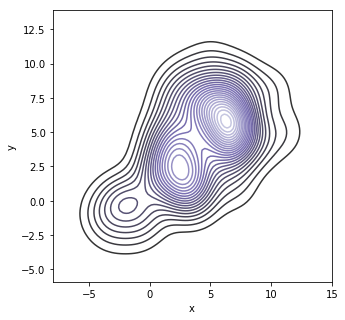

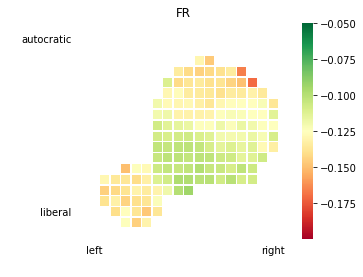

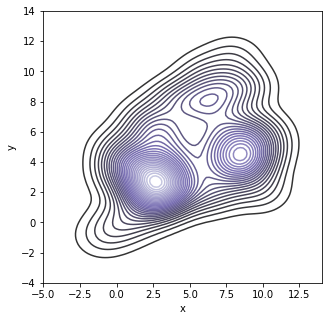

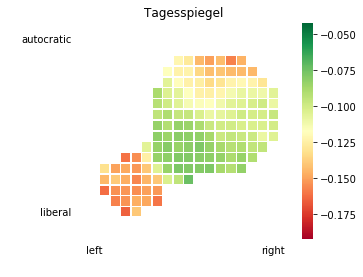

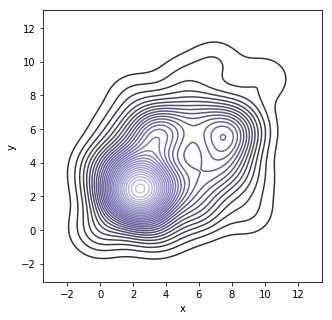

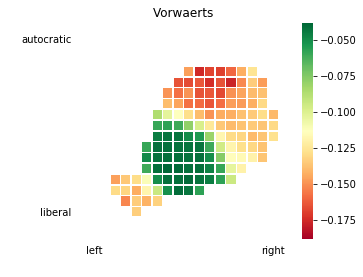

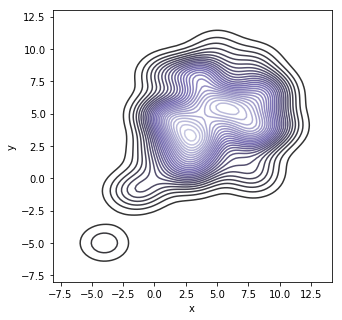

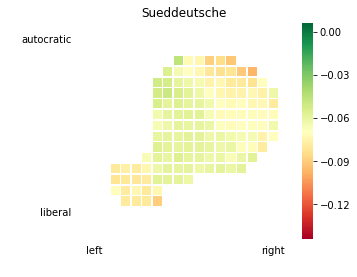

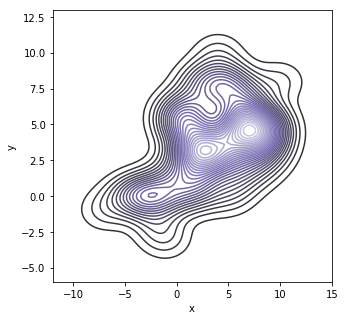

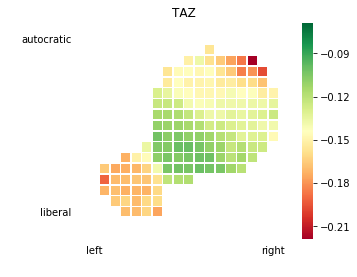

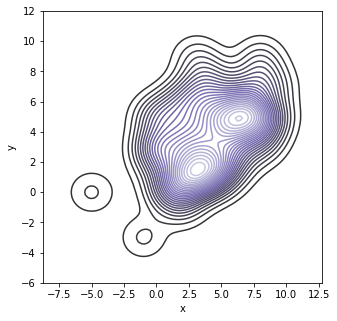

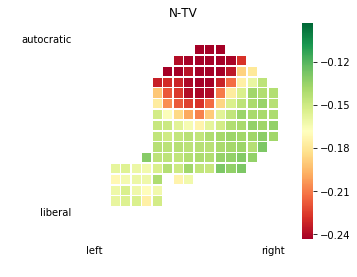

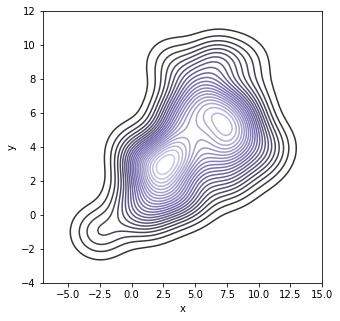

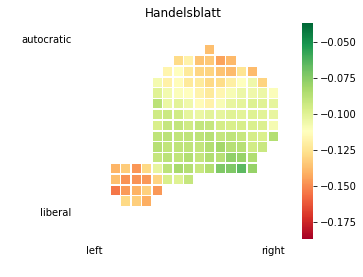

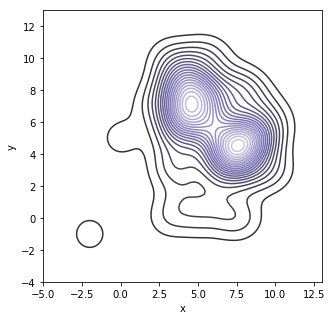

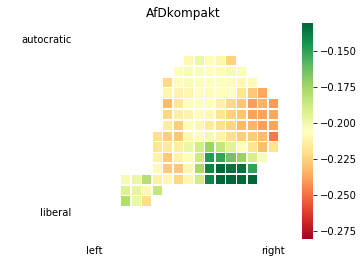

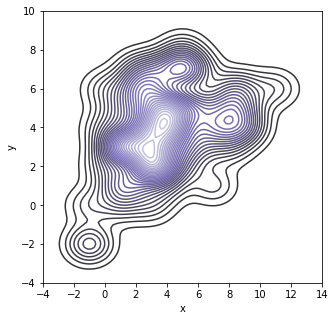

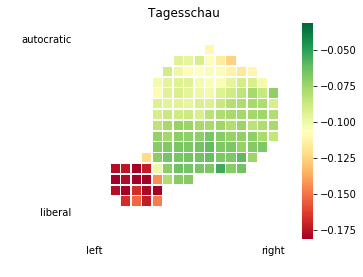

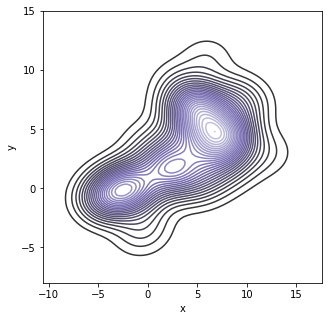

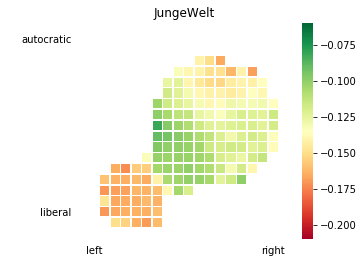

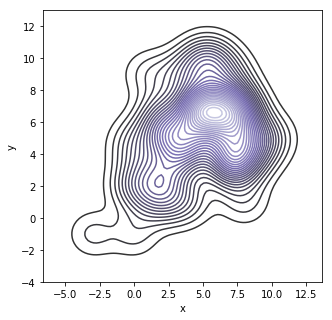

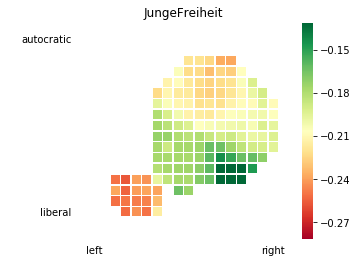

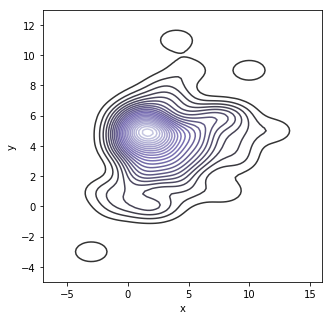

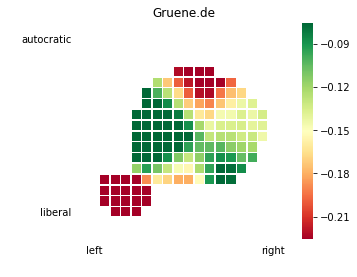

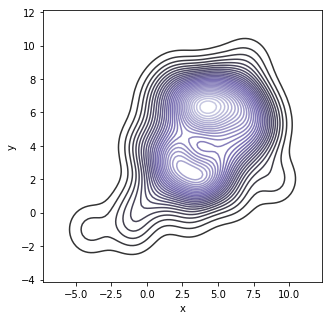

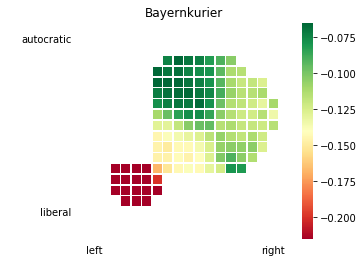

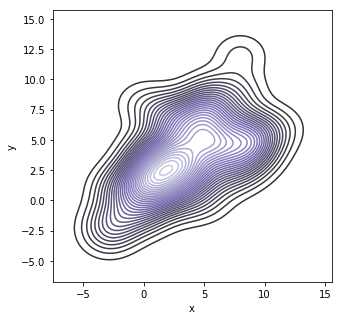

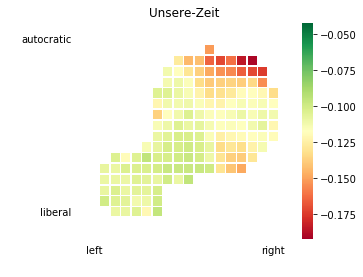

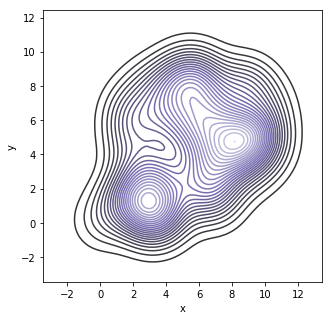

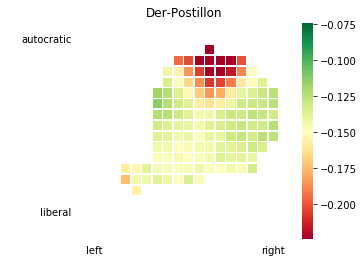

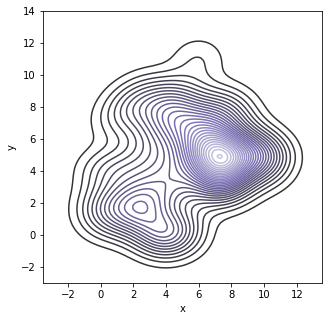

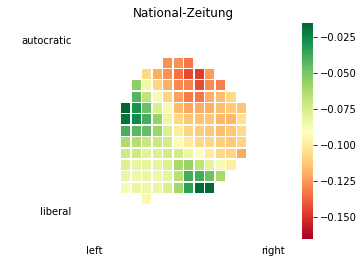

In [643]:
import scipy.ndimage

savename = 's15m750m15v9'
savefigures = True
coordinates = []
for news in allnewspapers:
    print("Bootstrapping: " + news)
    newsbootdf = bootstrap(df, news, 1500000, 1.5)
    print("Densityplot: " + news)
    plotcompdensity(newsbootdf,0.00005,news)
    print("Compass: " + news)
    coord = drawcompass(newsbootdf, newsbootdf.sentimentoriginal, 750, -0.3, 0.1, news)
    coordinates.append([news,coord[0],coord[1]])

codf1 = pd.DataFrame(coordinates, columns=['newspaper', 'x','y'])
savedf(codf1, 'coordinates_'+savename)